# Battery System Design Framework

Battery System Design Framework:
This framework aims to design and compare viable battery pack configurations (cell models, electronic configurations), in order to determine the best pack for an inputted use-case.

The current implementation takes a power profile (positive values indicate battery discharge) and iterates through energy capacity and minimum voltage redundance factors to determine the most cost efficient battery, which can deliver the required power over an inputted service life.

More details on how the framework has been designed and implemented can be found in the thesis attached: "Battery System Design Framework: applied to the investigation of virtual synchronous inertia provision"

Several csv files (attached) are required for the operation of this Framework:
- Required power timeseries csv (giving time vs power dispatch)
- BatPaC: https://www.anl.gov/partnerships/batpac-battery-manufacturing-cost-estimation, access must be given by Argone National Laboratories
- Cell Database

## Framework Set-Up

### Importing Packages and Modules

   C-rate      B     Ea      z
0     0.5  30330  31500  0.552
1     2.0  19330  31000  0.554
2     6.0  12000  29500  0.560
3    10.0  11500  28000  0.560


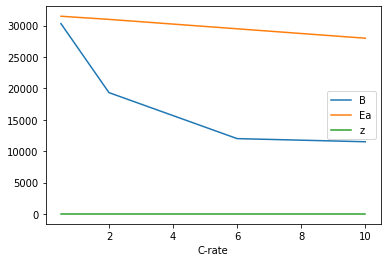

{'LFP':    C-rate      B     Ea      z
0     0.5  30330  31500  0.552
1     2.0  19330  31000  0.554
2     6.0  12000  29500  0.560
3    10.0  11500  28000  0.560}


In [18]:
# Importing Python Packages
from datetime import datetime as dt
import numpy as np
import datetime
from pathlib import Path
import os
import matplotlib.pyplot as plt
import math

## Importing Framework Modules
%run preprocessing_module.ipynb
%run batterysizing_module.ipynb
%run degradation_module.ipynb
%run cost_module.ipynb

today = datetime.datetime.today()
today = today.strftime("%Y-%m-%d")

### Setting Path Parameters

In [19]:
path = Path(os.path.abspath('../..'))

## Path to power-time series data (csv):
gd_path = path/

## Path to cell database (csv attached "Cell Database"):
cf_path = path/# /Cell_Database.csv

## Path to BatPaC
c_path = path/# /BatPaC.xlsm

## Path to save results data:
res_path = path/

C:\Users\gabri\Documents\ImperialCollegeLondon\Year 4\FYP


### Initial Conditions

In [ ]:
# Iteration Redundance Factors:
red_factor_p = 1 # Power (MW) redundance factor
red_factor_th_list = [1,2,3,4,5,6,7,8]  # Throughput (kWh) redundance factor

red_factor_voltage_list = [1,3,6] # Minimum Voltage (V) redundance Factor
min_design_voltage = 100 # Minimum design voltage required

In [ ]:
## Commercial Values:
expected_life = 365.25*24*60*60 #one year
prod_rate = 5000000##how many kWh produced every year (kWh) - 35GWh Tesla Gigafactory 1
cost_scale_factor = 1 ## Cost savings when purchasing many cells (1=no saving, 0 = 100% saving)

In [ ]:
## Power Electronics Assumptions:
efficiencies = {}
efficiencies['inverter_eff'] = 0.97
efficiencies['batt_dc_disch_eff'] = 0.9
efficiencies['batt_dc_ch_eff'] = 0.9

## Loading and Pre-Processing Data

### Cell Model Data

In [21]:
cf_clean = pd.read_csv(cf_path)
cf_clean.dropna(axis= 0)
print(cf_clean)

                                      Name      Brand Chemistry  Form Factor  \
0                         LG  INR18650 MJ1         LG       NMC  Cylindrical   
1                        Honcell HCP786387    Honcell       LCO        Pouch   
2                        Samsung 18650 30Q    Samsung       NCA  Cylindrical   
3                     Samsung INR21700-50E    Samsung       NMC  Cylindrical   
4                     Panasonic NCR18650BF  Panasonic       NCA  Cylindrical   
5                        LG INR 21700 M50T         LG       NMC  Cylindrical   
6                          Sony VTC6 18650       Sony       NMC  Cylindrical   
7                LG 18650 HG2  INR18650HG2         LG       NMC  Cylindrical   
8                           Sanyo NCR2070C      Sanyo       NCA  Cylindrical   
9                        Samsung 18650 25R    Samsung       NMC  Cylindrical   
10                     Panasonic NCR20700B  Panasonic       NCA  Cylindrical   
11                  Molicel INR-18650-P2

### Pre-Processing Dispatch Data

                               date      disch_MW
0     1970-01-01 00:00:00.000000000  0.000000e+00
1     1970-01-01 00:00:00.000000000  0.000000e+00
2     1970-01-01 00:00:00.009015173  0.000000e+00
3     1970-01-01 00:00:00.009015173  2.170000e-17
4     1970-01-01 00:00:00.030108923  2.213514e-01
...                             ...           ...
66903 1970-01-01 01:59:59.410946000 -9.993519e-02
66904 1970-01-01 01:59:59.563255000 -1.000370e-01
66905 1970-01-01 01:59:59.767350000 -9.958828e-02
66906 1970-01-01 01:59:59.929875000 -9.964839e-02
66907 1970-01-01 02:00:00.032155999 -7.216243e-02

[66908 rows x 2 columns]
avg_disch error
avg_ch error
avg_disch error
avg_ch error


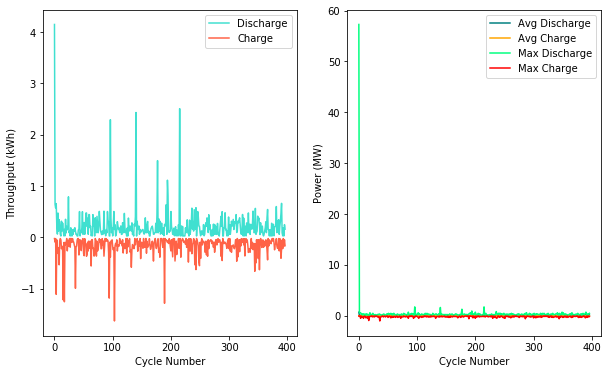

In [22]:
df = get_gd(gd_path)
df = process_gd(df)
df = ACtoDC(df, efficiencies)

# Saving Cycle DataFrame
df.to_csv(res_path/'01_Load'/f'{today}_dispatch.csv', mode = 'w',header = True)

# Graphic Cycle Dataframe
graph = graphGridData(res_path,df)

## Process

   C-rate      B     Ea      z
0     0.5  30330  31500  0.552
1     2.0  19330  31000  0.554
2     6.0  12000  29500  0.560
3    10.0  11500  28000  0.560


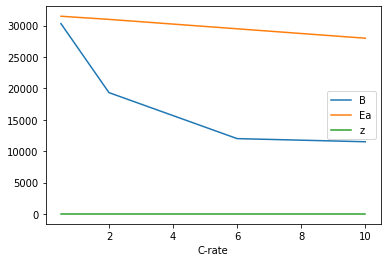

{'LFP':    C-rate      B     Ea      z
0     0.5  30330  31500  0.552
1     2.0  19330  31000  0.554
2     6.0  12000  29500  0.560
3    10.0  11500  28000  0.560}
LG  INR18650 MJ1
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 81, 'tot_cells': 2268, 'tot_cap': 28.5768}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.09081353869206
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.09081353869206, 'deg_life': 19499.227947843756, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076681  99.923319
1      1.0    40.991900  0.029398  99.893944
2      2.0    55.048716  0.028515  99.865459
3      3.0   115.972019  0.052322  99.813208
4      4.0   135.981311  0.018081  99.795161
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017474  92.155753
393  393.0  7154.056557  0.015804  92.141188
394  394.0  7167.057245  0.015334  92.127059
395  395.0  7179.997415  0.019202  92.109369
396  396.0  7200.023141  0.020145  92.090814

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 27, 'tot_cells': 2268, 'tot_cap': 28.5768}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.09081353869206
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.09081353869206, 'deg_life': 19499.227947843756, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076681  99.923319
1      1.0    40.991900  0.029398  99.893944
2      2.0    55.048716  0.028515  99.865459
3      3.0   115.972019  0.052322  99.813208
4      4.0   135.981311  0.018081  99.795161
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017474  92.155753
393  393.0  7154.056557  0.015804  92.141188
394  394.0  7167.057245  0.015334  92.127059
395  395.0  7179.997415  0.019202  92.109369
396  396.0  7200.023141  0.020145  92.090814

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 14, 'tot_cells': 2338, 'tot_cap': 29.4588}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.22259353484479
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.22259353484479, 'deg_life': 19843.611605664628, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.075405  99.924595
1      1.0    40.991900  0.028908  99.895709
2      2.0    55.048716  0.028034  99.867704
3      3.0   115.972019  0.051439  99.816333
4      4.0   135.981311  0.017776  99.798590
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017179  92.286527
393  393.0  7154.056557  0.015538  92.272188
394  394.0  7167.057245  0.015075  92.258278
395  395.0  7179.997415  0.018878  92.240862
396  396.0  7200.023141  0.019805  92.222594

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 162, 'tot_cells': 4536, 'tot_cap': 57.1536}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.66520452578091
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.66520452578091, 'deg_life': 29305.56068982414, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052302  99.947698
1      1.0    40.991900  0.020051  99.927657
2      2.0    55.048716  0.017906  99.909764
3      3.0   115.972019  0.035490  99.874307
4      4.0   135.981311  0.011428  99.862893
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011853  94.709153
393  393.0  7154.056557  0.010008  94.699674
394  394.0  7167.057245  0.009714  94.690475
395  395.0  7179.997415  0.013025  94.678142
396  396.0  7200.023141  0.013665  94.665205

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 54, 'tot_cells': 4536, 'tot_cap': 57.1536}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.66520452578091
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.66520452578091, 'deg_life': 29305.56068982414, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052302  99.947698
1      1.0    40.991900  0.020051  99.927657
2      2.0    55.048716  0.017906  99.909764
3      3.0   115.972019  0.035490  99.874307
4      4.0   135.981311  0.011428  99.862893
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011853  94.709153
393  393.0  7154.056557  0.010008  94.699674
394  394.0  7167.057245  0.009714  94.690475
395  395.0  7179.997415  0.013025  94.678142
396  396.0  7200.023141  0.013665  94.665205

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 28, 'tot_cells': 4676, 'tot_cap': 58.9176}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75655664518852
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75655664518852, 'deg_life': 29830.37946929514, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.051432  99.948568
1      1.0    40.991900  0.019718  99.928861
2      2.0    55.048716  0.017608  99.911266
3      3.0   115.972019  0.034891  99.876406
4      4.0   135.981311  0.011238  99.865182
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011653  94.798974
393  393.0  7154.056557  0.009842  94.789644
394  394.0  7167.057245  0.009553  94.780589
395  395.0  7179.997415  0.011924  94.769288
396  396.0  7200.023141  0.013434  94.756557

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 242, 'tot_cells': 6776, 'tot_cap': 85.37759999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77268216049326
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77268216049326, 'deg_life': 37196.99996827431, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041909  99.958091
1      1.0    40.991900  0.016067  99.942031
2      2.0    55.048716  0.014348  99.927692
3      3.0   115.972019  0.028346  99.899366
4      4.0   135.981311  0.009157  99.890219
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008854  95.807583
393  393.0  7154.056557  0.008019  95.799900
394  394.0  7167.057245  0.007784  95.792443
395  395.0  7179.997415  0.009716  95.783136
396  396.0  7200.023141  0.010914  95.772682

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 81, 'tot_cells': 6804, 'tot_cap': 85.73039999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  716

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.7826971197658
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.7826971197658, 'deg_life': 37287.26823003268, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041813  99.958187
1      1.0    40.991900  0.016030  99.942163
2      2.0    55.048716  0.014315  99.927856
3      3.0   115.972019  0.028281  99.899596
4      4.0   135.981311  0.009136  99.890469
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008834  95.817522
393  393.0  7154.056557  0.008001  95.809856
394  394.0  7167.057245  0.007766  95.802415
395  395.0  7179.997415  0.009694  95.793128
396  396.0  7200.023141  0.010889  95.782697

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 41, 'tot_cells': 6847, 'tot_cap': 86.2722}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.79776845657429
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.79776845657429, 'deg_life': 37423.922177988396, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041668  99.958332
1      1.0    40.991900  0.015975  99.942364
2      2.0    55.048716  0.014265  99.928107
3      3.0   115.972019  0.028181  99.899946
4      4.0   135.981311  0.009104  99.890851
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008803  95.832478
393  393.0  7154.056557  0.007973  95.824837
394  394.0  7167.057245  0.007739  95.817420
395  395.0  7179.997415  0.009660  95.808164
396  396.0  7200.023141  0.010851  95.797768

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 323, 'tot_cells': 9044, 'tot_cap': 113.95439999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43543109072843
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43543109072843, 'deg_life': 44264.27656327921, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035735  99.964265
1      1.0    40.991900  0.013700  99.950570
2      2.0    55.048716  0.012234  99.938343
3      3.0   115.972019  0.022254  99.916103
4      4.0   135.981311  0.007808  99.908301
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007550  96.465375
393  393.0  7154.056557  0.006838  96.458779
394  394.0  7167.057245  0.006637  96.452377
395  395.0  7179.997415  0.008285  96.444386
396  396.0  7200.023141  0.009285  96.435431

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 108, 'tot_cells': 9072, 'tot_cap': 114.3072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.44195775334957
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.44195775334957, 'deg_life': 44346.96387475795, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035674  99.964326
1      1.0    40.991900  0.013676  99.950655
2      2.0    55.048716  0.012213  99.938448
3      3.0   115.972019  0.022216  99.916246
4      4.0   135.981311  0.007795  99.908458
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007537  96.471852
393  393.0  7154.056557  0.006826  96.465267
394  394.0  7167.057245  0.006626  96.458875
395  395.0  7179.997415  0.008271  96.450898
396  396.0  7200.023141  0.009269  96.441958

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 55, 'tot_cells': 9185, 'tot_cap': 115.731}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.4664686063289
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.4664686063289, 'deg_life': 44660.223029338114, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035431  99.964569
1      1.0    40.991900  0.013583  99.950991
2      2.0    55.048716  0.012130  99.938867
3      3.0   115.972019  0.022064  99.916816
4      4.0   135.981311  0.007741  99.909081
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007485  96.496166
393  393.0  7154.056557  0.006780  96.489624
394  394.0  7167.057245  0.006581  96.483274
395  395.0  7179.997415  0.008214  96.475349
396  396.0  7200.023141  0.009205  96.466469

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 404, 'tot_cells': 11312, 'tot_cap': 142.53119999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86158554825182
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86158554825182, 'deg_life': 50385.099911164216, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031583  99.968417
1      1.0    40.991900  0.012108  99.956313
2      2.0    55.048716  0.010812  99.945506
3      3.0   115.972019  0.019668  99.925848
4      4.0   135.981311  0.006901  99.918953
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006672  96.888152
393  393.0  7154.056557  0.006043  96.882297
394  394.0  7167.057245  0.005866  96.876614
395  395.0  7179.997415  0.007322  96.869520
396  396.0  7200.023141  0.008191  96.861586

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 135, 'tot_cells': 11340, 'tot_cap': 142.884}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86580709617218
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86580709617218, 'deg_life': 50454.05886855912, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031539  99.968461
1      1.0    40.991900  0.012092  99.956373
2      2.0    55.048716  0.010798  99.945580
3      3.0   115.972019  0.019641  99.925949
4      4.0   135.981311  0.006891  99.919063
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006663  96.892339
393  393.0  7154.056557  0.006035  96.886491
394  394.0  7167.057245  0.005858  96.880815
395  395.0  7179.997415  0.007312  96.873731
396  396.0  7200.023141  0.008180  96.865807

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 68, 'tot_cells': 11356, 'tot_cap': 143.0856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86821222962791
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86821222962791, 'deg_life': 50493.429831315225, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031515  99.968485
1      1.0    40.991900  0.012082  99.956407
2      2.0    55.048716  0.010789  99.945622
3      3.0   115.972019  0.019626  99.926007
4      4.0   135.981311  0.006886  99.919126
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006658  96.894724
393  393.0  7154.056557  0.006030  96.888880
394  394.0  7167.057245  0.005853  96.883209
395  395.0  7179.997415  0.007306  96.876130
396  396.0  7200.023141  0.008173  96.868212

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 484, 'tot_cells': 13552, 'tot_cap': 170.75519999999997}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.1669909909838
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.1669909909838, 'deg_life': 55904.22097390474, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028585  99.971415
1      1.0    40.991900  0.010959  99.960460
2      2.0    55.048716  0.009786  99.950677
3      3.0   115.972019  0.017801  99.932885
4      4.0   135.981311  0.006246  99.926644
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006039  97.190659
393  393.0  7154.056557  0.005470  97.185343
394  394.0  7167.057245  0.005309  97.180183
395  395.0  7179.997415  0.006627  97.173743
396  396.0  7200.023141  0.006948  97.166991

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 162, 'tot_cells': 13608, 'tot_cap': 171.46079999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17334901757563
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17334901757563, 'deg_life': 56031.791472479905, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028520  99.971480
1      1.0    40.991900  0.010934  99.960550
2      2.0    55.048716  0.009764  99.950789
3      3.0   115.972019  0.017761  99.933038
4      4.0   135.981311  0.006231  99.926810
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006025  97.196965
393  393.0  7154.056557  0.005457  97.191660
394  394.0  7167.057245  0.005297  97.186512
395  395.0  7179.997415  0.006612  97.180086
396  396.0  7200.023141  0.006932  97.173349

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 82, 'tot_cells': 13694, 'tot_cap': 172.5444}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.18399704121511
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.18399704121511, 'deg_life': 56246.72867233806, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028421  99.971579
1      1.0    40.991900  0.010896  99.960686
2      2.0    55.048716  0.009730  99.950960
3      3.0   115.972019  0.017699  99.933270
4      4.0   135.981311  0.006210  99.927064
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006004  97.207533
393  393.0  7154.056557  0.005438  97.202247
394  394.0  7167.057245  0.005279  97.197115
395  395.0  7179.997415  0.006589  97.190711
396  396.0  7200.023141  0.006908  97.183997

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 565, 'tot_cells': 15820, 'tot_cap': 199.332}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.398010182949
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.398010182949, 'deg_life': 60939.69275667049, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026245  99.973755
1      1.0    40.991900  0.010062  99.963697
2      2.0    55.048716  0.008985  99.954715
3      3.0   115.972019  0.016344  99.938379
4      4.0   135.981311  0.005734  99.932648
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005545  97.419792
393  393.0  7154.056557  0.005022  97.414899
394  394.0  7167.057245  0.004875  97.410151
395  395.0  7179.997415  0.006085  97.404224
396  396.0  7200.023141  0.006379  97.398010

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 15876, 'tot_cap': 200.0376}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40301994704245
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40301994704245, 'deg_life': 61058.81322951287, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026193  99.973807
1      1.0    40.991900  0.010042  99.963767
2      2.0    55.048716  0.008967  99.954803
3      3.0   115.972019  0.016312  99.938499
4      4.0   135.981311  0.005723  99.932779
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005534  97.424760
393  393.0  7154.056557  0.005012  97.419877
394  394.0  7167.057245  0.004865  97.415137
395  395.0  7179.997415  0.006073  97.409222
396  396.0  7200.023141  0.006367  97.403020

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 15865, 'tot_cap': 199.899}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40203803321674
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40203803321674, 'deg_life': 61035.429419577005, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026203  99.973797
1      1.0    40.991900  0.010046  99.963753
2      2.0    55.048716  0.008971  99.954786
3      3.0   115.972019  0.016318  99.938475
4      4.0   135.981311  0.005725  99.932753
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005536  97.423786
393  393.0  7154.056557  0.005014  97.418901
394  394.0  7167.057245  0.004867  97.414160
395  395.0  7179.997415  0.006075  97.408242
396  396.0  7200.023141  0.006369  97.402038

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 646, 'tot_cells': 18088, 'tot_cap': 227.90879999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58450396321672
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58450396321672, 'deg_life': 65707.22889501027, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024374  99.975626
1      1.0    40.991900  0.009344  99.966284
2      2.0    55.048716  0.008344  99.957943
3      3.0   115.972019  0.015179  99.942770
4      4.0   135.981311  0.005326  99.937448
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005149  97.604771
393  393.0  7154.056557  0.004664  97.600219
394  394.0  7167.057245  0.004527  97.595801
395  395.0  7179.997415  0.005651  97.590286
396  396.0  7200.023141  0.005924  97.584504

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 216, 'tot_cells': 18144, 'tot_cap': 228.6144}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58857558177952
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58857558177952, 'deg_life': 65819.54109535363, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024332  99.975668
1      1.0    40.991900  0.009328  99.966342
2      2.0    55.048716  0.008330  99.958014
3      3.0   115.972019  0.015153  99.942868
4      4.0   135.981311  0.005316  99.937555
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005141  97.608809
393  393.0  7154.056557  0.004656  97.604264
394  394.0  7167.057245  0.004519  97.599853
395  395.0  7179.997415  0.005641  97.594348
396  396.0  7200.023141  0.005914  97.588576

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 109, 'tot_cells': 18203, 'tot_cap': 229.3578}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.59284445287861
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.59284445287861, 'deg_life': 65937.70232187813, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024289  99.975711
1      1.0    40.991900  0.009312  99.966402
2      2.0    55.048716  0.008315  99.958090
3      3.0   115.972019  0.015126  99.942970
4      4.0   135.981311  0.005307  99.937666
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005131  97.613043
393  393.0  7154.056557  0.004648  97.608506
394  394.0  7167.057245  0.004511  97.604103
395  395.0  7179.997415  0.005631  97.598606
396  396.0  7200.023141  0.005904  97.592844

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE LG  INR18650 MJ1
Honcell HCP786387
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 44, 'tot_cells': 1232, 'tot_cap': 28.71792}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

91.33732300217302
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 91.33732300217302, 'deg_life': 17731.227865127334, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.050412  99.949588
1      1.0    40.991900  0.018732  99.930865
2      2.0    55.048716  0.032897  99.897991
3      3.0   115.972019  0.061684  99.836370
4      4.0   135.981311  0.020523  99.815881
..     ...          ...       ...        ...
392  392.0  7140.064360  0.019810  91.410384
393  393.0  7154.056557  0.017853  91.394065
394  394.0  7167.057245  0.017302  91.378252
395  395.0  7179.997415  0.021842  91.358293
396  396.0  7200.023141  0.022954  91.337323

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 15, 'tot_cells': 1230, 'tot_cap': 28.6713}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

91.32952650658854
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 91.32952650658854, 'deg_life': 17714.539256344142, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.050459  99.949541
1      1.0    40.991900  0.018749  99.930801
2      2.0    55.048716  0.032928  99.897896
3      3.0   115.972019  0.061742  99.836217
4      4.0   135.981311  0.020542  99.815708
..     ...          ...       ...        ...
392  392.0  7140.064360  0.019829  91.402651
393  393.0  7154.056557  0.017870  91.386317
394  394.0  7167.057245  0.017319  91.370491
395  395.0  7179.997415  0.021862  91.350515
396  396.0  7200.023141  0.022976  91.329527

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 8, 'tot_cells': 1304, 'tot_cap': 30.39624}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

91.64764986676423
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 91.64764986676423, 'deg_life': 18420.77314824501, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.048806  99.951194
1      1.0    40.991900  0.018135  99.933067
2      2.0    55.048716  0.031831  99.901258
3      3.0   115.972019  0.059685  99.841631
4      4.0   135.981311  0.019858  99.821805
..     ...          ...       ...        ...
392  392.0  7140.064360  0.019168  91.718583
393  393.0  7154.056557  0.017274  91.702739
394  394.0  7167.057245  0.016742  91.687387
395  395.0  7179.997415  0.021134  91.668010
396  396.0  7200.023141  0.022210  91.647650

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 88, 'tot_cells': 2464, 'tot_cap': 57.43584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.94034084526662
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.94034084526662, 'deg_life': 30943.621942490034, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.033958  99.966042
1      1.0    40.991900  0.012618  99.953428
2      2.0    55.048716  0.011227  99.942206
3      3.0   115.972019  0.041264  99.900966
4      4.0   135.981311  0.007061  99.893912
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013252  94.980316
393  393.0  7154.056557  0.006157  94.974468
394  394.0  7167.057245  0.005970  94.968798
395  395.0  7179.997415  0.014611  94.954922
396  396.0  7200.023141  0.015355  94.940341

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 30, 'tot_cells': 2460, 'tot_cap': 57.3426}


C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   4.028600   2.981889   5.929681      0.344127   
396      396.0  7179.997415   3.928769   6.034087  10.062870      0.458930   

     max_ch_MW  avg_disch_MW  avg_ch

C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 15, 'tot_cells': 2445, 'tot_cap': 56.99295}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.89807834187785
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.89807834187785, 'deg_life': 30680.524392106792, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.034109  99.965891
1      1.0    40.991900  0.012674  99.953222
2      2.0    55.048716  0.011276  99.941951
3      3.0   115.972019  0.041450  99.900525
4      4.0   135.981311  0.007092  99.893440
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013312  94.938215
393  393.0  7154.056557  0.006184  94.932343
394  394.0  7167.057245  0.005997  94.926651
395  395.0  7179.997415  0.014677  94.912718
396  396.0  7200.023141  0.015425  94.898078

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 131, 'tot_cells': 3668, 'tot_cap': 85.50108}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.44892890426
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.44892890426, 'deg_life': 44435.618144359534, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.027068  99.972932
1      1.0    40.991900  0.010058  99.962877
2      2.0    55.048716  0.008949  99.953931
3      3.0   115.972019  0.032761  99.921185
4      4.0   135.981311  0.005628  99.915562
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005436  96.475786
393  393.0  7154.056557  0.004908  96.471052
394  394.0  7167.057245  0.004759  96.466461
395  395.0  7179.997415  0.005983  96.460689
396  396.0  7200.023141  0.012191  96.448929

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 45, 'tot_cells': 3690, 'tot_cap': 86.01389999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  716

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.46091730482769
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.46091730482769, 'deg_life': 44588.894988458174, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026976  99.973024
1      1.0    40.991900  0.010024  99.963003
2      2.0    55.048716  0.008918  99.954088
3      3.0   115.972019  0.032648  99.921455
4      4.0   135.981311  0.005609  99.915851
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005417  96.487686
393  393.0  7154.056557  0.004891  96.482967
394  394.0  7167.057245  0.004743  96.478391
395  395.0  7179.997415  0.005963  96.472638
396  396.0  7200.023141  0.012149  96.460917

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 23, 'tot_cells': 3749, 'tot_cap': 87.38919}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.50807695724978
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.50807695724978, 'deg_life': 45202.06344324978, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026733  99.973267
1      1.0    40.991900  0.009933  99.963336
2      2.0    55.048716  0.008838  99.954501
3      3.0   115.972019  0.032349  99.922167
4      4.0   135.981311  0.005558  99.916613
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005369  96.534616
393  393.0  7154.056557  0.004847  96.529937
394  394.0  7167.057245  0.004700  96.525400
395  395.0  7179.997415  0.005909  96.519696
396  396.0  7200.023141  0.012038  96.508077

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 175, 'tot_cells': 4900, 'tot_cap': 114.219}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.36917764822341
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.36917764822341, 'deg_life': 60262.941019645674, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.022949  99.977051
1      1.0    40.991900  0.008527  99.968525
2      2.0    55.048716  0.007587  99.960941
3      3.0   115.972019  0.014073  99.946873
4      4.0   135.981311  0.004772  99.942104
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004609  97.392136
393  393.0  7154.056557  0.004161  97.388084
394  394.0  7167.057245  0.004035  97.384154
395  395.0  7179.997415  0.005073  97.379214
396  396.0  7200.023141  0.010306  97.369178

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 60, 'tot_cells': 4920, 'tot_cap': 114.6852}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.3797924216431
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.3797924216431, 'deg_life': 60510.35677866774, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.022896  99.977104
1      1.0    40.991900  0.008508  99.968598
2      2.0    55.048716  0.007569  99.961031
3      3.0   115.972019  0.014040  99.946997
4      4.0   135.981311  0.004761  99.942238
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004598  97.402700
393  393.0  7154.056557  0.004151  97.398656
394  394.0  7167.057245  0.004025  97.394735
395  395.0  7179.997415  0.005061  97.389806
396  396.0  7200.023141  0.010282  97.379792

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 30, 'tot_cells': 4890, 'tot_cap': 113.9859}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.3661338181871
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.3661338181871, 'deg_life': 60192.36142560656, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.022976  99.977024
1      1.0    40.991900  0.008537  99.968488
2      2.0    55.048716  0.007596  99.960895
3      3.0   115.972019  0.014089  99.946811
4      4.0   135.981311  0.004777  99.942037
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004614  97.389118
393  393.0  7154.056557  0.004166  97.385061
394  394.0  7167.057245  0.004040  97.381127
395  395.0  7179.997415  0.005079  97.376182
396  396.0  7200.023141  0.010318  97.366134

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 218, 'tot_cells': 6104, 'tot_cap': 142.28423999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.82225496561065
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.82225496561065, 'deg_life': 72969.0695058288, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.020248  99.979752
1      1.0    40.991900  0.007524  99.972230
2      2.0    55.048716  0.006694  99.965538
3      3.0   115.972019  0.012416  99.953126
4      4.0   135.981311  0.004210  99.948918
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004066  97.842585
393  393.0  7154.056557  0.003671  97.838993
394  394.0  7167.057245  0.003560  97.835510
395  395.0  7179.997415  0.004476  97.831131
396  396.0  7200.023141  0.009073  97.822255

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 75, 'tot_cells': 6150, 'tot_cap': 143.3565}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.83149281610461
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.83149281610461, 'deg_life': 73283.36541965653, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.020162  99.979838
1      1.0    40.991900  0.007492  99.972348
2      2.0    55.048716  0.006665  99.965685
3      3.0   115.972019  0.012363  99.953326
4      4.0   135.981311  0.004192  99.949136
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004049  97.851737
393  393.0  7154.056557  0.003655  97.848161
394  394.0  7167.057245  0.003545  97.844692
395  395.0  7179.997415  0.004457  97.840331
396  396.0  7200.023141  0.009034  97.831493

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 38, 'tot_cells': 6194, 'tot_cap': 144.38214}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.85093419742947
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.85093419742947, 'deg_life': 73953.63885918955, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.020080  99.979920
1      1.0    40.991900  0.007461  99.972460
2      2.0    55.048716  0.006638  99.965824
3      3.0   115.972019  0.012313  99.953515
4      4.0   135.981311  0.004175  99.949342
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004033  97.871100
393  393.0  7154.056557  0.003641  97.867537
394  394.0  7167.057245  0.003530  97.864082
395  395.0  7179.997415  0.004439  97.859738
396  396.0  7200.023141  0.008996  97.850934

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 262, 'tot_cells': 7336, 'tot_cap': 171.00216}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.13129716301775
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.13129716301775, 'deg_life': 85170.30391089113, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.018234  99.981766
1      1.0    40.991900  0.006775  99.974993
2      2.0    55.048716  0.006028  99.968966
3      3.0   115.972019  0.011181  99.957789
4      4.0   135.981311  0.003791  99.953999
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003662  98.145797
393  393.0  7154.056557  0.003306  98.142552
394  394.0  7167.057245  0.003206  98.139406
395  395.0  7179.997415  0.004031  98.135450
396  396.0  7200.023141  0.004232  98.131297

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 90, 'tot_cells': 7380, 'tot_cap': 172.02779999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.1459114635985
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.1459114635985, 'deg_life': 85848.00523065358, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.018172  99.981828
1      1.0    40.991900  0.006752  99.975078
2      2.0    55.048716  0.006007  99.969072
3      3.0   115.972019  0.011143  99.957932
4      4.0   135.981311  0.003778  99.954156
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003649  98.160364
393  393.0  7154.056557  0.003295  98.157130
394  394.0  7167.057245  0.003195  98.153994
395  395.0  7179.997415  0.004017  98.150051
396  396.0  7200.023141  0.004218  98.145911

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 45, 'tot_cells': 7335, 'tot_cap': 170.97884999999997}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.13115292741398
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.13115292741398, 'deg_life': 85163.66816755595, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.018235  99.981765
1      1.0    40.991900  0.006776  99.974991
2      2.0    55.048716  0.006028  99.968964
3      3.0   115.972019  0.011182  99.957785
4      4.0   135.981311  0.003791  99.953996
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003662  98.145654
393  393.0  7154.056557  0.003306  98.142409
394  394.0  7167.057245  0.003206  98.139262
395  395.0  7179.997415  0.004031  98.135307
396  396.0  7200.023141  0.004233  98.131153

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 306, 'tot_cells': 8568, 'tot_cap': 199.72008}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.30436290948485
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.30436290948485, 'deg_life': 93945.72318477712, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.016689  99.983311
1      1.0    40.991900  0.006201  99.977110
2      2.0    55.048716  0.005517  99.971594
3      3.0   115.972019  0.010234  99.961363
4      4.0   135.981311  0.003470  99.957894
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003352  98.317658
393  393.0  7154.056557  0.003026  98.314683
394  394.0  7167.057245  0.002934  98.311798
395  395.0  7179.997415  0.003689  98.308171
396  396.0  7200.023141  0.003874  98.304363

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 105, 'tot_cells': 8610, 'tot_cap': 200.6991}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.30905356260234
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.30905356260234, 'deg_life': 94208.56795873401, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.016643  99.983357
1      1.0    40.991900  0.006184  99.977174
2      2.0    55.048716  0.005502  99.971673
3      3.0   115.972019  0.010206  99.961470
4      4.0   135.981311  0.003460  99.958011
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003342  98.322312
393  393.0  7154.056557  0.003018  98.319345
394  394.0  7167.057245  0.002926  98.316468
395  395.0  7179.997415  0.003679  98.312851
396  396.0  7200.023141  0.003863  98.309054

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 53, 'tot_cells': 8639, 'tot_cap': 201.37509}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.31227154523641
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.31227154523641, 'deg_life': 94389.73534174911, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.016611  99.983389
1      1.0    40.991900  0.006172  99.977218
2      2.0    55.048716  0.005492  99.971727
3      3.0   115.972019  0.010186  99.961544
4      4.0   135.981311  0.003454  99.958092
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003336  98.325505
393  393.0  7154.056557  0.003012  98.322544
394  394.0  7167.057245  0.002920  98.319672
395  395.0  7179.997415  0.003672  98.316062
396  396.0  7200.023141  0.003856  98.312272

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 349, 'tot_cells': 9772, 'tot_cap': 227.78531999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.45260659417406
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.45260659417406, 'deg_life': 103023.31053229538, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.015484  99.984516
1      1.0    40.991900  0.005754  99.978763
2      2.0    55.048716  0.005119  99.973645
3      3.0   115.972019  0.009495  99.964152
4      4.0   135.981311  0.003220  99.960934
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003110  98.464960
393  393.0  7154.056557  0.002807  98.462196
394  394.0  7167.057245  0.002722  98.459515
395  395.0  7179.997415  0.003423  98.456145
396  396.0  7200.023141  0.003594  98.452607

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 120, 'tot_cells': 9840, 'tot_cap': 229.3704}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.4586744203961
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.4586744203961, 'deg_life': 103432.06734723077, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.015423  99.984577
1      1.0    40.991900  0.005731  99.978847
2      2.0    55.048716  0.005099  99.973749
3      3.0   115.972019  0.009458  99.964294
4      4.0   135.981311  0.003207  99.961088
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003097  98.470980
393  393.0  7154.056557  0.002796  98.468226
394  394.0  7167.057245  0.002712  98.465556
395  395.0  7179.997415  0.003409  98.462199
396  396.0  7200.023141  0.003580  98.458674

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 60, 'tot_cells': 9780, 'tot_cap': 227.9718}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.45332387551213
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.45332387551213, 'deg_life': 103071.46276607188, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.015477  99.984523
1      1.0    40.991900  0.005751  99.978773
2      2.0    55.048716  0.005117  99.973657
3      3.0   115.972019  0.009491  99.964169
4      4.0   135.981311  0.003218  99.960952
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003108  98.465672
393  393.0  7154.056557  0.002806  98.462909
394  394.0  7167.057245  0.002721  98.460229
395  395.0  7179.997415  0.003421  98.456861
396  396.0  7200.023141  0.003592  98.453324

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Honcell HCP786387
Samsung 18650 30Q
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 2660, 'tot_cap': 28.728000000000005}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.8

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.04135619478436
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.04135619478436, 'deg_life': 22275.413500751016, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.158200  99.841800
1      1.0    40.991900  0.055799  99.786090
2      2.0    55.048716  0.023074  99.763065
3      3.0   115.972019  0.046676  99.716499
4      4.0   135.981311  0.013598  99.702940
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013070  93.090553
393  393.0  7154.056557  0.011631  93.079725
394  394.0  7167.057245  0.011230  93.069272
395  395.0  7179.997415  0.014581  93.055701
396  396.0  7200.023141  0.015416  93.041356

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 32, 'tot_cells': 2688, 'tot_cap': 29.0304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.07866479787825
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.07866479787825, 'deg_life': 22399.922272900552, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.157209  99.842791
1      1.0    40.991900  0.055449  99.787429
2      2.0    55.048716  0.022918  99.764560
3      3.0   115.972019  0.046359  99.718310
4      4.0   135.981311  0.013506  99.704842
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012981  93.127547
393  393.0  7154.056557  0.011553  93.116789
394  394.0  7167.057245  0.011154  93.106402
395  395.0  7179.997415  0.014482  93.092918
396  396.0  7200.023141  0.015311  93.078665

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 16, 'tot_cells': 2672, 'tot_cap': 28.8576}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.06068885299331
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.06068885299331, 'deg_life': 22339.764687525032, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.157773  99.842227
1      1.0    40.991900  0.055648  99.786666
2      2.0    55.048716  0.023007  99.763709
3      3.0   115.972019  0.046539  99.717279
4      4.0   135.981311  0.013558  99.703759
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013032  93.109752
393  393.0  7154.056557  0.011597  93.098954
394  394.0  7167.057245  0.011198  93.088529
395  395.0  7179.997415  0.014538  93.074995
396  396.0  7200.023141  0.015371  93.060689

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 5292, 'tot_cap': 57.153600000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.07946448428659
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.07946448428659, 'deg_life': 26325.22302864128, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104704  99.895296
1      1.0    40.991900  0.036930  99.858404
2      2.0    55.048716  0.032656  99.825795
3      3.0   115.972019  0.029848  99.795999
4      4.0   135.981311  0.020043  99.775997
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008358  94.129657
393  393.0  7154.056557  0.017352  94.113324
394  394.0  7167.057245  0.016799  94.097513
395  395.0  7179.997415  0.009324  94.088740
396  396.0  7200.023141  0.009858  94.079464

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 63, 'tot_cells': 5292, 'tot_cap': 57.153600000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.07946448428659
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.07946448428659, 'deg_life': 26325.22302864128, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104704  99.895296
1      1.0    40.991900  0.036930  99.858404
2      2.0    55.048716  0.032656  99.825795
3      3.0   115.972019  0.029848  99.795999
4      4.0   135.981311  0.020043  99.775997
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008358  94.129657
393  393.0  7154.056557  0.017352  94.113324
394  394.0  7167.057245  0.016799  94.097513
395  395.0  7179.997415  0.009324  94.088740
396  396.0  7200.023141  0.009858  94.079464

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 32, 'tot_cells': 5344, 'tot_cap': 57.7152}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.09970716574229
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.09970716574229, 'deg_life': 26418.352264407185, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104091  99.895909
1      1.0    40.991900  0.036714  99.859233
2      2.0    55.048716  0.032465  99.826814
3      3.0   115.972019  0.029659  99.797206
4      4.0   135.981311  0.019926  99.777321
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008305  94.149608
393  393.0  7154.056557  0.017251  94.133367
394  394.0  7167.057245  0.016701  94.117646
395  395.0  7179.997415  0.009265  94.108926
396  396.0  7200.023141  0.009795  94.099707

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 283, 'tot_cells': 7924, 'tot_cap': 85.57920000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.53123897862619
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.53123897862619, 'deg_life': 28567.628900130585, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.082180  99.917820
1      1.0    40.991900  0.028986  99.888857
2      2.0    55.048716  0.025631  99.863255
3      3.0   115.972019  0.022959  99.840327
4      4.0   135.981311  0.015732  99.824621
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015167  94.579622
393  393.0  7154.056557  0.013619  94.566741
394  394.0  7167.057245  0.013185  94.554272
395  395.0  7179.997415  0.016779  94.538408
396  396.0  7200.023141  0.007583  94.531239

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 7980, 'tot_cap': 86.184}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.54506772798514
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.54506772798514, 'deg_life': 28642.125593901143, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.081834  99.918166
1      1.0    40.991900  0.028864  99.889326
2      2.0    55.048716  0.025523  99.863831
3      3.0   115.972019  0.022854  99.841008
4      4.0   135.981311  0.015665  99.825368
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015103  94.593252
393  393.0  7154.056557  0.013562  94.580423
394  394.0  7167.057245  0.013130  94.568005
395  395.0  7179.997415  0.016708  94.552205
396  396.0  7200.023141  0.007548  94.545068

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 48, 'tot_cells': 8016, 'tot_cap': 86.5728}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.55965665252128
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.55965665252128, 'deg_life': 28721.127832455186, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.081613  99.918387
1      1.0    40.991900  0.028786  99.889624
2      2.0    55.048716  0.025454  99.864198
3      3.0   115.972019  0.022787  99.841442
4      4.0   135.981311  0.015623  99.825844
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015062  94.607716
393  393.0  7154.056557  0.013525  94.594920
394  394.0  7167.057245  0.013094  94.582534
395  395.0  7179.997415  0.016663  94.566774
396  396.0  7200.023141  0.007526  94.559657

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 377, 'tot_cells': 10556, 'tot_cap': 114.0048}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75355223292006
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75355223292006, 'deg_life': 29812.828509617757, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069189  99.930811
1      1.0    40.991900  0.024404  99.906424
2      2.0    55.048716  0.021579  99.884866
3      3.0   115.972019  0.041349  99.843565
4      4.0   135.981311  0.013245  99.830341
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012769  94.794294
393  393.0  7154.056557  0.011466  94.783425
394  394.0  7167.057245  0.011101  94.772903
395  395.0  7179.997415  0.014126  94.759516
396  396.0  7200.023141  0.006293  94.753552

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 126, 'tot_cells': 10584, 'tot_cap': 114.30720000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75407301725537
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75407301725537, 'deg_life': 29815.86935014434, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069079  99.930921
1      1.0    40.991900  0.024365  99.906573
2      2.0    55.048716  0.021545  99.885048
3      3.0   115.972019  0.041283  99.843813
4      4.0   135.981311  0.013224  99.830610
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012749  94.794750
393  393.0  7154.056557  0.011448  94.783898
394  394.0  7167.057245  0.011083  94.773393
395  395.0  7179.997415  0.014104  94.760026
396  396.0  7200.023141  0.006282  94.754073

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 64, 'tot_cells': 10688, 'tot_cap': 115.4304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.7842242549217
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.7842242549217, 'deg_life': 29992.956353111364, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.068675  99.931325
1      1.0    40.991900  0.024222  99.907120
2      2.0    55.048716  0.021419  99.885721
3      3.0   115.972019  0.041041  99.844726
4      4.0   135.981311  0.013146  99.831600
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012674  94.824673
393  393.0  7154.056557  0.011381  94.813881
394  394.0  7167.057245  0.011018  94.803434
395  395.0  7179.997415  0.014021  94.790141
396  396.0  7200.023141  0.006242  94.784224

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 471, 'tot_cells': 13188, 'tot_cap': 142.43040000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.15650129291394
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.15650129291394, 'deg_life': 32361.070494116495, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060538  99.939462
1      1.0    40.991900  0.021352  99.918123
2      2.0    55.048716  0.018881  99.899257
3      3.0   115.972019  0.036179  99.863115
4      4.0   135.981311  0.011589  99.851542
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011173  95.192242
393  393.0  7154.056557  0.010033  95.182691
394  394.0  7167.057245  0.009713  95.173446
395  395.0  7179.997415  0.012360  95.161683
396  396.0  7200.023141  0.005445  95.156501

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 157, 'tot_cells': 13188, 'tot_cap': 142.43040000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.15650129291394
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.15650129291394, 'deg_life': 32361.070494116495, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060538  99.939462
1      1.0    40.991900  0.021352  99.918123
2      2.0    55.048716  0.018881  99.899257
3      3.0   115.972019  0.036179  99.863115
4      4.0   135.981311  0.011589  99.851542
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011173  95.192242
393  393.0  7154.056557  0.010033  95.182691
394  394.0  7167.057245  0.009713  95.173446
395  395.0  7179.997415  0.012360  95.161683
396  396.0  7200.023141  0.005445  95.156501

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 79, 'tot_cells': 13193, 'tot_cap': 142.48440000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.15758180578969
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.15758180578969, 'deg_life': 32368.473632749494, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060524  99.939476
1      1.0    40.991900  0.021348  99.918141
2      2.0    55.048716  0.018877  99.899280
3      3.0   115.972019  0.036171  99.863146
4      4.0   135.981311  0.011586  99.851576
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011170  95.193314
393  393.0  7154.056557  0.010030  95.183766
394  394.0  7167.057245  0.009711  95.174523
395  395.0  7179.997415  0.012357  95.162762
396  396.0  7200.023141  0.005444  95.157582

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 565, 'tot_cells': 15820, 'tot_cap': 170.856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.49216147072244
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.49216147072244, 'deg_life': 34831.505263948195, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054276  99.945724
1      1.0    40.991900  0.019144  99.926590
2      2.0    55.048716  0.016928  99.909674
3      3.0   115.972019  0.032437  99.877267
4      4.0   135.981311  0.010390  99.866890
..     ...          ...       ...        ...
392  392.0  7140.064360  0.010017  95.530799
393  393.0  7154.056557  0.008995  95.522206
394  394.0  7167.057245  0.008708  95.513887
395  395.0  7179.997415  0.011082  95.503303
396  396.0  7200.023141  0.011666  95.492161

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 15876, 'tot_cap': 171.4608}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.50152129308498
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.50152129308498, 'deg_life': 34905.675328110665, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054161  99.945839
1      1.0    40.991900  0.019103  99.926746
2      2.0    55.048716  0.016892  99.909866
3      3.0   115.972019  0.032368  99.877527
4      4.0   135.981311  0.010368  99.867172
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009996  95.540080
393  393.0  7154.056557  0.008976  95.531505
394  394.0  7167.057245  0.008690  95.523203
395  395.0  7179.997415  0.011058  95.512640
396  396.0  7200.023141  0.011641  95.501521

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 15865, 'tot_cap': 171.342}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.49968686244732
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.49968686244732, 'deg_life': 34891.114441170575, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054184  99.945816
1      1.0    40.991900  0.019111  99.926715
2      2.0    55.048716  0.016899  99.909828
3      3.0   115.972019  0.032381  99.877476
4      4.0   135.981311  0.010372  99.867116
..     ...          ...       ...        ...
392  392.0  7140.064360  0.010000  95.538261
393  393.0  7154.056557  0.008980  95.529682
394  394.0  7167.057245  0.008693  95.521377
395  395.0  7179.997415  0.011063  95.510810
396  396.0  7200.023141  0.011646  95.499687

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 659, 'tot_cells': 18452, 'tot_cap': 199.2816}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.85599151765827
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.85599151765827, 'deg_life': 37961.17463560405, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049489  99.950511
1      1.0    40.991900  0.017455  99.933064
2      2.0    55.048716  0.015435  99.917640
3      3.0   115.972019  0.029576  99.888088
4      4.0   135.981311  0.009474  99.878625
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009133  95.891354
393  393.0  7154.056557  0.008202  95.883489
394  394.0  7167.057245  0.007940  95.875876
395  395.0  7179.997415  0.010104  95.866189
396  396.0  7200.023141  0.010637  95.855992

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 220, 'tot_cells': 18480, 'tot_cap': 199.584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.85969134628256
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.85969134628256, 'deg_life': 37995.825275120726, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049444  99.950556
1      1.0    40.991900  0.017439  99.933125
2      2.0    55.048716  0.015421  99.917715
3      3.0   115.972019  0.029549  99.888190
4      4.0   135.981311  0.009465  99.878736
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009125  95.895023
393  393.0  7154.056557  0.008194  95.887165
394  394.0  7167.057245  0.007933  95.879559
395  395.0  7179.997415  0.010095  95.869880
396  396.0  7200.023141  0.010627  95.859691

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 111, 'tot_cells': 18537, 'tot_cap': 200.1996}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.86719590301807
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.86719590301807, 'deg_life': 38066.299503439106, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049353  99.950647
1      1.0    40.991900  0.017407  99.933249
2      2.0    55.048716  0.015392  99.917866
3      3.0   115.972019  0.029494  99.888396
4      4.0   135.981311  0.009447  99.878959
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009108  95.902465
393  393.0  7154.056557  0.008179  95.894621
394  394.0  7167.057245  0.007918  95.887028
395  395.0  7179.997415  0.010076  95.877366
396  396.0  7200.023141  0.010608  95.867196

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 753, 'tot_cells': 21084, 'tot_cap': 227.7072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.12439898718003
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.12439898718003, 'deg_life': 40646.603655857936, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045684  99.954316
1      1.0    40.991900  0.016113  99.938210
2      2.0    55.048716  0.014248  99.923971
3      3.0   115.972019  0.027302  99.896690
4      4.0   135.981311  0.008745  99.887954
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008431  96.157133
393  393.0  7154.056557  0.007571  96.149853
394  394.0  7167.057245  0.007330  96.142806
395  395.0  7179.997415  0.009327  96.133838
396  396.0  7200.023141  0.009819  96.124399

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 251, 'tot_cells': 21084, 'tot_cap': 227.7072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.12439898718003
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.12439898718003, 'deg_life': 40646.603655857936, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045684  99.954316
1      1.0    40.991900  0.016113  99.938210
2      2.0    55.048716  0.014248  99.923971
3      3.0   115.972019  0.027302  99.896690
4      4.0   135.981311  0.008745  99.887954
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008431  96.157133
393  393.0  7154.056557  0.007571  96.149853
394  394.0  7167.057245  0.007330  96.142806
395  395.0  7179.997415  0.009327  96.133838
396  396.0  7200.023141  0.009819  96.124399

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 127, 'tot_cells': 21209, 'tot_cap': 229.05720000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.13787986809488
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.13787986809488, 'deg_life': 40791.323474359924, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045522  99.954478
1      1.0    40.991900  0.016056  99.938429
2      2.0    55.048716  0.014198  99.924240
3      3.0   115.972019  0.027205  99.897056
4      4.0   135.981311  0.008714  99.888350
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008401  96.170503
393  393.0  7154.056557  0.007544  96.163248
394  394.0  7167.057245  0.007304  96.156224
395  395.0  7179.997415  0.009294  96.147287
396  396.0  7200.023141  0.009784  96.137880

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Samsung 18650 30Q
Samsung INR21700-50E
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 58, 'tot_cells': 1624, 'tot_cap': 28.64736}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.10127397331738
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.10127397331738, 'deg_life': 19526.144810906124, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076576  99.923424
1      1.0    40.991900  0.029358  99.894089
2      2.0    55.048716  0.028476  99.865643
3      3.0   115.972019  0.052249  99.813463
4      4.0   135.981311  0.018056  99.795441
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017450  92.166131
393  393.0  7154.056557  0.015783  92.151585
394  394.0  7167.057245  0.015313  92.137474
395  395.0  7179.997415  0.019175  92.119806
396  396.0  7200.023141  0.020117  92.101274

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 20, 'tot_cells': 1680, 'tot_cap': 29.6352}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.24748857636898
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.24748857636898, 'deg_life': 19909.984432993777, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.075157  99.924843
1      1.0    40.991900  0.028813  99.896052
2      2.0    55.048716  0.027941  99.868140
3      3.0   115.972019  0.051267  99.816941
4      4.0   135.981311  0.017716  99.799257
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017122  92.311226
393  393.0  7154.056557  0.015486  92.296931
394  394.0  7167.057245  0.015025  92.283064
395  395.0  7179.997415  0.018815  92.265701
396  396.0  7200.023141  0.019739  92.247489

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 10, 'tot_cells': 1670, 'tot_cap': 29.4588}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.22259353484479
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.22259353484479, 'deg_life': 19843.611605664628, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.075405  99.924595
1      1.0    40.991900  0.028908  99.895709
2      2.0    55.048716  0.028034  99.867704
3      3.0   115.972019  0.051439  99.816333
4      4.0   135.981311  0.017776  99.798590
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017179  92.286527
393  393.0  7154.056557  0.015538  92.272188
394  394.0  7167.057245  0.015075  92.258278
395  395.0  7179.997415  0.018878  92.240862
396  396.0  7200.023141  0.019805  92.222594

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 116, 'tot_cells': 3248, 'tot_cap': 57.29472}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.67348088968758
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.67348088968758, 'deg_life': 29352.36708001967, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052231  99.947769
1      1.0    40.991900  0.020024  99.927756
2      2.0    55.048716  0.017881  99.909887
3      3.0   115.972019  0.035441  99.874478
4      4.0   135.981311  0.011412  99.863080
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011837  94.717373
393  393.0  7154.056557  0.009995  94.707906
394  394.0  7167.057245  0.009701  94.698719
395  395.0  7179.997415  0.013007  94.686402
396  396.0  7200.023141  0.013646  94.673481

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 39, 'tot_cells': 3276, 'tot_cap': 57.78864}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.69899713169396
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.69899713169396, 'deg_life': 29497.592055241712, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.051984  99.948016
1      1.0    40.991900  0.019929  99.928097
2      2.0    55.048716  0.017797  99.910313
3      3.0   115.972019  0.035271  99.875074
4      4.0   135.981311  0.011358  99.863730
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011780  94.742692
393  393.0  7154.056557  0.009947  94.733267
394  394.0  7167.057245  0.009655  94.724121
395  395.0  7179.997415  0.012944  94.711859
396  396.0  7200.023141  0.013580  94.698997

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 20, 'tot_cells': 3340, 'tot_cap': 58.9176}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75655664518852
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75655664518852, 'deg_life': 29830.37946929514, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.051432  99.948568
1      1.0    40.991900  0.019718  99.928861
2      2.0    55.048716  0.017608  99.911266
3      3.0   115.972019  0.034891  99.876406
4      4.0   135.981311  0.011238  99.865182
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011653  94.798974
393  393.0  7154.056557  0.009842  94.789644
394  394.0  7167.057245  0.009553  94.780589
395  395.0  7179.997415  0.011924  94.769288
396  396.0  7200.023141  0.013434  94.756557

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 173, 'tot_cells': 4844, 'tot_cap': 85.44816}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77513055545283
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77513055545283, 'deg_life': 37219.02867452728, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041889  99.958111
1      1.0    40.991900  0.016059  99.942058
2      2.0    55.048716  0.014341  99.927725
3      3.0   115.972019  0.028333  99.899412
4      4.0   135.981311  0.009153  99.890269
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008850  95.810017
393  393.0  7154.056557  0.008016  95.802337
394  394.0  7167.057245  0.007780  95.794883
395  395.0  7179.997415  0.009712  95.785580
396  396.0  7200.023141  0.010909  95.775131

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 58, 'tot_cells': 4872, 'tot_cap': 85.94208}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.78834705056701
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.78834705056701, 'deg_life': 37338.3823739117, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041756  99.958244
1      1.0    40.991900  0.016008  99.942242
2      2.0    55.048716  0.014296  99.927955
3      3.0   115.972019  0.028242  99.899733
4      4.0   135.981311  0.009124  99.890619
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008822  95.823127
393  393.0  7154.056557  0.007990  95.815470
394  394.0  7167.057245  0.007756  95.808039
395  395.0  7179.997415  0.009681  95.798764
396  396.0  7200.023141  0.010874  95.788347

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 29, 'tot_cells': 4843, 'tot_cap': 85.43052}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.7741058268889
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.7741058268889, 'deg_life': 37209.80587817159, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041894  99.958106
1      1.0    40.991900  0.016061  99.942051
2      2.0    55.048716  0.014343  99.927717
3      3.0   115.972019  0.028336  99.899401
4      4.0   135.981311  0.009154  99.890256
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008851  95.808996
393  393.0  7154.056557  0.008017  95.801315
394  394.0  7167.057245  0.007781  95.793860
395  395.0  7179.997415  0.009713  95.784556
396  396.0  7200.023141  0.010910  95.774106

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 231, 'tot_cells': 6468, 'tot_cap': 114.09552000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43782990758785
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43782990758785, 'deg_life': 44294.63233679561, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035710  99.964290
1      1.0    40.991900  0.013690  99.950604
2      2.0    55.048716  0.012226  99.938385
3      3.0   115.972019  0.022238  99.916160
4      4.0   135.981311  0.007803  99.908364
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007544  96.467754
393  393.0  7154.056557  0.006833  96.461162
394  394.0  7167.057245  0.006633  96.454764
395  395.0  7179.997415  0.008279  96.446779
396  396.0  7200.023141  0.009278  96.437830

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 77, 'tot_cells': 6468, 'tot_cap': 114.09552000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43782990758785
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43782990758785, 'deg_life': 44294.63233679561, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035710  99.964290
1      1.0    40.991900  0.013690  99.950604
2      2.0    55.048716  0.012226  99.938385
3      3.0   115.972019  0.022238  99.916160
4      4.0   135.981311  0.007803  99.908364
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007544  96.467754
393  393.0  7154.056557  0.006833  96.461162
394  394.0  7167.057245  0.006633  96.454764
395  395.0  7179.997415  0.008279  96.446779
396  396.0  7200.023141  0.009278  96.437830

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 39, 'tot_cells': 6513, 'tot_cap': 114.88932000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.45177528653731
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.45177528653731, 'deg_life': 44471.91660846662, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035574  99.964426
1      1.0    40.991900  0.013638  99.950793
2      2.0    55.048716  0.012179  99.938620
3      3.0   115.972019  0.022153  99.916480
4      4.0   135.981311  0.007773  99.908714
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007516  96.481589
393  393.0  7154.056557  0.006807  96.475021
394  394.0  7167.057245  0.006607  96.468647
395  395.0  7179.997415  0.008247  96.460691
396  396.0  7200.023141  0.009242  96.451775

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 289, 'tot_cells': 8092, 'tot_cap': 142.74288}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86412039981046
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86412039981046, 'deg_life': 50426.484425069066, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031557  99.968443
1      1.0    40.991900  0.012098  99.956349
2      2.0    55.048716  0.010804  99.945550
3      3.0   115.972019  0.019652  99.925909
4      4.0   135.981311  0.006895  99.919019
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006667  96.890666
393  393.0  7154.056557  0.006038  96.884815
394  394.0  7167.057245  0.005861  96.879137
395  395.0  7179.997415  0.007316  96.872049
396  396.0  7200.023141  0.008184  96.864120

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 97, 'tot_cells': 8148, 'tot_cap': 143.73072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.87587381489784
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.87587381489784, 'deg_life': 50619.250657120945, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031437  99.968563
1      1.0    40.991900  0.012052  99.956515
2      2.0    55.048716  0.010763  99.945757
3      3.0   115.972019  0.019577  99.926191
4      4.0   135.981311  0.006869  99.919327
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006642  96.902321
393  393.0  7154.056557  0.006016  96.896492
394  394.0  7167.057245  0.005839  96.890834
395  395.0  7179.997415  0.007288  96.883773
396  396.0  7200.023141  0.008153  96.875874

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 49, 'tot_cells': 8183, 'tot_cap': 144.34812}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.88444795599752
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.88444795599752, 'deg_life': 50760.79145485645, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031362  99.968638
1      1.0    40.991900  0.012024  99.956618
2      2.0    55.048716  0.010737  99.945885
3      3.0   115.972019  0.019531  99.926365
4      4.0   135.981311  0.006853  99.919517
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006626  96.910835
393  393.0  7154.056557  0.006001  96.905019
394  394.0  7167.057245  0.005825  96.899374
395  395.0  7179.997415  0.007271  96.892329
396  396.0  7200.023141  0.008133  96.884448

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 346, 'tot_cells': 9688, 'tot_cap': 170.89632}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16826582332479
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16826582332479, 'deg_life': 55929.75390922707, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028572  99.971428
1      1.0    40.991900  0.010954  99.960478
2      2.0    55.048716  0.009782  99.950700
3      3.0   115.972019  0.017793  99.932916
4      4.0   135.981311  0.006243  99.926677
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006036  97.191923
393  393.0  7154.056557  0.005467  97.186609
394  394.0  7167.057245  0.005307  97.181452
395  395.0  7179.997415  0.006624  97.175014
396  396.0  7200.023141  0.006945  97.168266

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 116, 'tot_cells': 9744, 'tot_cap': 171.88416}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17768354744932
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17768354744932, 'deg_life': 56119.091030964344, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028481  99.971519
1      1.0    40.991900  0.010919  99.960603
2      2.0    55.048716  0.009751  99.950856
3      3.0   115.972019  0.017736  99.933129
4      4.0   135.981311  0.006223  99.926910
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006017  97.201268
393  393.0  7154.056557  0.005450  97.195971
394  394.0  7167.057245  0.005290  97.190829
395  395.0  7179.997415  0.006603  97.184411
396  396.0  7200.023141  0.006923  97.177684

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 58, 'tot_cells': 9686, 'tot_cap': 170.86104}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16794726695426
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16794726695426, 'deg_life': 55923.371559811734, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028575  99.971425
1      1.0    40.991900  0.010955  99.960473
2      2.0    55.048716  0.009783  99.950694
3      3.0   115.972019  0.017795  99.932908
4      4.0   135.981311  0.006244  99.926669
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006037  97.191607
393  393.0  7154.056557  0.005468  97.186293
394  394.0  7167.057245  0.005307  97.181135
395  395.0  7179.997415  0.006625  97.174697
396  396.0  7200.023141  0.006946  97.167947

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 404, 'tot_cells': 11312, 'tot_cap': 199.54368}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.39951597286274
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.39951597286274, 'deg_life': 60975.44867810751, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026229  99.973771
1      1.0    40.991900  0.010056  99.963718
2      2.0    55.048716  0.008980  99.954741
3      3.0   115.972019  0.016334  99.938415
4      4.0   135.981311  0.005731  99.932687
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421285
393  393.0  7154.056557  0.005019  97.416395
394  394.0  7167.057245  0.004872  97.411650
395  395.0  7179.997415  0.006081  97.405726
396  396.0  7200.023141  0.006375  97.399516

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 135, 'tot_cells': 11340, 'tot_cap': 200.0376}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40301994704245
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40301994704245, 'deg_life': 61058.81322951287, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026193  99.973807
1      1.0    40.991900  0.010042  99.963767
2      2.0    55.048716  0.008967  99.954803
3      3.0   115.972019  0.016312  99.938499
4      4.0   135.981311  0.005723  99.932779
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005534  97.424760
393  393.0  7154.056557  0.005012  97.419877
394  394.0  7167.057245  0.004865  97.415137
395  395.0  7179.997415  0.006073  97.409222
396  396.0  7200.023141  0.006367  97.403020

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 68, 'tot_cells': 11356, 'tot_cap': 200.31984}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40501624915018
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40501624915018, 'deg_life': 61106.40877182528, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026173  99.973827
1      1.0    40.991900  0.010034  99.963796
2      2.0    55.048716  0.008960  99.954838
3      3.0   115.972019  0.016299  99.938547
4      4.0   135.981311  0.005719  99.932831
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005530  97.426740
393  393.0  7154.056557  0.005008  97.421860
394  394.0  7167.057245  0.004861  97.417125
395  395.0  7179.997415  0.006068  97.411213
396  396.0  7200.023141  0.006362  97.405016

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 461, 'tot_cells': 12908, 'tot_cap': 227.69711999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58327869255015
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58327869255015, 'deg_life': 65673.50489989654, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024386  99.975614
1      1.0    40.991900  0.009349  99.966267
2      2.0    55.048716  0.008349  99.957921
3      3.0   115.972019  0.015186  99.942741
4      4.0   135.981311  0.005328  99.937416
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005152  97.603556
393  393.0  7154.056557  0.004666  97.599002
394  394.0  7167.057245  0.004529  97.594581
395  395.0  7179.997415  0.005654  97.589063
396  396.0  7200.023141  0.005927  97.583279

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 154, 'tot_cells': 12936, 'tot_cap': 228.19104000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58613493567371
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58613493567371, 'deg_life': 65752.17242334921, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024357  99.975643
1      1.0    40.991900  0.009338  99.966307
2      2.0    55.048716  0.008339  99.957971
3      3.0   115.972019  0.015168  99.942810
4      4.0   135.981311  0.005322  99.937491
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005146  97.606389
393  393.0  7154.056557  0.004661  97.601839
394  394.0  7167.057245  0.004524  97.597424
395  395.0  7179.997415  0.005647  97.591913
396  396.0  7200.023141  0.005920  97.586135

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 78, 'tot_cells': 13026, 'tot_cap': 229.77864000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.59525164065846
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.59525164065846, 'deg_life': 66004.51761468829, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024264  99.975736
1      1.0    40.991900  0.009302  99.966436
2      2.0    55.048716  0.008307  99.958132
3      3.0   115.972019  0.015110  99.943028
4      4.0   135.981311  0.005302  99.937729
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005126  97.615430
393  393.0  7154.056557  0.004643  97.610898
394  394.0  7167.057245  0.004507  97.606499
395  395.0  7179.997415  0.005625  97.601008
396  396.0  7200.023141  0.005898  97.595252

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Samsung INR21700-50E
Panasonic NCR18650BF
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 84, 'tot_cells': 2352, 'tot_cap': 28.78848}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.87928

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.05039538070645
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.05039538070645, 'deg_life': 22305.457023847404, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.158000  99.842000
1      1.0    40.991900  0.055729  99.786359
2      2.0    55.048716  0.023043  99.763366
3      3.0   115.972019  0.046612  99.716864
4      4.0   135.981311  0.013579  99.703323
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013052  93.099530
393  393.0  7154.056557  0.011616  93.088716
394  394.0  7167.057245  0.011215  93.078276
395  395.0  7179.997415  0.014561  93.064722
396  396.0  7200.023141  0.015395  93.050395

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 28, 'tot_cells': 2352, 'tot_cap': 28.78848}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.05039538070645
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.05039538070645, 'deg_life': 22305.457023847404, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.158000  99.842000
1      1.0    40.991900  0.055729  99.786359
2      2.0    55.048716  0.023043  99.763366
3      3.0   115.972019  0.046612  99.716864
4      4.0   135.981311  0.013579  99.703323
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013052  93.099530
393  393.0  7154.056557  0.011616  93.088716
394  394.0  7167.057245  0.011215  93.078276
395  395.0  7179.997415  0.014561  93.064722
396  396.0  7200.023141  0.015395  93.050395

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 14, 'tot_cells': 2338, 'tot_cap': 28.61712}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.02470525302573
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.02470525302573, 'deg_life': 22220.274537498022, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.158567  99.841433
1      1.0    40.991900  0.055929  99.785593
2      2.0    55.048716  0.023132  99.762510
3      3.0   115.972019  0.046793  99.715828
4      4.0   135.981311  0.013632  99.702235
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013103  93.074017
393  393.0  7154.056557  0.011661  93.063164
394  394.0  7167.057245  0.011259  93.052686
395  395.0  7179.997415  0.014618  93.039084
396  396.0  7200.023141  0.015455  93.024705

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 167, 'tot_cells': 4676, 'tot_cap': 57.23424}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.08449474683069
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.08449474683069, 'deg_life': 26348.305947767112, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104615  99.895385
1      1.0    40.991900  0.036899  99.858524
2      2.0    55.048716  0.032628  99.825942
3      3.0   115.972019  0.029820  99.796174
4      4.0   135.981311  0.020026  99.776188
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008350  94.134646
393  393.0  7154.056557  0.017337  94.118326
394  394.0  7167.057245  0.016785  94.102528
395  395.0  7179.997415  0.009316  94.093762
396  396.0  7200.023141  0.009849  94.084495

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 56, 'tot_cells': 4704, 'tot_cap': 57.57696}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.09117256558768
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.09117256558768, 'deg_life': 26379.0098881577, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104241  99.895759
1      1.0    40.991900  0.036767  99.859030
2      2.0    55.048716  0.032511  99.826564
3      3.0   115.972019  0.029705  99.796911
4      4.0   135.981311  0.019955  99.776997
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008318  94.141143
393  393.0  7154.056557  0.017275  94.124880
394  394.0  7167.057245  0.016725  94.109137
395  395.0  7179.997415  0.009279  94.100405
396  396.0  7200.023141  0.009811  94.091173

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 28, 'tot_cells': 4676, 'tot_cap': 57.23424}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.08449474683069
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.08449474683069, 'deg_life': 26348.305947767112, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104615  99.895385
1      1.0    40.991900  0.036899  99.858524
2      2.0    55.048716  0.032628  99.825942
3      3.0   115.972019  0.029820  99.796174
4      4.0   135.981311  0.020026  99.776188
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008350  94.134646
393  393.0  7154.056557  0.017337  94.118326
394  394.0  7167.057245  0.016785  94.102528
395  395.0  7179.997415  0.009316  94.093762
396  396.0  7200.023141  0.009849  94.084495

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 250, 'tot_cells': 7000, 'tot_cap': 85.68}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.53506797600822
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.53506797600822, 'deg_life': 28588.218313678542, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.082122  99.917878
1      1.0    40.991900  0.028966  99.888936
2      2.0    55.048716  0.025613  99.863352
3      3.0   115.972019  0.022941  99.840442
4      4.0   135.981311  0.015720  99.824746
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015156  94.583419
393  393.0  7154.056557  0.013610  94.570546
394  394.0  7167.057245  0.013176  94.558086
395  395.0  7179.997415  0.016767  94.542231
396  396.0  7200.023141  0.007577  94.535068

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 84, 'tot_cells': 7056, 'tot_cap': 86.36544}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.55188879339337
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.55188879339337, 'deg_life': 28679.010513916397, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.081731  99.918269
1      1.0    40.991900  0.028827  99.889466
2      2.0    55.048716  0.025491  99.864003
3      3.0   115.972019  0.022823  99.841211
4      4.0   135.981311  0.015646  99.825591
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015084  94.600015
393  393.0  7154.056557  0.013545  94.587201
394  394.0  7167.057245  0.013113  94.574798
395  395.0  7179.997415  0.016687  94.559016
396  396.0  7200.023141  0.007538  94.551889

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 42, 'tot_cells': 7014, 'tot_cap': 85.85136}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.54156097978168
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.54156097978168, 'deg_life': 28623.198717859774, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.082024  99.917976
1      1.0    40.991900  0.028931  99.889069
2      2.0    55.048716  0.025582  99.863515
3      3.0   115.972019  0.022912  99.840635
4      4.0   135.981311  0.015702  99.824958
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015138  94.589857
393  393.0  7154.056557  0.013593  94.576999
394  394.0  7167.057245  0.013160  94.564552
395  395.0  7179.997415  0.016747  94.548716
396  396.0  7200.023141  0.007567  94.541561

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 333, 'tot_cells': 9324, 'tot_cap': 114.12576}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75683097868159
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75683097868159, 'deg_life': 29831.98305288396, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069145  99.930855
1      1.0    40.991900  0.024388  99.906484
2      2.0    55.048716  0.021565  99.884939
3      3.0   115.972019  0.041322  99.843664
4      4.0   135.981311  0.013236  99.830449
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012761  94.797548
393  393.0  7154.056557  0.011459  94.786686
394  394.0  7167.057245  0.011094  94.776170
395  395.0  7179.997415  0.014117  94.762790
396  396.0  7200.023141  0.006289  94.756831

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 111, 'tot_cells': 9324, 'tot_cap': 114.12576}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75683097868159
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75683097868159, 'deg_life': 29831.98305288396, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069145  99.930855
1      1.0    40.991900  0.024388  99.906484
2      2.0    55.048716  0.021565  99.884939
3      3.0   115.972019  0.041322  99.843664
4      4.0   135.981311  0.013236  99.830449
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012761  94.797548
393  393.0  7154.056557  0.011459  94.786686
394  394.0  7167.057245  0.011094  94.776170
395  395.0  7179.997415  0.014117  94.762790
396  396.0  7200.023141  0.006289  94.756831

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 56, 'tot_cells': 9352, 'tot_cap': 114.46848}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75843103502886
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75843103502886, 'deg_life': 29841.339334481752, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069020  99.930980
1      1.0    40.991900  0.024344  99.906652
2      2.0    55.048716  0.021527  99.885146
3      3.0   115.972019  0.041248  99.843945
4      4.0   135.981311  0.013212  99.830753
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012738  94.799075
393  393.0  7154.056557  0.011438  94.788232
394  394.0  7167.057245  0.011074  94.777735
395  395.0  7179.997415  0.014092  94.764379
396  396.0  7200.023141  0.006277  94.758431

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 416, 'tot_cells': 11648, 'tot_cap': 142.57152}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.1593236752955
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.1593236752955, 'deg_life': 32380.415016155097, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060502  99.939498
1      1.0    40.991900  0.021340  99.918171
2      2.0    55.048716  0.018870  99.899317
3      3.0   115.972019  0.036157  99.863196
4      4.0   135.981311  0.011582  99.851630
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011166  95.195044
393  393.0  7154.056557  0.010027  95.185499
394  394.0  7167.057245  0.009707  95.176259
395  395.0  7179.997415  0.012353  95.164502
396  396.0  7200.023141  0.005442  95.159324

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 139, 'tot_cells': 11676, 'tot_cap': 142.91423999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.16615976430569
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.16615976430569, 'deg_life': 32427.362959704362, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060415  99.939585
1      1.0    40.991900  0.021309  99.918289
2      2.0    55.048716  0.018843  99.899462
3      3.0   115.972019  0.036105  99.863393
4      4.0   135.981311  0.011565  99.851844
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011150  95.201830
393  393.0  7154.056557  0.010012  95.192298
394  394.0  7167.057245  0.009693  95.183071
395  395.0  7179.997415  0.012335  95.171331
396  396.0  7200.023141  0.005433  95.166160

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 70, 'tot_cells': 11690, 'tot_cap': 143.0856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.16956814179935
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.16956814179935, 'deg_life': 32450.820174513283, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060371  99.939629
1      1.0    40.991900  0.021294  99.918348
2      2.0    55.048716  0.018829  99.899534
3      3.0   115.972019  0.036079  99.863491
4      4.0   135.981311  0.011557  99.851950
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011142  95.205214
393  393.0  7154.056557  0.010005  95.195689
394  394.0  7167.057245  0.009686  95.186468
395  395.0  7179.997415  0.012326  95.174735
396  396.0  7200.023141  0.005429  95.169568

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 499, 'tot_cells': 13972, 'tot_cap': 171.01728}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.49466251845861
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.49466251845861, 'deg_life': 34851.29415648005, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054246  99.945754
1      1.0    40.991900  0.019133  99.926632
2      2.0    55.048716  0.016918  99.909726
3      3.0   115.972019  0.032418  99.877336
4      4.0   135.981311  0.010384  99.866965
..     ...          ...       ...        ...
392  392.0  7140.064360  0.010011  95.533279
393  393.0  7154.056557  0.008990  95.524690
394  394.0  7167.057245  0.008703  95.516377
395  395.0  7179.997415  0.011075  95.505798
396  396.0  7200.023141  0.011659  95.494663

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 167, 'tot_cells': 14028, 'tot_cap': 171.70272}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.49755882400123
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.49755882400123, 'deg_life': 34874.237890206445, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054116  99.945884
1      1.0    40.991900  0.019087  99.926807
2      2.0    55.048716  0.016878  99.909942
3      3.0   115.972019  0.032341  99.877630
4      4.0   135.981311  0.010359  99.867284
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009987  95.536084
393  393.0  7154.056557  0.008968  95.527516
394  394.0  7167.057245  0.008682  95.519221
395  395.0  7179.997415  0.011049  95.508668
396  396.0  7200.023141  0.011631  95.497559

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 84, 'tot_cells': 14028, 'tot_cap': 171.70272}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.49755882400123
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.49755882400123, 'deg_life': 34874.237890206445, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054116  99.945884
1      1.0    40.991900  0.019087  99.926807
2      2.0    55.048716  0.016878  99.909942
3      3.0   115.972019  0.032341  99.877630
4      4.0   135.981311  0.010359  99.867284
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009987  95.536084
393  393.0  7154.056557  0.008968  95.527516
394  394.0  7167.057245  0.008682  95.519221
395  395.0  7179.997415  0.011049  95.508668
396  396.0  7200.023141  0.011631  95.497559

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 582, 'tot_cells': 16296, 'tot_cap': 199.46304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.85821247595794
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.85821247595794, 'deg_life': 37981.96753140095, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049462  99.950538
1      1.0    40.991900  0.017446  99.933101
2      2.0    55.048716  0.015427  99.917685
3      3.0   115.972019  0.029560  99.888149
4      4.0   135.981311  0.009468  99.878692
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009128  95.893557
393  393.0  7154.056557  0.008197  95.885696
394  394.0  7167.057245  0.007936  95.878087
395  395.0  7179.997415  0.010099  95.868404
396  396.0  7200.023141  0.010631  95.858212

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 194, 'tot_cells': 16296, 'tot_cap': 199.46304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.85821247595794
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.85821247595794, 'deg_life': 37981.96753140095, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049462  99.950538
1      1.0    40.991900  0.017446  99.933101
2      2.0    55.048716  0.015427  99.917685
3      3.0   115.972019  0.029560  99.888149
4      4.0   135.981311  0.009468  99.878692
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009128  95.893557
393  393.0  7154.056557  0.008197  95.885696
394  394.0  7167.057245  0.007936  95.878087
395  395.0  7179.997415  0.010099  95.868404
396  396.0  7200.023141  0.010631  95.858212

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 98, 'tot_cells': 16366, 'tot_cap': 200.31984}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.86865745988018
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.86865745988018, 'deg_life': 38080.054559687436, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049335  99.950665
1      1.0    40.991900  0.017401  99.933273
2      2.0    55.048716  0.015387  99.917896
3      3.0   115.972019  0.029484  99.888437
4      4.0   135.981311  0.009444  99.879003
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009105  95.903915
393  393.0  7154.056557  0.008176  95.896073
394  394.0  7167.057245  0.007915  95.888483
395  395.0  7179.997415  0.010073  95.878824
396  396.0  7200.023141  0.010604  95.868657

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 665, 'tot_cells': 18620, 'tot_cap': 227.9088}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.12642013157242
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.12642013157242, 'deg_life': 40668.23684323005, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045660  99.954340
1      1.0    40.991900  0.016105  99.938243
2      2.0    55.048716  0.014241  99.924011
3      3.0   115.972019  0.027287  99.896745
4      4.0   135.981311  0.008741  99.888013
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008427  96.159138
393  393.0  7154.056557  0.007567  96.151862
394  394.0  7167.057245  0.007326  96.144818
395  395.0  7179.997415  0.009322  96.135855
396  396.0  7200.023141  0.009814  96.126420

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 222, 'tot_cells': 18648, 'tot_cap': 228.25152}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.12984961180962
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.12984961180962, 'deg_life': 40704.99575227762, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045618  99.954382
1      1.0    40.991900  0.016090  99.938299
2      2.0    55.048716  0.014228  99.924080
3      3.0   115.972019  0.027263  99.896838
4      4.0   135.981311  0.008733  99.888114
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008419  96.162539
393  393.0  7154.056557  0.007560  96.155269
394  394.0  7167.057245  0.007319  96.148231
395  395.0  7179.997415  0.009314  96.139276
396  396.0  7200.023141  0.009805  96.129850

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 112, 'tot_cells': 18704, 'tot_cap': 228.93696}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.13668426046868
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.13668426046868, 'deg_life': 40778.44758937879, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045536  99.954464
1      1.0    40.991900  0.016061  99.938410
2      2.0    55.048716  0.014202  99.924216
3      3.0   115.972019  0.027214  99.897023
4      4.0   135.981311  0.008717  99.888315
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008404  96.169317
393  393.0  7154.056557  0.007547  96.162060
394  394.0  7167.057245  0.007306  96.155034
395  395.0  7179.997415  0.009297  96.146094
396  396.0  7200.023141  0.009787  96.136684

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Panasonic NCR18650BF
LG INR 21700 M50T
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 57, 'tot_cells': 1596, 'tot_cap': 28.728}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281    

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.11318111226869
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.11318111226869, 'deg_life': 19556.871188303954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076458  99.923542
1      1.0    40.991900  0.029312  99.894253
2      2.0    55.048716  0.028431  99.865852
3      3.0   115.972019  0.052167  99.813754
4      4.0   135.981311  0.018028  99.795760
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017423  92.177944
393  393.0  7154.056557  0.015758  92.163419
394  394.0  7167.057245  0.015289  92.149328
395  395.0  7179.997415  0.019145  92.131686
396  396.0  7200.023141  0.020086  92.113181

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 19, 'tot_cells': 1596, 'tot_cap': 28.728}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.11318111226869
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.11318111226869, 'deg_life': 19556.871188303954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076458  99.923542
1      1.0    40.991900  0.029312  99.894253
2      2.0    55.048716  0.028431  99.865852
3      3.0   115.972019  0.052167  99.813754
4      4.0   135.981311  0.018028  99.795760
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017423  92.177944
393  393.0  7154.056557  0.015758  92.163419
394  394.0  7167.057245  0.015289  92.149328
395  395.0  7179.997415  0.019145  92.131686
396  396.0  7200.023141  0.020086  92.113181

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 10, 'tot_cells': 1670, 'tot_cap': 30.06}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.30734343220794
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.30734343220794, 'deg_life': 20071.32092973396, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.074568  99.925432
1      1.0    40.991900  0.028588  99.896865
2      2.0    55.048716  0.027719  99.869175
3      3.0   115.972019  0.050860  99.818382
4      4.0   135.981311  0.017576  99.800838
..     ...          ...       ...        ...
392  392.0  7140.064360  0.016986  92.370616
393  393.0  7154.056557  0.015363  92.356425
394  394.0  7167.057245  0.014905  92.342659
395  395.0  7179.997415  0.018665  92.325423
396  396.0  7200.023141  0.019582  92.307343

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 113, 'tot_cells': 3164, 'tot_cap': 56.952}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.65346061634663
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.65346061634663, 'deg_life': 29239.39247726762, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052404  99.947596
1      1.0    40.991900  0.020090  99.927516
2      2.0    55.048716  0.017941  99.909588
3      3.0   115.972019  0.035560  99.874060
4      4.0   135.981311  0.011450  99.862625
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011876  94.697490
393  393.0  7154.056557  0.010028  94.687994
394  394.0  7167.057245  0.009733  94.678778
395  395.0  7179.997415  0.013050  94.666422
396  396.0  7200.023141  0.013692  94.653461

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 38, 'tot_cells': 3192, 'tot_cap': 57.456}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.68159079627775
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.68159079627775, 'deg_life': 29398.373358569566, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052150  99.947850
1      1.0    40.991900  0.019993  99.927868
2      2.0    55.048716  0.017854  99.910027
3      3.0   115.972019  0.035385  99.874674
4      4.0   135.981311  0.011395  99.863293
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011818  94.725418
393  393.0  7154.056557  0.009979  94.715965
394  394.0  7167.057245  0.009686  94.706791
395  395.0  7179.997415  0.012986  94.694492
396  396.0  7200.023141  0.013624  94.681591

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 19, 'tot_cells': 3173, 'tot_cap': 57.114}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.6616862720608
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.6616862720608, 'deg_life': 29285.707405164667, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052322  99.947678
1      1.0    40.991900  0.020059  99.927630
2      2.0    55.048716  0.017913  99.909730
3      3.0   115.972019  0.035504  99.874258
4      4.0   135.981311  0.011432  99.862841
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011857  94.705650
393  393.0  7154.056557  0.010012  94.696168
394  394.0  7167.057245  0.009718  94.686965
395  395.0  7179.997415  0.013030  94.674628
396  396.0  7200.023141  0.013670  94.661686

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 170, 'tot_cells': 4760, 'tot_cap': 85.68}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.78134874788103
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.78134874788103, 'deg_life': 37275.08992866126, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041827  99.958173
1      1.0    40.991900  0.016035  99.942144
2      2.0    55.048716  0.014320  99.927833
3      3.0   115.972019  0.028290  99.899563
4      4.0   135.981311  0.009139  99.890433
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008837  95.816185
393  393.0  7154.056557  0.008004  95.808516
394  394.0  7167.057245  0.007769  95.801073
395  395.0  7179.997415  0.009697  95.791783
396  396.0  7200.023141  0.010893  95.781349

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 57, 'tot_cells': 4788, 'tot_cap': 86.184}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.79543112072265
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.79543112072265, 'deg_life': 37402.6650472919, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041692  99.958308
1      1.0    40.991900  0.015984  99.942331
2      2.0    55.048716  0.014273  99.928066
3      3.0   115.972019  0.028197  99.899889
4      4.0   135.981311  0.009109  99.890789
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008808  95.830159
393  393.0  7154.056557  0.007978  95.822514
394  394.0  7167.057245  0.007744  95.815094
395  395.0  7179.997415  0.009666  95.805833
396  396.0  7200.023141  0.010857  95.795431

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 29, 'tot_cells': 4843, 'tot_cap': 87.174}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.8228031371951
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.8228031371951, 'deg_life': 37653.09423443385, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041430  99.958570
1      1.0    40.991900  0.015883  99.942694
2      2.0    55.048716  0.014184  99.928518
3      3.0   115.972019  0.028018  99.900521
4      4.0   135.981311  0.009052  99.891477
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008753  95.857322
393  393.0  7154.056557  0.007928  95.849723
394  394.0  7167.057245  0.007695  95.842347
395  395.0  7179.997415  0.009605  95.833141
396  396.0  7200.023141  0.010788  95.822803

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 226, 'tot_cells': 6328, 'tot_cap': 113.904}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43457326582917
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43457326582917, 'deg_life': 44253.43115164516, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035743  99.964257
1      1.0    40.991900  0.013703  99.950558
2      2.0    55.048716  0.012237  99.938327
3      3.0   115.972019  0.022259  99.916082
4      4.0   135.981311  0.007810  99.908279
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007551  96.464524
393  393.0  7154.056557  0.006840  96.457926
394  394.0  7167.057245  0.006639  96.451523
395  395.0  7179.997415  0.008287  96.443530
396  396.0  7200.023141  0.009287  96.434573

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 76, 'tot_cells': 6384, 'tot_cap': 114.912}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.45215624315014
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.45215624315014, 'deg_life': 44476.77917298852, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035570  99.964430
1      1.0    40.991900  0.013637  99.950798
2      2.0    55.048716  0.012178  99.938627
3      3.0   115.972019  0.022151  99.916489
4      4.0   135.981311  0.007772  99.908724
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007515  96.481967
393  393.0  7154.056557  0.006806  96.475400
394  394.0  7167.057245  0.006607  96.469026
395  395.0  7179.997415  0.008247  96.461071
396  396.0  7200.023141  0.009241  96.452156

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 38, 'tot_cells': 6346, 'tot_cap': 114.228}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.4400777201637
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.4400777201637, 'deg_life': 44323.1143539073, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035687  99.964313
1      1.0    40.991900  0.013682  99.950636
2      2.0    55.048716  0.012218  99.938424
3      3.0   115.972019  0.022224  99.916214
4      4.0   135.981311  0.007798  99.908423
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007540  96.469983
393  393.0  7154.056557  0.006829  96.463395
394  394.0  7167.057245  0.006628  96.457001
395  395.0  7179.997415  0.008274  96.449021
396  396.0  7200.023141  0.009272  96.440078

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 283, 'tot_cells': 7924, 'tot_cap': 142.632}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86279334091142
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86279334091142, 'deg_life': 50404.81024498744, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031570  99.968430
1      1.0    40.991900  0.012103  99.956330
2      2.0    55.048716  0.010808  99.945527
3      3.0   115.972019  0.019660  99.925877
4      4.0   135.981311  0.006898  99.918984
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006670  96.889350
393  393.0  7154.056557  0.006041  96.883497
394  394.0  7167.057245  0.005864  96.877816
395  395.0  7179.997415  0.007319  96.870725
396  396.0  7200.023141  0.008188  96.862793

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 7980, 'tot_cap': 143.64}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.87479959831751
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.87479959831751, 'deg_life': 50601.57237267498, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031448  99.968552
1      1.0    40.991900  0.012056  99.956500
2      2.0    55.048716  0.010766  99.945738
3      3.0   115.972019  0.019584  99.926165
4      4.0   135.981311  0.006871  99.919299
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006644  96.901256
393  393.0  7154.056557  0.006018  96.895425
394  394.0  7167.057245  0.005841  96.889765
395  395.0  7179.997415  0.007291  96.882701
396  396.0  7200.023141  0.008156  96.874800

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 48, 'tot_cells': 8016, 'tot_cap': 144.288}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.88374121469592
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.88374121469592, 'deg_life': 50749.09521023213, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031370  99.968630
1      1.0    40.991900  0.012026  99.956608
2      2.0    55.048716  0.010740  99.945873
3      3.0   115.972019  0.019535  99.926348
4      4.0   135.981311  0.006854  99.919499
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006627  96.910134
393  393.0  7154.056557  0.006003  96.904317
394  394.0  7167.057245  0.005826  96.898671
395  395.0  7179.997415  0.007273  96.891624
396  396.0  7200.023141  0.008135  96.883741

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 339, 'tot_cells': 9492, 'tot_cap': 170.856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16790175064891
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16790175064891, 'deg_life': 55922.45974749298, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028575  99.971425
1      1.0    40.991900  0.010955  99.960473
2      2.0    55.048716  0.009783  99.950693
3      3.0   115.972019  0.017795  99.932907
4      4.0   135.981311  0.006244  99.926667
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006037  97.191562
393  393.0  7154.056557  0.005468  97.186248
394  394.0  7167.057245  0.005307  97.181089
395  395.0  7179.997415  0.006625  97.174651
396  396.0  7200.023141  0.006946  97.167902

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 113, 'tot_cells': 9492, 'tot_cap': 170.856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16790175064891
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16790175064891, 'deg_life': 55922.45974749298, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028575  99.971425
1      1.0    40.991900  0.010955  99.960473
2      2.0    55.048716  0.009783  99.950693
3      3.0   115.972019  0.017795  99.932907
4      4.0   135.981311  0.006244  99.926667
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006037  97.191562
393  393.0  7154.056557  0.005468  97.186248
394  394.0  7167.057245  0.005307  97.181089
395  395.0  7179.997415  0.006625  97.174651
396  396.0  7200.023141  0.006946  97.167902

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 57, 'tot_cells': 9519, 'tot_cap': 171.342}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17228135135136
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17228135135136, 'deg_life': 56010.32922887578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028531  99.971469
1      1.0    40.991900  0.010938  99.960534
2      2.0    55.048716  0.009768  99.950771
3      3.0   115.972019  0.017767  99.933012
4      4.0   135.981311  0.006234  99.926782
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006028  97.195906
393  393.0  7154.056557  0.005459  97.190599
394  394.0  7167.057245  0.005299  97.185449
395  395.0  7179.997415  0.006615  97.179021
396  396.0  7200.023141  0.006935  97.172281

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 396, 'tot_cells': 11088, 'tot_cap': 199.584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.3998025114494
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.3998025114494, 'deg_life': 60982.25740548915, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026226  99.973774
1      1.0    40.991900  0.010055  99.963722
2      2.0    55.048716  0.008979  99.954746
3      3.0   115.972019  0.016332  99.938422
4      4.0   135.981311  0.005730  99.932695
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421569
393  393.0  7154.056557  0.005018  97.416680
394  394.0  7167.057245  0.004871  97.411935
395  395.0  7179.997415  0.006080  97.406012
396  396.0  7200.023141  0.006375  97.399803

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 132, 'tot_cells': 11088, 'tot_cap': 199.584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.3998025114494
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.3998025114494, 'deg_life': 60982.25740548915, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026226  99.973774
1      1.0    40.991900  0.010055  99.963722
2      2.0    55.048716  0.008979  99.954746
3      3.0   115.972019  0.016332  99.938422
4      4.0   135.981311  0.005730  99.932695
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421569
393  393.0  7154.056557  0.005018  97.416680
394  394.0  7167.057245  0.004871  97.411935
395  395.0  7179.997415  0.006080  97.406012
396  396.0  7200.023141  0.006375  97.399803

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 67, 'tot_cells': 11189, 'tot_cap': 201.402}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.4126305213848
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.4126305213848, 'deg_life': 61288.62140479509, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026095  99.973905
1      1.0    40.991900  0.010004  99.963903
2      2.0    55.048716  0.008934  99.954972
3      3.0   115.972019  0.016251  99.938729
4      4.0   135.981311  0.005702  99.933031
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005513  97.434291
393  393.0  7154.056557  0.004993  97.429426
394  394.0  7167.057245  0.004847  97.424704
395  395.0  7179.997415  0.006050  97.418810
396  396.0  7200.023141  0.006343  97.412631

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 452, 'tot_cells': 12656, 'tot_cap': 227.808}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58392071952204
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58392071952204, 'deg_life': 65691.17159883426, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024380  99.975620
1      1.0    40.991900  0.009347  99.966276
2      2.0    55.048716  0.008346  99.957932
3      3.0   115.972019  0.015182  99.942756
4      4.0   135.981311  0.005327  99.937433
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005151  97.604193
393  393.0  7154.056557  0.004665  97.599639
394  394.0  7167.057245  0.004528  97.595220
395  395.0  7179.997415  0.005652  97.589704
396  396.0  7200.023141  0.005926  97.583921

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 151, 'tot_cells': 12684, 'tot_cap': 228.312}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58683297381499
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58683297381499, 'deg_life': 65771.42631911443, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024350  99.975650
1      1.0    40.991900  0.009335  99.966317
2      2.0    55.048716  0.008336  99.957984
3      3.0   115.972019  0.015164  99.942826
4      4.0   135.981311  0.005320  99.937509
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005144  97.607081
393  393.0  7154.056557  0.004659  97.602533
394  394.0  7167.057245  0.004523  97.598119
395  395.0  7179.997415  0.005645  97.592609
396  396.0  7200.023141  0.005919  97.586833

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 76, 'tot_cells': 12692, 'tot_cap': 228.456}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58766322986672
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58766322986672, 'deg_life': 65794.34167210515, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024341  99.975659
1      1.0    40.991900  0.009332  99.966329
2      2.0    55.048716  0.008333  99.957998
3      3.0   115.972019  0.015159  99.942846
4      4.0   135.981311  0.005319  99.937531
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005143  97.607904
393  393.0  7154.056557  0.004658  97.603358
394  394.0  7167.057245  0.004521  97.598945
395  395.0  7179.997415  0.005643  97.593437
396  396.0  7200.023141  0.005917  97.587663

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE LG INR 21700 M50T
Sony VTC6 18650
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 2660, 'tot_cap': 28.728000000000005}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.11318111226869
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.11318111226869, 'deg_life': 19556.871188303954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076458  99.923542
1      1.0    40.991900  0.029312  99.894253
2      2.0    55.048716  0.028431  99.865852
3      3.0   115.972019  0.052167  99.813754
4      4.0   135.981311  0.018028  99.795760
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017423  92.177944
393  393.0  7154.056557  0.015758  92.163419
394  394.0  7167.057245  0.015289  92.149328
395  395.0  7179.997415  0.019145  92.131686
396  396.0  7200.023141  0.020086  92.113181

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 32, 'tot_cells': 2688, 'tot_cap': 29.0304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.15790501772442
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.15790501772442, 'deg_life': 19673.114181499954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076017  99.923983
1      1.0    40.991900  0.029143  99.894862
2      2.0    55.048716  0.028265  99.866627
3      3.0   115.972019  0.051862  99.814834
4      4.0   135.981311  0.017922  99.796945
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017321  92.222321
393  393.0  7154.056557  0.015666  92.207873
394  394.0  7167.057245  0.015199  92.193858
395  395.0  7179.997415  0.019033  92.176311
396  396.0  7200.023141  0.019968  92.157905

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 16, 'tot_cells': 2672, 'tot_cap': 28.8576}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.13221197990813
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.13221197990813, 'deg_life': 19606.173346288047, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076268  99.923732
1      1.0    40.991900  0.029239  99.894515
2      2.0    55.048716  0.028360  99.866185
3      3.0   115.972019  0.052036  99.814219
4      4.0   135.981311  0.017982  99.796270
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017379  92.196825
393  393.0  7154.056557  0.015718  92.182334
394  394.0  7167.057245  0.015250  92.168276
395  395.0  7179.997415  0.019097  92.150675
396  396.0  7200.023141  0.020035  92.132212

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 5292, 'tot_cap': 57.153600000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.66520452578091
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.66520452578091, 'deg_life': 29305.56068982414, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052302  99.947698
1      1.0    40.991900  0.020051  99.927657
2      2.0    55.048716  0.017906  99.909764
3      3.0   115.972019  0.035490  99.874307
4      4.0   135.981311  0.011428  99.862893
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011853  94.709153
393  393.0  7154.056557  0.010008  94.699674
394  394.0  7167.057245  0.009714  94.690475
395  395.0  7179.997415  0.013025  94.678142
396  396.0  7200.023141  0.013665  94.665205

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 63, 'tot_cells': 5292, 'tot_cap': 57.153600000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.66520452578091
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.66520452578091, 'deg_life': 29305.56068982414, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052302  99.947698
1      1.0    40.991900  0.020051  99.927657
2      2.0    55.048716  0.017906  99.909764
3      3.0   115.972019  0.035490  99.874307
4      4.0   135.981311  0.011428  99.862893
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011853  94.709153
393  393.0  7154.056557  0.010008  94.699674
394  394.0  7167.057245  0.009714  94.690475
395  395.0  7179.997415  0.013025  94.678142
396  396.0  7200.023141  0.013665  94.665205

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 32, 'tot_cells': 5344, 'tot_cap': 57.7152}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.69455201772031
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.69455201772031, 'deg_life': 29472.192360956407, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052020  99.947980
1      1.0    40.991900  0.019943  99.928047
2      2.0    55.048716  0.017809  99.910250
3      3.0   115.972019  0.035296  99.874986
4      4.0   135.981311  0.011366  99.863634
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011788  94.738275
393  393.0  7154.056557  0.009954  94.728845
394  394.0  7167.057245  0.009662  94.719692
395  395.0  7179.997415  0.012953  94.707423
396  396.0  7200.023141  0.013590  94.694552

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 283, 'tot_cells': 7924, 'tot_cap': 85.57920000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77864835623132
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77864835623132, 'deg_life': 37250.72376748272, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041854  99.958146
1      1.0    40.991900  0.016046  99.942107
2      2.0    55.048716  0.014329  99.927786
3      3.0   115.972019  0.028309  99.899498
4      4.0   135.981311  0.009145  99.890362
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008842  95.813506
393  393.0  7154.056557  0.008009  95.805833
394  394.0  7167.057245  0.007774  95.798385
395  395.0  7179.997415  0.009703  95.789089
396  396.0  7200.023141  0.010900  95.778648

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 7980, 'tot_cap': 86.184}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.79543112072265
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.79543112072265, 'deg_life': 37402.6650472919, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041692  99.958308
1      1.0    40.991900  0.015984  99.942331
2      2.0    55.048716  0.014273  99.928066
3      3.0   115.972019  0.028197  99.899889
4      4.0   135.981311  0.009109  99.890789
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008808  95.830159
393  393.0  7154.056557  0.007978  95.822514
394  394.0  7167.057245  0.007744  95.815094
395  395.0  7179.997415  0.009666  95.805833
396  396.0  7200.023141  0.010857  95.795431

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 48, 'tot_cells': 8016, 'tot_cap': 86.5728}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.80570706306759
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.80570706306759, 'deg_life': 37496.297472322745, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041588  99.958412
1      1.0    40.991900  0.015944  99.942474
2      2.0    55.048716  0.014238  99.928245
3      3.0   115.972019  0.028126  99.900138
4      4.0   135.981311  0.009087  99.891061
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008786  95.840352
393  393.0  7154.056557  0.007958  95.832725
394  394.0  7167.057245  0.007724  95.825323
395  395.0  7179.997415  0.009642  95.816083
396  396.0  7200.023141  0.010829  95.805707

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 377, 'tot_cells': 10556, 'tot_cap': 114.0048}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43628833387363
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43628833387363, 'deg_life': 44275.11983517138, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035726  99.964274
1      1.0    40.991900  0.013697  99.950582
2      2.0    55.048716  0.012231  99.938358
3      3.0   115.972019  0.022248  99.916123
4      4.0   135.981311  0.007806  99.908324
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007548  96.466225
393  393.0  7154.056557  0.006836  96.459630
394  394.0  7167.057245  0.006636  96.453230
395  395.0  7179.997415  0.008283  96.445241
396  396.0  7200.023141  0.009282  96.436288

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 126, 'tot_cells': 10584, 'tot_cap': 114.30720000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.44195775334957
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.44195775334957, 'deg_life': 44346.96387475795, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035674  99.964326
1      1.0    40.991900  0.013676  99.950655
2      2.0    55.048716  0.012213  99.938448
3      3.0   115.972019  0.022216  99.916246
4      4.0   135.981311  0.007795  99.908458
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007537  96.471852
393  393.0  7154.056557  0.006826  96.465267
394  394.0  7167.057245  0.006626  96.458875
395  395.0  7179.997415  0.008271  96.450898
396  396.0  7200.023141  0.009269  96.441958

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 64, 'tot_cells': 10688, 'tot_cap': 115.4304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.46083249479452
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.46083249479452, 'deg_life': 44587.80700917446, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035482  99.964518
1      1.0    40.991900  0.013603  99.950920
2      2.0    55.048716  0.012147  99.938779
3      3.0   115.972019  0.022096  99.916696
4      4.0   135.981311  0.007753  99.908950
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007496  96.490571
393  393.0  7154.056557  0.006790  96.484020
394  394.0  7167.057245  0.006590  96.477661
395  395.0  7179.997415  0.008226  96.469725
396  396.0  7200.023141  0.009218  96.460832

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 471, 'tot_cells': 13188, 'tot_cap': 142.43040000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86037644318928
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86037644318928, 'deg_life': 50365.38334813251, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031595  99.968405
1      1.0    40.991900  0.012113  99.956296
2      2.0    55.048716  0.010817  99.945484
3      3.0   115.972019  0.019676  99.925819
4      4.0   135.981311  0.006903  99.918921
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006675  96.886953
393  393.0  7154.056557  0.006046  96.881096
394  394.0  7167.057245  0.005868  96.875410
395  395.0  7179.997415  0.007325  96.868314
396  396.0  7200.023141  0.008195  96.860376

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 157, 'tot_cells': 13188, 'tot_cap': 142.43040000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86037644318928
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86037644318928, 'deg_life': 50365.38334813251, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031595  99.968405
1      1.0    40.991900  0.012113  99.956296
2      2.0    55.048716  0.010817  99.945484
3      3.0   115.972019  0.019676  99.925819
4      4.0   135.981311  0.006903  99.918921
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006675  96.886953
393  393.0  7154.056557  0.006046  96.881096
394  394.0  7167.057245  0.005868  96.875410
395  395.0  7179.997415  0.007325  96.868314
396  396.0  7200.023141  0.008195  96.860376

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 79, 'tot_cells': 13193, 'tot_cap': 142.48440000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86102434140011
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86102434140011, 'deg_life': 50375.94656767881, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031588  99.968412
1      1.0    40.991900  0.012110  99.956305
2      2.0    55.048716  0.010814  99.945496
3      3.0   115.972019  0.019671  99.925835
4      4.0   135.981311  0.006902  99.918938
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006674  96.887596
393  393.0  7154.056557  0.006045  96.881739
394  394.0  7167.057245  0.005867  96.876055
395  395.0  7179.997415  0.007323  96.868961
396  396.0  7200.023141  0.008193  96.861024

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 565, 'tot_cells': 15820, 'tot_cap': 170.856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16790175064891
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16790175064891, 'deg_life': 55922.45974749298, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028575  99.971425
1      1.0    40.991900  0.010955  99.960473
2      2.0    55.048716  0.009783  99.950693
3      3.0   115.972019  0.017795  99.932907
4      4.0   135.981311  0.006244  99.926667
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006037  97.191562
393  393.0  7154.056557  0.005468  97.186248
394  394.0  7167.057245  0.005307  97.181089
395  395.0  7179.997415  0.006625  97.174651
396  396.0  7200.023141  0.006946  97.167902

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 15876, 'tot_cap': 171.4608}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17334901757563
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17334901757563, 'deg_life': 56031.791472479905, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028520  99.971480
1      1.0    40.991900  0.010934  99.960550
2      2.0    55.048716  0.009764  99.950789
3      3.0   115.972019  0.017761  99.933038
4      4.0   135.981311  0.006231  99.926810
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006025  97.196965
393  393.0  7154.056557  0.005457  97.191660
394  394.0  7167.057245  0.005297  97.186512
395  395.0  7179.997415  0.006612  97.180086
396  396.0  7200.023141  0.006932  97.173349

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 15865, 'tot_cap': 171.342}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17228135135136
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17228135135136, 'deg_life': 56010.32922887578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028531  99.971469
1      1.0    40.991900  0.010938  99.960534
2      2.0    55.048716  0.009768  99.950771
3      3.0   115.972019  0.017767  99.933012
4      4.0   135.981311  0.006234  99.926782
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006028  97.195906
393  393.0  7154.056557  0.005459  97.190599
394  394.0  7167.057245  0.005299  97.185449
395  395.0  7179.997415  0.006615  97.179021
396  396.0  7200.023141  0.006935  97.172281

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 659, 'tot_cells': 18452, 'tot_cap': 199.2816}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.39765129897496
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.39765129897496, 'deg_life': 60931.17693858536, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026248  99.973752
1      1.0    40.991900  0.010063  99.963692
2      2.0    55.048716  0.008986  99.954709
3      3.0   115.972019  0.016346  99.938370
4      4.0   135.981311  0.005735  99.932638
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005545  97.419436
393  393.0  7154.056557  0.005023  97.414543
394  394.0  7167.057245  0.004875  97.409793
395  395.0  7179.997415  0.006085  97.403866
396  396.0  7200.023141  0.006380  97.397651

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 220, 'tot_cells': 18480, 'tot_cap': 199.584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.3998025114494
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.3998025114494, 'deg_life': 60982.25740548915, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026226  99.973774
1      1.0    40.991900  0.010055  99.963722
2      2.0    55.048716  0.008979  99.954746
3      3.0   115.972019  0.016332  99.938422
4      4.0   135.981311  0.005730  99.932695
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421569
393  393.0  7154.056557  0.005018  97.416680
394  394.0  7167.057245  0.004871  97.411935
395  395.0  7179.997415  0.006080  97.406012
396  396.0  7200.023141  0.006375  97.399803

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 111, 'tot_cells': 18537, 'tot_cap': 200.1996}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40416631298713
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40416631298713, 'deg_life': 61086.13576993556, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026182  99.973818
1      1.0    40.991900  0.010037  99.963784
2      2.0    55.048716  0.008963  99.954823
3      3.0   115.972019  0.016305  99.938526
4      4.0   135.981311  0.005721  99.932809
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005531  97.425897
393  393.0  7154.056557  0.005010  97.421016
394  394.0  7167.057245  0.004863  97.416279
395  395.0  7179.997415  0.006070  97.410365
396  396.0  7200.023141  0.006364  97.404166

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 753, 'tot_cells': 21084, 'tot_cap': 227.7072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58333707851953
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58333707851953, 'deg_life': 65675.11112251578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024386  99.975614
1      1.0    40.991900  0.009349  99.966268
2      2.0    55.048716  0.008349  99.957922
3      3.0   115.972019  0.015186  99.942742
4      4.0   135.981311  0.005328  99.937417
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005152  97.603614
393  393.0  7154.056557  0.004666  97.599060
394  394.0  7167.057245  0.004529  97.594639
395  395.0  7179.997415  0.005654  97.589121
396  396.0  7200.023141  0.005927  97.583337

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 251, 'tot_cells': 21084, 'tot_cap': 227.7072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58333707851953
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58333707851953, 'deg_life': 65675.11112251578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024386  99.975614
1      1.0    40.991900  0.009349  99.966268
2      2.0    55.048716  0.008349  99.957922
3      3.0   115.972019  0.015186  99.942742
4      4.0   135.981311  0.005328  99.937417
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005152  97.603614
393  393.0  7154.056557  0.004666  97.599060
394  394.0  7167.057245  0.004529  97.594639
395  395.0  7179.997415  0.005654  97.589121
396  396.0  7200.023141  0.005927  97.583337

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 127, 'tot_cells': 21209, 'tot_cap': 229.05720000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.5911208671134
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.5911208671134, 'deg_life': 65889.94351489845, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024306  99.975694
1      1.0    40.991900  0.009318  99.966378
2      2.0    55.048716  0.008321  99.958059
3      3.0   115.972019  0.015137  99.942929
4      4.0   135.981311  0.005311  99.937621
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005135  97.611333
393  393.0  7154.056557  0.004651  97.606793
394  394.0  7167.057245  0.004515  97.602387
395  395.0  7179.997415  0.005635  97.596887
396  396.0  7200.023141  0.005908  97.591121

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Sony VTC6 18650
LG 18650 HG2  INR18650HG2
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 2660, 'tot_cap': 28.728000000000005}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.11318111226869
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.11318111226869, 'deg_life': 19556.871188303954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076458  99.923542
1      1.0    40.991900  0.029312  99.894253
2      2.0    55.048716  0.028431  99.865852
3      3.0   115.972019  0.052167  99.813754
4      4.0   135.981311  0.018028  99.795760
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017423  92.177944
393  393.0  7154.056557  0.015758  92.163419
394  394.0  7167.057245  0.015289  92.149328
395  395.0  7179.997415  0.019145  92.131686
396  396.0  7200.023141  0.020086  92.113181

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 32, 'tot_cells': 2688, 'tot_cap': 29.0304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.15790501772442
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.15790501772442, 'deg_life': 19673.114181499954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076017  99.923983
1      1.0    40.991900  0.029143  99.894862
2      2.0    55.048716  0.028265  99.866627
3      3.0   115.972019  0.051862  99.814834
4      4.0   135.981311  0.017922  99.796945
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017321  92.222321
393  393.0  7154.056557  0.015666  92.207873
394  394.0  7167.057245  0.015199  92.193858
395  395.0  7179.997415  0.019033  92.176311
396  396.0  7200.023141  0.019968  92.157905

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 16, 'tot_cells': 2672, 'tot_cap': 28.8576}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.13221197990813
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.13221197990813, 'deg_life': 19606.173346288047, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076268  99.923732
1      1.0    40.991900  0.029239  99.894515
2      2.0    55.048716  0.028360  99.866185
3      3.0   115.972019  0.052036  99.814219
4      4.0   135.981311  0.017982  99.796270
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017379  92.196825
393  393.0  7154.056557  0.015718  92.182334
394  394.0  7167.057245  0.015250  92.168276
395  395.0  7179.997415  0.019097  92.150675
396  396.0  7200.023141  0.020035  92.132212

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 5292, 'tot_cap': 57.153600000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.66520452578091
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.66520452578091, 'deg_life': 29305.56068982414, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052302  99.947698
1      1.0    40.991900  0.020051  99.927657
2      2.0    55.048716  0.017906  99.909764
3      3.0   115.972019  0.035490  99.874307
4      4.0   135.981311  0.011428  99.862893
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011853  94.709153
393  393.0  7154.056557  0.010008  94.699674
394  394.0  7167.057245  0.009714  94.690475
395  395.0  7179.997415  0.013025  94.678142
396  396.0  7200.023141  0.013665  94.665205

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 63, 'tot_cells': 5292, 'tot_cap': 57.153600000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.66520452578091
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.66520452578091, 'deg_life': 29305.56068982414, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052302  99.947698
1      1.0    40.991900  0.020051  99.927657
2      2.0    55.048716  0.017906  99.909764
3      3.0   115.972019  0.035490  99.874307
4      4.0   135.981311  0.011428  99.862893
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011853  94.709153
393  393.0  7154.056557  0.010008  94.699674
394  394.0  7167.057245  0.009714  94.690475
395  395.0  7179.997415  0.013025  94.678142
396  396.0  7200.023141  0.013665  94.665205

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 32, 'tot_cells': 5344, 'tot_cap': 57.7152}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.69455201772031
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.69455201772031, 'deg_life': 29472.192360956407, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052020  99.947980
1      1.0    40.991900  0.019943  99.928047
2      2.0    55.048716  0.017809  99.910250
3      3.0   115.972019  0.035296  99.874986
4      4.0   135.981311  0.011366  99.863634
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011788  94.738275
393  393.0  7154.056557  0.009954  94.728845
394  394.0  7167.057245  0.009662  94.719692
395  395.0  7179.997415  0.012953  94.707423
396  396.0  7200.023141  0.013590  94.694552

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 283, 'tot_cells': 7924, 'tot_cap': 85.57920000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77864835623132
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77864835623132, 'deg_life': 37250.72376748272, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041854  99.958146
1      1.0    40.991900  0.016046  99.942107
2      2.0    55.048716  0.014329  99.927786
3      3.0   115.972019  0.028309  99.899498
4      4.0   135.981311  0.009145  99.890362
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008842  95.813506
393  393.0  7154.056557  0.008009  95.805833
394  394.0  7167.057245  0.007774  95.798385
395  395.0  7179.997415  0.009703  95.789089
396  396.0  7200.023141  0.010900  95.778648

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 7980, 'tot_cap': 86.184}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.79543112072265
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.79543112072265, 'deg_life': 37402.6650472919, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041692  99.958308
1      1.0    40.991900  0.015984  99.942331
2      2.0    55.048716  0.014273  99.928066
3      3.0   115.972019  0.028197  99.899889
4      4.0   135.981311  0.009109  99.890789
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008808  95.830159
393  393.0  7154.056557  0.007978  95.822514
394  394.0  7167.057245  0.007744  95.815094
395  395.0  7179.997415  0.009666  95.805833
396  396.0  7200.023141  0.010857  95.795431

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 48, 'tot_cells': 8016, 'tot_cap': 86.5728}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.80570706306759
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.80570706306759, 'deg_life': 37496.297472322745, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041588  99.958412
1      1.0    40.991900  0.015944  99.942474
2      2.0    55.048716  0.014238  99.928245
3      3.0   115.972019  0.028126  99.900138
4      4.0   135.981311  0.009087  99.891061
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008786  95.840352
393  393.0  7154.056557  0.007958  95.832725
394  394.0  7167.057245  0.007724  95.825323
395  395.0  7179.997415  0.009642  95.816083
396  396.0  7200.023141  0.010829  95.805707

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 377, 'tot_cells': 10556, 'tot_cap': 114.0048}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43628833387363
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43628833387363, 'deg_life': 44275.11983517138, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035726  99.964274
1      1.0    40.991900  0.013697  99.950582
2      2.0    55.048716  0.012231  99.938358
3      3.0   115.972019  0.022248  99.916123
4      4.0   135.981311  0.007806  99.908324
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007548  96.466225
393  393.0  7154.056557  0.006836  96.459630
394  394.0  7167.057245  0.006636  96.453230
395  395.0  7179.997415  0.008283  96.445241
396  396.0  7200.023141  0.009282  96.436288

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 126, 'tot_cells': 10584, 'tot_cap': 114.30720000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.44195775334957
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.44195775334957, 'deg_life': 44346.96387475795, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035674  99.964326
1      1.0    40.991900  0.013676  99.950655
2      2.0    55.048716  0.012213  99.938448
3      3.0   115.972019  0.022216  99.916246
4      4.0   135.981311  0.007795  99.908458
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007537  96.471852
393  393.0  7154.056557  0.006826  96.465267
394  394.0  7167.057245  0.006626  96.458875
395  395.0  7179.997415  0.008271  96.450898
396  396.0  7200.023141  0.009269  96.441958

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 64, 'tot_cells': 10688, 'tot_cap': 115.4304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.46083249479452
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.46083249479452, 'deg_life': 44587.80700917446, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035482  99.964518
1      1.0    40.991900  0.013603  99.950920
2      2.0    55.048716  0.012147  99.938779
3      3.0   115.972019  0.022096  99.916696
4      4.0   135.981311  0.007753  99.908950
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007496  96.490571
393  393.0  7154.056557  0.006790  96.484020
394  394.0  7167.057245  0.006590  96.477661
395  395.0  7179.997415  0.008226  96.469725
396  396.0  7200.023141  0.009218  96.460832

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 471, 'tot_cells': 13188, 'tot_cap': 142.43040000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86037644318928
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86037644318928, 'deg_life': 50365.38334813251, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031595  99.968405
1      1.0    40.991900  0.012113  99.956296
2      2.0    55.048716  0.010817  99.945484
3      3.0   115.972019  0.019676  99.925819
4      4.0   135.981311  0.006903  99.918921
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006675  96.886953
393  393.0  7154.056557  0.006046  96.881096
394  394.0  7167.057245  0.005868  96.875410
395  395.0  7179.997415  0.007325  96.868314
396  396.0  7200.023141  0.008195  96.860376

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 157, 'tot_cells': 13188, 'tot_cap': 142.43040000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86037644318928
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86037644318928, 'deg_life': 50365.38334813251, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031595  99.968405
1      1.0    40.991900  0.012113  99.956296
2      2.0    55.048716  0.010817  99.945484
3      3.0   115.972019  0.019676  99.925819
4      4.0   135.981311  0.006903  99.918921
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006675  96.886953
393  393.0  7154.056557  0.006046  96.881096
394  394.0  7167.057245  0.005868  96.875410
395  395.0  7179.997415  0.007325  96.868314
396  396.0  7200.023141  0.008195  96.860376

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 79, 'tot_cells': 13193, 'tot_cap': 142.48440000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86102434140011
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86102434140011, 'deg_life': 50375.94656767881, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031588  99.968412
1      1.0    40.991900  0.012110  99.956305
2      2.0    55.048716  0.010814  99.945496
3      3.0   115.972019  0.019671  99.925835
4      4.0   135.981311  0.006902  99.918938
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006674  96.887596
393  393.0  7154.056557  0.006045  96.881739
394  394.0  7167.057245  0.005867  96.876055
395  395.0  7179.997415  0.007323  96.868961
396  396.0  7200.023141  0.008193  96.861024

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 565, 'tot_cells': 15820, 'tot_cap': 170.856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16790175064891
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16790175064891, 'deg_life': 55922.45974749298, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028575  99.971425
1      1.0    40.991900  0.010955  99.960473
2      2.0    55.048716  0.009783  99.950693
3      3.0   115.972019  0.017795  99.932907
4      4.0   135.981311  0.006244  99.926667
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006037  97.191562
393  393.0  7154.056557  0.005468  97.186248
394  394.0  7167.057245  0.005307  97.181089
395  395.0  7179.997415  0.006625  97.174651
396  396.0  7200.023141  0.006946  97.167902

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 15876, 'tot_cap': 171.4608}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17334901757563
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17334901757563, 'deg_life': 56031.791472479905, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028520  99.971480
1      1.0    40.991900  0.010934  99.960550
2      2.0    55.048716  0.009764  99.950789
3      3.0   115.972019  0.017761  99.933038
4      4.0   135.981311  0.006231  99.926810
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006025  97.196965
393  393.0  7154.056557  0.005457  97.191660
394  394.0  7167.057245  0.005297  97.186512
395  395.0  7179.997415  0.006612  97.180086
396  396.0  7200.023141  0.006932  97.173349

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 15865, 'tot_cap': 171.342}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17228135135136
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17228135135136, 'deg_life': 56010.32922887578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028531  99.971469
1      1.0    40.991900  0.010938  99.960534
2      2.0    55.048716  0.009768  99.950771
3      3.0   115.972019  0.017767  99.933012
4      4.0   135.981311  0.006234  99.926782
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006028  97.195906
393  393.0  7154.056557  0.005459  97.190599
394  394.0  7167.057245  0.005299  97.185449
395  395.0  7179.997415  0.006615  97.179021
396  396.0  7200.023141  0.006935  97.172281

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 659, 'tot_cells': 18452, 'tot_cap': 199.2816}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.39765129897496
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.39765129897496, 'deg_life': 60931.17693858536, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026248  99.973752
1      1.0    40.991900  0.010063  99.963692
2      2.0    55.048716  0.008986  99.954709
3      3.0   115.972019  0.016346  99.938370
4      4.0   135.981311  0.005735  99.932638
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005545  97.419436
393  393.0  7154.056557  0.005023  97.414543
394  394.0  7167.057245  0.004875  97.409793
395  395.0  7179.997415  0.006085  97.403866
396  396.0  7200.023141  0.006380  97.397651

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 220, 'tot_cells': 18480, 'tot_cap': 199.584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.3998025114494
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.3998025114494, 'deg_life': 60982.25740548915, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026226  99.973774
1      1.0    40.991900  0.010055  99.963722
2      2.0    55.048716  0.008979  99.954746
3      3.0   115.972019  0.016332  99.938422
4      4.0   135.981311  0.005730  99.932695
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421569
393  393.0  7154.056557  0.005018  97.416680
394  394.0  7167.057245  0.004871  97.411935
395  395.0  7179.997415  0.006080  97.406012
396  396.0  7200.023141  0.006375  97.399803

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 111, 'tot_cells': 18537, 'tot_cap': 200.1996}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40416631298713
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40416631298713, 'deg_life': 61086.13576993556, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026182  99.973818
1      1.0    40.991900  0.010037  99.963784
2      2.0    55.048716  0.008963  99.954823
3      3.0   115.972019  0.016305  99.938526
4      4.0   135.981311  0.005721  99.932809
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005531  97.425897
393  393.0  7154.056557  0.005010  97.421016
394  394.0  7167.057245  0.004863  97.416279
395  395.0  7179.997415  0.006070  97.410365
396  396.0  7200.023141  0.006364  97.404166

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 753, 'tot_cells': 21084, 'tot_cap': 227.7072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58333707851953
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58333707851953, 'deg_life': 65675.11112251578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024386  99.975614
1      1.0    40.991900  0.009349  99.966268
2      2.0    55.048716  0.008349  99.957922
3      3.0   115.972019  0.015186  99.942742
4      4.0   135.981311  0.005328  99.937417
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005152  97.603614
393  393.0  7154.056557  0.004666  97.599060
394  394.0  7167.057245  0.004529  97.594639
395  395.0  7179.997415  0.005654  97.589121
396  396.0  7200.023141  0.005927  97.583337

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 251, 'tot_cells': 21084, 'tot_cap': 227.7072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58333707851953
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58333707851953, 'deg_life': 65675.11112251578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024386  99.975614
1      1.0    40.991900  0.009349  99.966268
2      2.0    55.048716  0.008349  99.957922
3      3.0   115.972019  0.015186  99.942742
4      4.0   135.981311  0.005328  99.937417
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005152  97.603614
393  393.0  7154.056557  0.004666  97.599060
394  394.0  7167.057245  0.004529  97.594639
395  395.0  7179.997415  0.005654  97.589121
396  396.0  7200.023141  0.005927  97.583337

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 127, 'tot_cells': 21209, 'tot_cap': 229.05720000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.5911208671134
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.5911208671134, 'deg_life': 65889.94351489845, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024306  99.975694
1      1.0    40.991900  0.009318  99.966378
2      2.0    55.048716  0.008321  99.958059
3      3.0   115.972019  0.015137  99.942929
4      4.0   135.981311  0.005311  99.937621
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005135  97.611333
393  393.0  7154.056557  0.004651  97.606793
394  394.0  7167.057245  0.004515  97.602387
395  395.0  7179.997415  0.005635  97.596887
396  396.0  7200.023141  0.005908  97.591121

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE LG 18650 HG2  INR18650HG2
Sanyo NCR2070C
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 81, 'tot_cells': 2268, 'tot_cap': 28.5768}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.01862482373595
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.01862482373595, 'deg_life': 22200.204956517347, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.158701  99.841299
1      1.0    40.991900  0.055976  99.785411
2      2.0    55.048716  0.023153  99.762308
3      3.0   115.972019  0.046836  99.715583
4      4.0   135.981311  0.013645  99.701977
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013115  93.067979
393  393.0  7154.056557  0.011671  93.057116
394  394.0  7167.057245  0.011269  93.046630
395  395.0  7179.997415  0.014631  93.033016
396  396.0  7200.023141  0.015469  93.018625

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 27, 'tot_cells': 2268, 'tot_cap': 28.5768}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.01862482373595
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.01862482373595, 'deg_life': 22200.204956517347, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.158701  99.841299
1      1.0    40.991900  0.055976  99.785411
2      2.0    55.048716  0.023153  99.762308
3      3.0   115.972019  0.046836  99.715583
4      4.0   135.981311  0.013645  99.701977
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013115  93.067979
393  393.0  7154.056557  0.011671  93.057116
394  394.0  7167.057245  0.011269  93.046630
395  395.0  7179.997415  0.014631  93.033016
396  396.0  7200.023141  0.015469  93.018625

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 14, 'tot_cells': 2338, 'tot_cap': 29.4588}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.1014214174498
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.1014214174498, 'deg_life': 22476.528138984464, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.155833  99.844167
1      1.0    40.991900  0.054964  99.789288
2      2.0    55.048716  0.022700  99.766636
3      3.0   115.972019  0.045920  99.720823
4      4.0   135.981311  0.013378  99.707483
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012858  93.149852
393  393.0  7154.056557  0.011443  93.139193
394  394.0  7167.057245  0.011049  93.128903
395  395.0  7179.997415  0.014345  93.115543
396  396.0  7200.023141  0.015166  93.101421

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 162, 'tot_cells': 4536, 'tot_cap': 57.1536}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.07946448428659
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.07946448428659, 'deg_life': 26325.22302864128, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104704  99.895296
1      1.0    40.991900  0.036930  99.858404
2      2.0    55.048716  0.032656  99.825795
3      3.0   115.972019  0.029848  99.795999
4      4.0   135.981311  0.020043  99.775997
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008358  94.129657
393  393.0  7154.056557  0.017352  94.113324
394  394.0  7167.057245  0.016799  94.097513
395  395.0  7179.997415  0.009324  94.088740
396  396.0  7200.023141  0.009858  94.079464

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 54, 'tot_cells': 4536, 'tot_cap': 57.1536}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.07946448428659
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.07946448428659, 'deg_life': 26325.22302864128, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104704  99.895296
1      1.0    40.991900  0.036930  99.858404
2      2.0    55.048716  0.032656  99.825795
3      3.0   115.972019  0.029848  99.795999
4      4.0   135.981311  0.020043  99.775997
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008358  94.129657
393  393.0  7154.056557  0.017352  94.113324
394  394.0  7167.057245  0.016799  94.097513
395  395.0  7179.997415  0.009324  94.088740
396  396.0  7200.023141  0.009858  94.079464

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 28, 'tot_cells': 4676, 'tot_cap': 58.9176}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.13356136053395
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.13356136053395, 'deg_life': 26575.538922226846, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.102812  99.897188
1      1.0    40.991900  0.036263  99.860963
2      2.0    55.048716  0.032066  99.828942
3      3.0   115.972019  0.029264  99.799728
4      4.0   135.981311  0.019681  99.780087
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008194  94.194010
393  393.0  7154.056557  0.017038  94.177961
394  394.0  7167.057245  0.016495  94.162426
395  395.0  7179.997415  0.020991  94.142660
396  396.0  7200.023141  0.009665  94.133561

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 242, 'tot_cells': 6776, 'tot_cap': 85.37759999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.53140112499854
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.53140112499854, 'deg_life': 28568.500214584717, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.082297  99.917703
1      1.0    40.991900  0.029027  99.888700
2      2.0    55.048716  0.025667  99.863061
3      3.0   115.972019  0.022994  99.840099
4      4.0   135.981311  0.015754  99.824370
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015188  94.579854
393  393.0  7154.056557  0.013639  94.566955
394  394.0  7167.057245  0.013204  94.554468
395  395.0  7179.997415  0.016802  94.538581
396  396.0  7200.023141  0.007594  94.531401

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 81, 'tot_cells': 6804, 'tot_cap': 85.73039999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  716

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.53697980943232
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.53697980943232, 'deg_life': 28598.50948892511, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.082093  99.917907
1      1.0    40.991900  0.028955  99.888975
2      2.0    55.048716  0.025604  99.863400
3      3.0   115.972019  0.022933  99.840498
4      4.0   135.981311  0.015715  99.824809
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015151  94.585314
393  393.0  7154.056557  0.013605  94.572446
394  394.0  7167.057245  0.013171  94.559990
395  395.0  7179.997415  0.016761  94.544141
396  396.0  7200.023141  0.007574  94.536980

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 41, 'tot_cells': 6847, 'tot_cap': 86.2722}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.54838635190501
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.54838635190501, 'deg_life': 28660.05953090937, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.081784  99.918216
1      1.0    40.991900  0.028846  99.889394
2      2.0    55.048716  0.025507  99.863915
3      3.0   115.972019  0.022839  99.841107
4      4.0   135.981311  0.015656  99.825476
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015094  94.596542
393  393.0  7154.056557  0.013554  94.583721
394  394.0  7167.057245  0.013122  94.571310
395  395.0  7179.997415  0.016698  94.555519
396  396.0  7200.023141  0.007543  94.548386

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 323, 'tot_cells': 9044, 'tot_cap': 113.95439999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75218447280982
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75218447280982, 'deg_life': 29804.845082114534, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069207  99.930793
1      1.0    40.991900  0.024410  99.906400
2      2.0    55.048716  0.021585  99.884835
3      3.0   115.972019  0.041360  99.843523
4      4.0   135.981311  0.013248  99.830296
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012772  94.792937
393  393.0  7154.056557  0.011469  94.782065
394  394.0  7167.057245  0.011104  94.771541
395  395.0  7179.997415  0.014130  94.758149
396  396.0  7200.023141  0.006295  94.752184

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 108, 'tot_cells': 9072, 'tot_cap': 114.3072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75407301725537
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75407301725537, 'deg_life': 29815.86935014434, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069079  99.930921
1      1.0    40.991900  0.024365  99.906573
2      2.0    55.048716  0.021545  99.885048
3      3.0   115.972019  0.041283  99.843813
4      4.0   135.981311  0.013224  99.830610
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012749  94.794750
393  393.0  7154.056557  0.011448  94.783898
394  394.0  7167.057245  0.011083  94.773393
395  395.0  7179.997415  0.014104  94.760026
396  396.0  7200.023141  0.006282  94.754073

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 55, 'tot_cells': 9185, 'tot_cap': 115.731}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.78344457523626
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.78344457523626, 'deg_life': 29988.351290096944, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.068568  99.931432
1      1.0    40.991900  0.024185  99.907264
2      2.0    55.048716  0.021385  99.885899
3      3.0   115.972019  0.040977  99.844968
4      4.0   135.981311  0.013126  99.831863
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012654  94.823829
393  393.0  7154.056557  0.011363  94.813054
394  394.0  7167.057245  0.011001  94.802624
395  395.0  7179.997415  0.013999  94.789352
396  396.0  7200.023141  0.006232  94.783445

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 404, 'tot_cells': 11312, 'tot_cap': 142.53119999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.1585177291075
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.1585177291075, 'deg_life': 32374.88878558428, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060512  99.939488
1      1.0    40.991900  0.021343  99.918157
2      2.0    55.048716  0.018873  99.899300
3      3.0   115.972019  0.036163  99.863173
4      4.0   135.981311  0.011584  99.851605
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011168  95.194244
393  393.0  7154.056557  0.010028  95.184697
394  394.0  7167.057245  0.009709  95.175456
395  395.0  7179.997415  0.012355  95.163697
396  396.0  7200.023141  0.005443  95.158518

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 135, 'tot_cells': 11340, 'tot_cap': 142.884}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.16555761817645
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.16555761817645, 'deg_life': 32423.22229273492, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060423  99.939577
1      1.0    40.991900  0.021312  99.918279
2      2.0    55.048716  0.018845  99.899449
3      3.0   115.972019  0.036110  99.863376
4      4.0   135.981311  0.011567  99.851825
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011151  95.201233
393  393.0  7154.056557  0.010014  95.191700
394  394.0  7167.057245  0.009694  95.182471
395  395.0  7179.997415  0.012336  95.170729
396  396.0  7200.023141  0.005434  95.165558

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 68, 'tot_cells': 11356, 'tot_cap': 143.0856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.16956814179935
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.16956814179935, 'deg_life': 32450.820174513283, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060371  99.939629
1      1.0    40.991900  0.021294  99.918348
2      2.0    55.048716  0.018829  99.899534
3      3.0   115.972019  0.036079  99.863491
4      4.0   135.981311  0.011557  99.851950
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011142  95.205214
393  393.0  7154.056557  0.010005  95.195689
394  394.0  7167.057245  0.009686  95.186468
395  395.0  7179.997415  0.012326  95.174735
396  396.0  7200.023141  0.005429  95.169568

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 484, 'tot_cells': 13552, 'tot_cap': 170.75519999999997}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.49059642752832
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.49059642752832, 'deg_life': 34819.13342858437, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054296  99.945704
1      1.0    40.991900  0.019151  99.926564
2      2.0    55.048716  0.016934  99.909642
3      3.0   115.972019  0.032448  99.877224
4      4.0   135.981311  0.010394  99.866843
..     ...          ...       ...        ...
392  392.0  7140.064360  0.010021  95.529247
393  393.0  7154.056557  0.008998  95.520651
394  394.0  7167.057245  0.008711  95.512330
395  395.0  7179.997415  0.011085  95.501742
396  396.0  7200.023141  0.011670  95.490596

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 162, 'tot_cells': 13608, 'tot_cap': 171.46079999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.50152129308498
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.50152129308498, 'deg_life': 34905.675328110665, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054161  99.945839
1      1.0    40.991900  0.019103  99.926746
2      2.0    55.048716  0.016892  99.909866
3      3.0   115.972019  0.032368  99.877527
4      4.0   135.981311  0.010368  99.867172
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009996  95.540080
393  393.0  7154.056557  0.008976  95.531505
394  394.0  7167.057245  0.008690  95.523203
395  395.0  7179.997415  0.011058  95.512640
396  396.0  7200.023141  0.011641  95.501521

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 82, 'tot_cells': 13694, 'tot_cap': 172.5444}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.50418723678297
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.50418723678297, 'deg_life': 34926.857571170294, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.053957  99.946043
1      1.0    40.991900  0.019031  99.927022
2      2.0    55.048716  0.016828  99.910206
3      3.0   115.972019  0.032246  99.877989
4      4.0   135.981311  0.010329  99.867672
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009958  95.542602
393  393.0  7154.056557  0.008942  95.534058
394  394.0  7167.057245  0.008657  95.525788
395  395.0  7179.997415  0.011016  95.515264
396  396.0  7200.023141  0.011597  95.504187

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 565, 'tot_cells': 15820, 'tot_cap': 199.332}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.85660877018465
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.85660877018465, 'deg_life': 37966.95119638886, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049482  99.950518
1      1.0    40.991900  0.017453  99.933074
2      2.0    55.048716  0.015433  99.917652
3      3.0   115.972019  0.029571  99.888105
4      4.0   135.981311  0.009472  99.878644
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009132  95.891966
393  393.0  7154.056557  0.008200  95.884103
394  394.0  7167.057245  0.007939  95.876491
395  395.0  7179.997415  0.010103  95.866805
396  396.0  7200.023141  0.010635  95.856609

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 15876, 'tot_cap': 200.0376}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.86522454989762
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.86522454989762, 'deg_life': 38047.76203564073, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049377  99.950623
1      1.0    40.991900  0.017416  99.933216
2      2.0    55.048716  0.015400  99.917827
3      3.0   115.972019  0.029509  99.888342
4      4.0   135.981311  0.009452  99.878901
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009113  95.900510
393  393.0  7154.056557  0.008183  95.892663
394  394.0  7167.057245  0.007922  95.885066
395  395.0  7179.997415  0.010081  95.875400
396  396.0  7200.023141  0.010613  95.865225

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 15865, 'tot_cap': 199.899}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.86353594892839
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.86353594892839, 'deg_life': 38031.897453321006, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049397  99.950603
1      1.0    40.991900  0.017423  99.933188
2      2.0    55.048716  0.015406  99.917792
3      3.0   115.972019  0.029521  99.888296
4      4.0   135.981311  0.009456  99.878850
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009116  95.898836
393  393.0  7154.056557  0.008186  95.890985
394  394.0  7167.057245  0.007925  95.883385
395  395.0  7179.997415  0.010085  95.873715
396  396.0  7200.023141  0.010617  95.863536

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 646, 'tot_cells': 18088, 'tot_cap': 227.90879999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.12642013157242
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.12642013157242, 'deg_life': 40668.23684323005, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045660  99.954340
1      1.0    40.991900  0.016105  99.938243
2      2.0    55.048716  0.014241  99.924011
3      3.0   115.972019  0.027287  99.896745
4      4.0   135.981311  0.008741  99.888013
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008427  96.159138
393  393.0  7154.056557  0.007567  96.151862
394  394.0  7167.057245  0.007326  96.144818
395  395.0  7179.997415  0.009322  96.135855
396  396.0  7200.023141  0.009814  96.126420

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 216, 'tot_cells': 18144, 'tot_cap': 228.6144}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.13347198249365
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.13347198249365, 'deg_life': 40743.89296198265, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045575  99.954425
1      1.0    40.991900  0.016075  99.938357
2      2.0    55.048716  0.014214  99.924152
3      3.0   115.972019  0.027237  99.896936
4      4.0   135.981311  0.008724  99.888221
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008411  96.166131
393  393.0  7154.056557  0.007553  96.158868
394  394.0  7167.057245  0.007312  96.151837
395  395.0  7179.997415  0.009305  96.142890
396  396.0  7200.023141  0.009796  96.133472

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 109, 'tot_cells': 18203, 'tot_cap': 229.3578}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.14086455976698
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.14086455976698, 'deg_life': 40823.50139723603, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045486  99.954514
1      1.0    40.991900  0.016044  99.938477
2      2.0    55.048716  0.014187  99.924300
3      3.0   115.972019  0.027184  99.897137
4      4.0   135.981311  0.008707  99.888438
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008395  96.173463
393  393.0  7154.056557  0.007538  96.166213
394  394.0  7167.057245  0.007298  96.159195
395  395.0  7179.997415  0.009287  96.150265
396  396.0  7200.023141  0.009777  96.140865

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Sanyo NCR2070C
Samsung 18650 25R
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 113, 'tot_cells': 3164, 'tot_cap': 28.476}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.1

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.07310994456563
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.07310994456563, 'deg_life': 19453.83469684934, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076830  99.923170
1      1.0    40.991900  0.029455  99.893737
2      2.0    55.048716  0.028572  99.865196
3      3.0   115.972019  0.052425  99.812841
4      4.0   135.981311  0.018117  99.794758
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017509  92.138165
393  393.0  7154.056557  0.015836  92.123574
394  394.0  7167.057245  0.015364  92.109420
395  395.0  7179.997415  0.019240  92.091699
396  396.0  7200.023141  0.020185  92.073110

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 38, 'tot_cells': 3192, 'tot_cap': 28.728}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.11318111226869
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.11318111226869, 'deg_life': 19556.871188303954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076458  99.923542
1      1.0    40.991900  0.029312  99.894253
2      2.0    55.048716  0.028431  99.865852
3      3.0   115.972019  0.052167  99.813754
4      4.0   135.981311  0.018028  99.795760
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017423  92.177944
393  393.0  7154.056557  0.015758  92.163419
394  394.0  7167.057245  0.015289  92.149328
395  395.0  7179.997415  0.019145  92.131686
396  396.0  7200.023141  0.020086  92.113181

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 19, 'tot_cells': 3173, 'tot_cap': 28.557}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.08787118677581
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.08787118677581, 'deg_life': 19491.66948530066, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076710  99.923290
1      1.0    40.991900  0.029409  99.893904
2      2.0    55.048716  0.028527  99.865408
3      3.0   115.972019  0.052342  99.813136
4      4.0   135.981311  0.018088  99.795082
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017481  92.152833
393  393.0  7154.056557  0.015811  92.138264
394  394.0  7167.057245  0.015340  92.124130
395  395.0  7179.997415  0.019209  92.106433
396  396.0  7200.023141  0.020153  92.087871

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 226, 'tot_cells': 6328, 'tot_cap': 56.952}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.65346061634663
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.65346061634663, 'deg_life': 29239.39247726762, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052404  99.947596
1      1.0    40.991900  0.020090  99.927516
2      2.0    55.048716  0.017941  99.909588
3      3.0   115.972019  0.035560  99.874060
4      4.0   135.981311  0.011450  99.862625
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011876  94.697490
393  393.0  7154.056557  0.010028  94.687994
394  394.0  7167.057245  0.009733  94.678778
395  395.0  7179.997415  0.013050  94.666422
396  396.0  7200.023141  0.013692  94.653461

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 76, 'tot_cells': 6384, 'tot_cap': 57.456}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.68159079627775
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.68159079627775, 'deg_life': 29398.373358569566, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052150  99.947850
1      1.0    40.991900  0.019993  99.927868
2      2.0    55.048716  0.017854  99.910027
3      3.0   115.972019  0.035385  99.874674
4      4.0   135.981311  0.011395  99.863293
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011818  94.725418
393  393.0  7154.056557  0.009979  94.715965
394  394.0  7167.057245  0.009686  94.706791
395  395.0  7179.997415  0.012986  94.694492
396  396.0  7200.023141  0.013624  94.681591

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 38, 'tot_cells': 6346, 'tot_cap': 57.114}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.6616862720608
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.6616862720608, 'deg_life': 29285.707405164667, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052322  99.947678
1      1.0    40.991900  0.020059  99.927630
2      2.0    55.048716  0.017913  99.909730
3      3.0   115.972019  0.035504  99.874258
4      4.0   135.981311  0.011432  99.862841
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011857  94.705650
393  393.0  7154.056557  0.010012  94.696168
394  394.0  7167.057245  0.009718  94.686965
395  395.0  7179.997415  0.013030  94.674628
396  396.0  7200.023141  0.013670  94.661686

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 339, 'tot_cells': 9492, 'tot_cap': 85.428}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77403806388077
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77403806388077, 'deg_life': 37209.196152916586, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041895  99.958105
1      1.0    40.991900  0.016062  99.942050
2      2.0    55.048716  0.014343  99.927716
3      3.0   115.972019  0.028337  99.899399
4      4.0   135.981311  0.009154  99.890254
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008851  95.808928
393  393.0  7154.056557  0.008017  95.801248
394  394.0  7167.057245  0.007781  95.793793
395  395.0  7179.997415  0.009713  95.784489
396  396.0  7200.023141  0.010910  95.774038

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 113, 'tot_cells': 9492, 'tot_cap': 85.428}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77403806388077
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77403806388077, 'deg_life': 37209.196152916586, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041895  99.958105
1      1.0    40.991900  0.016062  99.942050
2      2.0    55.048716  0.014343  99.927716
3      3.0   115.972019  0.028337  99.899399
4      4.0   135.981311  0.009154  99.890254
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008851  95.808928
393  393.0  7154.056557  0.008017  95.801248
394  394.0  7167.057245  0.007781  95.793793
395  395.0  7179.997415  0.009713  95.784489
396  396.0  7200.023141  0.010910  95.774038

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 57, 'tot_cells': 9519, 'tot_cap': 85.671}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.78110783934767
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.78110783934767, 'deg_life': 37272.914896884264, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041829  99.958171
1      1.0    40.991900  0.016036  99.942141
2      2.0    55.048716  0.014320  99.927829
3      3.0   115.972019  0.028292  99.899557
4      4.0   135.981311  0.009140  99.890427
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008837  95.815946
393  393.0  7154.056557  0.008004  95.808277
394  394.0  7167.057245  0.007769  95.800833
395  395.0  7179.997415  0.009698  95.791543
396  396.0  7200.023141  0.010893  95.781108

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 452, 'tot_cells': 12656, 'tot_cap': 113.904}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43457326582917
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43457326582917, 'deg_life': 44253.43115164516, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035743  99.964257
1      1.0    40.991900  0.013703  99.950558
2      2.0    55.048716  0.012237  99.938327
3      3.0   115.972019  0.022259  99.916082
4      4.0   135.981311  0.007810  99.908279
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007551  96.464524
393  393.0  7154.056557  0.006840  96.457926
394  394.0  7167.057245  0.006639  96.451523
395  395.0  7179.997415  0.008287  96.443530
396  396.0  7200.023141  0.009287  96.434573

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 151, 'tot_cells': 12684, 'tot_cap': 114.156}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43885657927642
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43885657927642, 'deg_life': 44307.636826074995, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035700  99.964300
1      1.0    40.991900  0.013686  99.950619
2      2.0    55.048716  0.012222  99.938403
3      3.0   115.972019  0.022232  99.916184
4      4.0   135.981311  0.007800  99.908391
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007542  96.468772
393  393.0  7154.056557  0.006831  96.462182
394  394.0  7167.057245  0.006631  96.455786
395  395.0  7179.997415  0.008277  96.447803
396  396.0  7200.023141  0.009276  96.438857

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 76, 'tot_cells': 12692, 'tot_cap': 114.228}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.4400777201637
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.4400777201637, 'deg_life': 44323.1143539073, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035687  99.964313
1      1.0    40.991900  0.013682  99.950636
2      2.0    55.048716  0.012218  99.938424
3      3.0   115.972019  0.022224  99.916214
4      4.0   135.981311  0.007798  99.908423
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007540  96.469983
393  393.0  7154.056557  0.006829  96.463395
394  394.0  7167.057245  0.006628  96.457001
395  395.0  7179.997415  0.008274  96.449021
396  396.0  7200.023141  0.009272  96.440078

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 565, 'tot_cells': 15820, 'tot_cap': 142.38}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.85977139777279
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.85977139777279, 'deg_life': 50355.52272867358, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031601  99.968399
1      1.0    40.991900  0.012115  99.956288
2      2.0    55.048716  0.010819  99.945474
3      3.0   115.972019  0.019679  99.925805
4      4.0   135.981311  0.006905  99.918905
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006676  96.886353
393  393.0  7154.056557  0.006047  96.880495
394  394.0  7167.057245  0.005869  96.874808
395  395.0  7179.997415  0.007326  96.867711
396  396.0  7200.023141  0.008196  96.859771

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 15876, 'tot_cap': 142.884}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86580709617218
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86580709617218, 'deg_life': 50454.05886855912, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031539  99.968461
1      1.0    40.991900  0.012092  99.956373
2      2.0    55.048716  0.010798  99.945580
3      3.0   115.972019  0.019641  99.925949
4      4.0   135.981311  0.006891  99.919063
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006663  96.892339
393  393.0  7154.056557  0.006035  96.886491
394  394.0  7167.057245  0.005858  96.880815
395  395.0  7179.997415  0.007312  96.873731
396  396.0  7200.023141  0.008180  96.865807

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 15865, 'tot_cap': 142.785}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86462409504387
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86462409504387, 'deg_life': 50434.71582702508, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031552  99.968448
1      1.0    40.991900  0.012096  99.956356
2      2.0    55.048716  0.010802  99.945559
3      3.0   115.972019  0.019649  99.925921
4      4.0   135.981311  0.006894  99.919032
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006666  96.891165
393  393.0  7154.056557  0.006038  96.885316
394  394.0  7167.057245  0.005860  96.879638
395  395.0  7179.997415  0.007315  96.872551
396  396.0  7200.023141  0.008183  96.864624

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 678, 'tot_cells': 18984, 'tot_cap': 170.856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16790175064891
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16790175064891, 'deg_life': 55922.45974749298, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028575  99.971425
1      1.0    40.991900  0.010955  99.960473
2      2.0    55.048716  0.009783  99.950693
3      3.0   115.972019  0.017795  99.932907
4      4.0   135.981311  0.006244  99.926667
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006037  97.191562
393  393.0  7154.056557  0.005468  97.186248
394  394.0  7167.057245  0.005307  97.181089
395  395.0  7179.997415  0.006625  97.174651
396  396.0  7200.023141  0.006946  97.167902

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 226, 'tot_cells': 18984, 'tot_cap': 170.856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16790175064891
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16790175064891, 'deg_life': 55922.45974749298, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028575  99.971425
1      1.0    40.991900  0.010955  99.960473
2      2.0    55.048716  0.009783  99.950693
3      3.0   115.972019  0.017795  99.932907
4      4.0   135.981311  0.006244  99.926667
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006037  97.191562
393  393.0  7154.056557  0.005468  97.186248
394  394.0  7167.057245  0.005307  97.181089
395  395.0  7179.997415  0.006625  97.174651
396  396.0  7200.023141  0.006946  97.167902

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 114, 'tot_cells': 19038, 'tot_cap': 171.342}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17228135135136
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17228135135136, 'deg_life': 56010.32922887578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028531  99.971469
1      1.0    40.991900  0.010938  99.960534
2      2.0    55.048716  0.009768  99.950771
3      3.0   115.972019  0.017767  99.933012
4      4.0   135.981311  0.006234  99.926782
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006028  97.195906
393  393.0  7154.056557  0.005459  97.190599
394  394.0  7167.057245  0.005299  97.185449
395  395.0  7179.997415  0.006615  97.179021
396  396.0  7200.023141  0.006935  97.172281

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 791, 'tot_cells': 22148, 'tot_cap': 199.332}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.398010182949
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.398010182949, 'deg_life': 60939.69275667049, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026245  99.973755
1      1.0    40.991900  0.010062  99.963697
2      2.0    55.048716  0.008985  99.954715
3      3.0   115.972019  0.016344  99.938379
4      4.0   135.981311  0.005734  99.932648
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005545  97.419792
393  393.0  7154.056557  0.005022  97.414899
394  394.0  7167.057245  0.004875  97.410151
395  395.0  7179.997415  0.006085  97.404224
396  396.0  7200.023141  0.006379  97.398010

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 264, 'tot_cells': 22176, 'tot_cap': 199.584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.3998025114494
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.3998025114494, 'deg_life': 60982.25740548915, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026226  99.973774
1      1.0    40.991900  0.010055  99.963722
2      2.0    55.048716  0.008979  99.954746
3      3.0   115.972019  0.016332  99.938422
4      4.0   135.981311  0.005730  99.932695
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421569
393  393.0  7154.056557  0.005018  97.416680
394  394.0  7167.057245  0.004871  97.411935
395  395.0  7179.997415  0.006080  97.406012
396  396.0  7200.023141  0.006375  97.399803

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 133, 'tot_cells': 22211, 'tot_cap': 199.899}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40203803321674
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40203803321674, 'deg_life': 61035.429419577005, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026203  99.973797
1      1.0    40.991900  0.010046  99.963753
2      2.0    55.048716  0.008971  99.954786
3      3.0   115.972019  0.016318  99.938475
4      4.0   135.981311  0.005725  99.932753
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005536  97.423786
393  393.0  7154.056557  0.005014  97.418901
394  394.0  7167.057245  0.004867  97.414160
395  395.0  7179.997415  0.006075  97.408242
396  396.0  7200.023141  0.006369  97.402038

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 904, 'tot_cells': 25312, 'tot_cap': 227.808}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58392071952204
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58392071952204, 'deg_life': 65691.17159883426, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024380  99.975620
1      1.0    40.991900  0.009347  99.966276
2      2.0    55.048716  0.008346  99.957932
3      3.0   115.972019  0.015182  99.942756
4      4.0   135.981311  0.005327  99.937433
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005151  97.604193
393  393.0  7154.056557  0.004665  97.599639
394  394.0  7167.057245  0.004528  97.595220
395  395.0  7179.997415  0.005652  97.589704
396  396.0  7200.023141  0.005926  97.583921

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 302, 'tot_cells': 25368, 'tot_cap': 228.312}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58683297381499
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58683297381499, 'deg_life': 65771.42631911443, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024350  99.975650
1      1.0    40.991900  0.009335  99.966317
2      2.0    55.048716  0.008336  99.957984
3      3.0   115.972019  0.015164  99.942826
4      4.0   135.981311  0.005320  99.937509
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005144  97.607081
393  393.0  7154.056557  0.004659  97.602533
394  394.0  7167.057245  0.004523  97.598119
395  395.0  7179.997415  0.005645  97.592609
396  396.0  7200.023141  0.005919  97.586833

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 152, 'tot_cells': 25384, 'tot_cap': 228.456}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58766322986672
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58766322986672, 'deg_life': 65794.34167210515, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024341  99.975659
1      1.0    40.991900  0.009332  99.966329
2      2.0    55.048716  0.008333  99.957998
3      3.0   115.972019  0.015159  99.942846
4      4.0   135.981311  0.005319  99.937531
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005143  97.607904
393  393.0  7154.056557  0.004658  97.603358
394  394.0  7167.057245  0.004521  97.598945
395  395.0  7179.997415  0.005643  97.593437
396  396.0  7200.023141  0.005917  97.587663

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Samsung 18650 25R
Panasonic NCR20700B
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 66, 'tot_cells': 1848, 'tot_cap': 28.60704}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.02318642740987
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.02318642740987, 'deg_life': 22215.258096520287, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.158601  99.841399
1      1.0    40.991900  0.055940  99.785548
2      2.0    55.048716  0.023138  99.762460
3      3.0   115.972019  0.046804  99.715767
4      4.0   135.981311  0.013635  99.702170
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013106  93.072509
393  393.0  7154.056557  0.011663  93.061653
394  394.0  7167.057245  0.011261  93.051173
395  395.0  7179.997415  0.014621  93.037568
396  396.0  7200.023141  0.015458  93.023186

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 22, 'tot_cells': 1848, 'tot_cap': 28.60704}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.02318642740987
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.02318642740987, 'deg_life': 22215.258096520287, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.158601  99.841399
1      1.0    40.991900  0.055940  99.785548
2      2.0    55.048716  0.023138  99.762460
3      3.0   115.972019  0.046804  99.715767
4      4.0   135.981311  0.013635  99.702170
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013106  93.072509
393  393.0  7154.056557  0.011663  93.061653
394  394.0  7167.057245  0.011261  93.051173
395  395.0  7179.997415  0.014621  93.037568
396  396.0  7200.023141  0.015458  93.023186

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 12, 'tot_cells': 2004, 'tot_cap': 31.02192}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.25678725227623
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.25678725227623, 'deg_life': 23013.347135607444, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.151073  99.848927
1      1.0    40.991900  0.053285  99.795722
2      2.0    55.048716  0.021950  99.773816
3      3.0   115.972019  0.044402  99.729514
4      4.0   135.981311  0.012935  99.716614
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012433  93.316735
393  393.0  7154.056557  0.025037  93.293371
394  394.0  7167.057245  0.010683  93.283404
395  395.0  7179.997415  0.013871  93.270465
396  396.0  7200.023141  0.014665  93.256787

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 132, 'tot_cells': 3696, 'tot_cap': 57.21408}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.08323823459261
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.08323823459261, 'deg_life': 26342.536375477564, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104638  99.895362
1      1.0    40.991900  0.036907  99.858494
2      2.0    55.048716  0.032635  99.825905
3      3.0   115.972019  0.029827  99.796130
4      4.0   135.981311  0.020031  99.776140
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008352  94.133400
393  393.0  7154.056557  0.017341  94.117076
394  394.0  7167.057245  0.016788  94.101275
395  395.0  7179.997415  0.009318  94.092507
396  396.0  7200.023141  0.009851  94.083238

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 44, 'tot_cells': 3696, 'tot_cap': 57.21408}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.08323823459261
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.08323823459261, 'deg_life': 26342.536375477564, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104638  99.895362
1      1.0    40.991900  0.036907  99.858494
2      2.0    55.048716  0.032635  99.825905
3      3.0   115.972019  0.029827  99.796130
4      4.0   135.981311  0.020031  99.776140
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008352  94.133400
393  393.0  7154.056557  0.017341  94.117076
394  394.0  7167.057245  0.016788  94.101275
395  395.0  7179.997415  0.009318  94.092507
396  396.0  7200.023141  0.009851  94.083238

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 23, 'tot_cells': 3841, 'tot_cap': 59.45868}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.15445156727607
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.15445156727607, 'deg_life': 26673.44123693638, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.102249  99.897751
1      1.0    40.991900  0.036064  99.861723
2      2.0    55.048716  0.031890  99.829877
3      3.0   115.972019  0.029090  99.800836
4      4.0   135.981311  0.019573  99.781302
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008146  94.214579
393  393.0  7154.056557  0.016945  94.198614
394  394.0  7167.057245  0.016405  94.183160
395  395.0  7179.997415  0.020876  94.163499
396  396.0  7200.023141  0.009608  94.154452

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 197, 'tot_cells': 5516, 'tot_cap': 85.38768}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.53178528435883
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.53178528435883, 'deg_life': 28570.564750659076, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.082291  99.917709
1      1.0    40.991900  0.029025  99.888708
2      2.0    55.048716  0.025665  99.863071
3      3.0   115.972019  0.022992  99.840110
4      4.0   135.981311  0.015753  99.824383
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015187  94.580235
393  393.0  7154.056557  0.013638  94.567336
394  394.0  7167.057245  0.013203  94.554851
395  395.0  7179.997415  0.016801  94.538964
396  396.0  7200.023141  0.007594  94.531785

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 66, 'tot_cells': 5544, 'tot_cap': 85.82112}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.54041664274318
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.54041664274318, 'deg_life': 28617.027679145147, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.082041  99.917959
1      1.0    40.991900  0.028937  99.889045
2      2.0    55.048716  0.025588  99.863486
3      3.0   115.972019  0.022917  99.840601
4      4.0   135.981311  0.015705  99.824921
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015141  94.588722
393  393.0  7154.056557  0.013596  94.575861
394  394.0  7167.057245  0.013163  94.563412
395  395.0  7179.997415  0.016750  94.547573
396  396.0  7200.023141  0.007569  94.540417

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 34, 'tot_cells': 5678, 'tot_cap': 87.89544000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.59199112042313
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.59199112042313, 'deg_life': 28897.74495314458, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.080874  99.919126
1      1.0    40.991900  0.028525  99.890624
2      2.0    55.048716  0.025224  99.865428
3      3.0   115.972019  0.022564  99.842894
4      4.0   135.981311  0.015482  99.827437
..     ...          ...       ...        ...
392  392.0  7140.064360  0.014926  94.639626
393  393.0  7154.056557  0.013403  94.626942
394  394.0  7167.057245  0.012976  94.614664
395  395.0  7179.997415  0.016512  94.599041
396  396.0  7200.023141  0.007452  94.591991

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 263, 'tot_cells': 7364, 'tot_cap': 113.99472}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.753278757022
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.753278757022, 'deg_life': 29811.231935604563, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069192  99.930808
1      1.0    40.991900  0.024405  99.906420
2      2.0    55.048716  0.021580  99.884860
3      3.0   115.972019  0.041351  99.843556
4      4.0   135.981311  0.013245  99.830332
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012770  94.794023
393  393.0  7154.056557  0.011467  94.783153
394  394.0  7167.057245  0.011101  94.772631
395  395.0  7179.997415  0.014127  94.759242
396  396.0  7200.023141  0.006293  94.753279

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 88, 'tot_cells': 7392, 'tot_cap': 114.42816}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75734243670247
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75734243670247, 'deg_life': 29834.973167502572, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069035  99.930965
1      1.0    40.991900  0.024349  99.906632
2      2.0    55.048716  0.021531  99.885121
3      3.0   115.972019  0.041257  99.843912
4      4.0   135.981311  0.013215  99.830717
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012741  94.797995
393  393.0  7154.056557  0.011441  94.787149
394  394.0  7167.057245  0.011076  94.776650
395  395.0  7179.997415  0.014095  94.763292
396  396.0  7200.023141  0.006278  94.757342

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 45, 'tot_cells': 7515, 'tot_cap': 116.3322}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.78121256801977
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.78121256801977, 'deg_life': 29975.175874684497, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.068355  99.931645
1      1.0    40.991900  0.024110  99.907552
2      2.0    55.048716  0.021319  99.886253
3      3.0   115.972019  0.040850  99.845449
4      4.0   135.981311  0.013085  99.832384
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012615  94.821469
393  393.0  7154.056557  0.011328  94.810728
394  394.0  7167.057245  0.010967  94.800330
395  395.0  7179.997415  0.013956  94.787100
396  396.0  7200.023141  0.006211  94.781213

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 329, 'tot_cells': 9212, 'tot_cap': 142.60176}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.1599278995707
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.1599278995707, 'deg_life': 32384.559282061236, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060494  99.939506
1      1.0    40.991900  0.021337  99.918182
2      2.0    55.048716  0.018867  99.899330
3      3.0   115.972019  0.036153  99.863213
4      4.0   135.981311  0.011580  99.851649
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011164  95.195644
393  393.0  7154.056557  0.010025  95.186100
394  394.0  7167.057245  0.009706  95.176861
395  395.0  7179.997415  0.012351  95.165106
396  396.0  7200.023141  0.005441  95.159928

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 110, 'tot_cells': 9240, 'tot_cap': 143.0352}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.16856634497525
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.16856634497525, 'deg_life': 32443.9221515879, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060384  99.939616
1      1.0    40.991900  0.021298  99.918330
2      2.0    55.048716  0.018833  99.899513
3      3.0   115.972019  0.036087  99.863462
4      4.0   135.981311  0.011559  99.851919
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011144  95.204220
393  393.0  7154.056557  0.010007  95.194692
394  394.0  7167.057245  0.009688  95.185470
395  395.0  7179.997415  0.012329  95.173735
396  396.0  7200.023141  0.005430  95.168566

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 56, 'tot_cells': 9352, 'tot_cap': 144.76896}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.16291246306461
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.16291246306461, 'deg_life': 32405.045052215737, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.059949  99.940051
1      1.0    40.991900  0.021145  99.918919
2      2.0    55.048716  0.018697  99.900236
3      3.0   115.972019  0.035827  99.864445
4      4.0   135.981311  0.011476  99.852985
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011064  95.198304
393  393.0  7154.056557  0.009935  95.188846
394  394.0  7167.057245  0.009618  95.179690
395  395.0  7179.997415  0.012240  95.168040
396  396.0  7200.023141  0.005388  95.162912

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 394, 'tot_cells': 11032, 'tot_cap': 170.77536}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.4909095525144
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.4909095525144, 'deg_life': 34821.608028272945, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054292  99.945708
1      1.0    40.991900  0.019149  99.926569
2      2.0    55.048716  0.016933  99.909649
3      3.0   115.972019  0.032446  99.877232
4      4.0   135.981311  0.010393  99.866852
..     ...          ...       ...        ...
392  392.0  7140.064360  0.010020  95.529557
393  393.0  7154.056557  0.008998  95.520962
394  394.0  7167.057245  0.008711  95.512641
395  395.0  7179.997415  0.011085  95.502054
396  396.0  7200.023141  0.011669  95.490910

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 132, 'tot_cells': 11088, 'tot_cap': 171.64224}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.50431911016103
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.50431911016103, 'deg_life': 34927.90602243673, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054127  99.945873
1      1.0    40.991900  0.019091  99.926792
2      2.0    55.048716  0.016881  99.909923
3      3.0   115.972019  0.032347  99.877605
4      4.0   135.981311  0.010361  99.867256
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009989  95.542855
393  393.0  7154.056557  0.008970  95.534284
394  394.0  7167.057245  0.008684  95.525988
395  395.0  7179.997415  0.011051  95.515431
396  396.0  7200.023141  0.011634  95.504319

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 67, 'tot_cells': 11189, 'tot_cap': 173.20572}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.51429085710431
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.51429085710431, 'deg_life': 35007.36432730703, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.053833  99.946167
1      1.0    40.991900  0.018988  99.927189
2      2.0    55.048716  0.016790  99.910411
3      3.0   115.972019  0.032172  99.878268
4      4.0   135.981311  0.010305  99.867976
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009935  95.552621
393  393.0  7154.056557  0.008922  95.544097
394  394.0  7167.057245  0.008637  95.535844
395  395.0  7179.997415  0.010991  95.525344
396  396.0  7200.023141  0.011571  95.514291

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 460, 'tot_cells': 12880, 'tot_cap': 199.3824}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.85722577672945
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.85722577672945, 'deg_life': 37972.72717521978, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049474  99.950526
1      1.0    40.991900  0.017450  99.933085
2      2.0    55.048716  0.015430  99.917665
3      3.0   115.972019  0.029567  99.888122
4      4.0   135.981311  0.009471  99.878662
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009131  95.892578
393  393.0  7154.056557  0.008199  95.884716
394  394.0  7167.057245  0.007938  95.877105
395  395.0  7179.997415  0.010101  95.867420
396  396.0  7200.023141  0.010634  95.857226

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 154, 'tot_cells': 12936, 'tot_cap': 200.24928}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.86779994752925
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.86779994752925, 'deg_life': 38071.98312923135, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049345  99.950655
1      1.0    40.991900  0.017405  99.933259
2      2.0    55.048716  0.015390  99.917879
3      3.0   115.972019  0.029490  99.888413
4      4.0   135.981311  0.009446  99.878977
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009107  95.903064
393  393.0  7154.056557  0.008178  95.895221
394  394.0  7167.057245  0.007917  95.887629
395  395.0  7179.997415  0.010075  95.877969
396  396.0  7200.023141  0.010606  95.867800

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 78, 'tot_cells': 13026, 'tot_cap': 201.64248}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.88464381386375
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.88464381386375, 'deg_life': 38231.143679625726, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049141  99.950859
1      1.0    40.991900  0.017332  99.933536
2      2.0    55.048716  0.015326  99.918219
3      3.0   115.972019  0.029367  99.888876
4      4.0   135.981311  0.009407  99.879480
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009069  95.919768
393  393.0  7154.056557  0.008144  95.911956
394  394.0  7167.057245  0.007884  95.904394
395  395.0  7179.997415  0.010033  95.894772
396  396.0  7200.023141  0.010562  95.884644

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 526, 'tot_cells': 14728, 'tot_cap': 227.98944}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.127227799767
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.127227799767, 'deg_life': 40676.887980802676, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045650  99.954350
1      1.0    40.991900  0.016101  99.938256
2      2.0    55.048716  0.014238  99.924027
3      3.0   115.972019  0.027281  99.896767
4      4.0   135.981311  0.008739  99.888037
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008425  96.159939
393  393.0  7154.056557  0.007565  96.152664
394  394.0  7167.057245  0.007324  96.145622
395  395.0  7179.997415  0.009320  96.136661
396  396.0  7200.023141  0.009812  96.127228

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 176, 'tot_cells': 14784, 'tot_cap': 228.85632}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.1358818606686
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.1358818606686, 'deg_life': 40769.810754115126, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045546  99.954454
1      1.0    40.991900  0.016065  99.938397
2      2.0    55.048716  0.014205  99.924200
3      3.0   115.972019  0.027219  99.897001
4      4.0   135.981311  0.008719  99.888292
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008406  96.168521
393  393.0  7154.056557  0.007548  96.161263
394  394.0  7167.057245  0.007308  96.154235
395  395.0  7179.997415  0.009299  96.145294
396  396.0  7200.023141  0.009790  96.135882

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 89, 'tot_cells': 14863, 'tot_cap': 230.07924000000003}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.14800270452984
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.14800270452984, 'deg_life': 40900.659855078244, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045401  99.954599
1      1.0    40.991900  0.016013  99.938593
2      2.0    55.048716  0.014160  99.924442
3      3.0   115.972019  0.027132  99.897330
4      4.0   135.981311  0.008691  99.888648
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008379  96.180542
393  393.0  7154.056557  0.007524  96.173305
394  394.0  7167.057245  0.007284  96.166300
395  395.0  7179.997415  0.009269  96.157386
396  396.0  7200.023141  0.009758  96.148003

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Panasonic NCR20700B
Molicel INR-18650-P28A
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 101, 'tot_cells': 2828, 'tot_cap': 28.506240000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.1432

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.07762359063413
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.07762359063413, 'deg_life': 19465.38874342663, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076785  99.923215
1      1.0    40.991900  0.029438  99.893800
2      2.0    55.048716  0.028555  99.865275
3      3.0   115.972019  0.052394  99.812951
4      4.0   135.981311  0.018106  99.794879
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017499  92.142643
393  393.0  7154.056557  0.015826  92.128061
394  394.0  7167.057245  0.015355  92.113914
395  395.0  7179.997415  0.019228  92.096202
396  396.0  7200.023141  0.020173  92.077624

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 34, 'tot_cells': 2856, 'tot_cap': 28.78848}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.12207832023894
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.12207832023894, 'deg_life': 19579.891033617405, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076369  99.923631
1      1.0    40.991900  0.029278  99.894375
2      2.0    55.048716  0.028398  99.866008
3      3.0   115.972019  0.052106  99.813972
4      4.0   135.981311  0.018006  99.795999
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017402  92.186771
393  393.0  7154.056557  0.015739  92.172262
394  394.0  7167.057245  0.015271  92.158187
395  395.0  7179.997415  0.019122  92.140564
396  396.0  7200.023141  0.020062  92.122078

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 17, 'tot_cells': 2839, 'tot_cap': 28.61712}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.09679570961377
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.09679570961377, 'deg_life': 19514.612594282462, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076621  99.923379
1      1.0    40.991900  0.029375  99.894027
2      2.0    55.048716  0.028493  99.865564
3      3.0   115.972019  0.052280  99.813354
4      4.0   135.981311  0.018067  99.795321
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017461  92.161688
393  393.0  7154.056557  0.015792  92.147134
394  394.0  7167.057245  0.015322  92.133015
395  395.0  7179.997415  0.019187  92.115338
396  396.0  7200.023141  0.020129  92.096796

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 202, 'tot_cells': 5656, 'tot_cap': 57.012480000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.65653570174119
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.65653570174119, 'deg_life': 29256.690200108522, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052373  99.947627
1      1.0    40.991900  0.020079  99.927559
2      2.0    55.048716  0.017930  99.909641
3      3.0   115.972019  0.035539  99.874134
4      4.0   135.981311  0.011443  99.862705
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011869  94.700541
393  393.0  7154.056557  0.010022  94.691050
394  394.0  7167.057245  0.009728  94.681839
395  395.0  7179.997415  0.013043  94.669490
396  396.0  7200.023141  0.013683  94.656536

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 68, 'tot_cells': 5712, 'tot_cap': 57.57696}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.68765045254922
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.68765045254922, 'deg_life': 29432.840541768393, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052089  99.947911
1      1.0    40.991900  0.019970  99.927951
2      2.0    55.048716  0.017833  99.910131
3      3.0   115.972019  0.035343  99.874820
4      4.0   135.981311  0.011381  99.863452
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011804  94.731429
393  393.0  7154.056557  0.009967  94.721987
394  394.0  7167.057245  0.009675  94.712823
395  395.0  7179.997415  0.012971  94.700537
396  396.0  7200.023141  0.013608  94.687650

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 34, 'tot_cells': 5678, 'tot_cap': 57.23424}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.66928015696969
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.66928015696969, 'deg_life': 29328.591974665367, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052261  99.947739
1      1.0    40.991900  0.020036  99.927714
2      2.0    55.048716  0.017892  99.909835
3      3.0   115.972019  0.035462  99.874405
4      4.0   135.981311  0.011419  99.863000
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011844  94.713196
393  393.0  7154.056557  0.010000  94.703724
394  394.0  7167.057245  0.009707  94.694532
395  395.0  7179.997415  0.013014  94.682208
396  396.0  7200.023141  0.013654  94.669280

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 303, 'tot_cells': 8484, 'tot_cap': 85.51872}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77702578173911
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77702578173911, 'deg_life': 37236.097946088965, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041870  99.958130
1      1.0    40.991900  0.016052  99.942084
2      2.0    55.048716  0.014335  99.927758
3      3.0   115.972019  0.028320  99.899458
4      4.0   135.981311  0.009149  99.890319
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008846  95.811897
393  393.0  7154.056557  0.008012  95.804220
394  394.0  7167.057245  0.007777  95.796770
395  395.0  7179.997415  0.009707  95.787470
396  396.0  7200.023141  0.010904  95.777026

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 101, 'tot_cells': 8484, 'tot_cap': 85.51872}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77702578173911
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77702578173911, 'deg_life': 37236.097946088965, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041870  99.958130
1      1.0    40.991900  0.016052  99.942084
2      2.0    55.048716  0.014335  99.927758
3      3.0   115.972019  0.028320  99.899458
4      4.0   135.981311  0.009149  99.890319
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008846  95.811897
393  393.0  7154.056557  0.008012  95.804220
394  394.0  7167.057245  0.007777  95.796770
395  395.0  7179.997415  0.009707  95.787470
396  396.0  7200.023141  0.010904  95.777026

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 51, 'tot_cells': 8517, 'tot_cap': 85.85136}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.78592826440236
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.78592826440236, 'deg_life': 37316.48317371232, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041781  99.958219
1      1.0    40.991900  0.016018  99.942208
2      2.0    55.048716  0.014304  99.927913
3      3.0   115.972019  0.028259  99.899674
4      4.0   135.981311  0.009129  99.890555
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008827  95.820727
393  393.0  7154.056557  0.007995  95.813067
394  394.0  7167.057245  0.007760  95.805631
395  395.0  7179.997415  0.009686  95.796351
396  396.0  7200.023141  0.010880  95.785928

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 404, 'tot_cells': 11312, 'tot_cap': 114.02496000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43663106838609
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43663106838609, 'deg_life': 44279.4565451066, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035722  99.964278
1      1.0    40.991900  0.013695  99.950587
2      2.0    55.048716  0.012230  99.938364
3      3.0   115.972019  0.022246  99.916131
4      4.0   135.981311  0.007805  99.908333
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007547  96.466565
393  393.0  7154.056557  0.006836  96.459971
394  394.0  7167.057245  0.006635  96.453571
395  395.0  7179.997415  0.008282  96.445583
396  396.0  7200.023141  0.009282  96.436631

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 135, 'tot_cells': 11340, 'tot_cap': 114.3072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.44195775334957
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.44195775334957, 'deg_life': 44346.96387475795, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035674  99.964326
1      1.0    40.991900  0.013676  99.950655
2      2.0    55.048716  0.012213  99.938448
3      3.0   115.972019  0.022216  99.916246
4      4.0   135.981311  0.007795  99.908458
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007537  96.471852
393  393.0  7154.056557  0.006826  96.465267
394  394.0  7167.057245  0.006626  96.458875
395  395.0  7179.997415  0.008271  96.450898
396  396.0  7200.023141  0.009269  96.441958

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 68, 'tot_cells': 11356, 'tot_cap': 114.46848}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.44468543078884
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.44468543078884, 'deg_life': 44381.61118907138, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035646  99.964354
1      1.0    40.991900  0.013666  99.950693
2      2.0    55.048716  0.012204  99.938496
3      3.0   115.972019  0.022198  99.916311
4      4.0   135.981311  0.007789  99.908529
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007531  96.474558
393  393.0  7154.056557  0.006821  96.467977
394  394.0  7167.057245  0.006621  96.461590
395  395.0  7179.997415  0.008264  96.453618
396  396.0  7200.023141  0.009261  96.444685

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 505, 'tot_cells': 14140, 'tot_cap': 142.5312}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86158554825182
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86158554825182, 'deg_life': 50385.099911164216, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031583  99.968417
1      1.0    40.991900  0.012108  99.956313
2      2.0    55.048716  0.010812  99.945506
3      3.0   115.972019  0.019668  99.925848
4      4.0   135.981311  0.006901  99.918953
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006672  96.888152
393  393.0  7154.056557  0.006043  96.882297
394  394.0  7167.057245  0.005866  96.876614
395  395.0  7179.997415  0.007322  96.869520
396  396.0  7200.023141  0.008191  96.861586

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 169, 'tot_cells': 14196, 'tot_cap': 143.09568}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86833234969089
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86833234969089, 'deg_life': 50495.39772863176, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031514  99.968486
1      1.0    40.991900  0.012082  99.956409
2      2.0    55.048716  0.010789  99.945624
3      3.0   115.972019  0.019625  99.926010
4      4.0   135.981311  0.006886  99.919129
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006658  96.894843
393  393.0  7154.056557  0.006030  96.889000
394  394.0  7167.057245  0.005853  96.883329
395  395.0  7179.997415  0.007306  96.876250
396  396.0  7200.023141  0.008173  96.868332

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 85, 'tot_cells': 14195, 'tot_cap': 143.0856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86821222962791
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86821222962791, 'deg_life': 50493.429831315225, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031515  99.968485
1      1.0    40.991900  0.012082  99.956407
2      2.0    55.048716  0.010789  99.945622
3      3.0   115.972019  0.019626  99.926007
4      4.0   135.981311  0.006886  99.919126
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006658  96.894724
393  393.0  7154.056557  0.006030  96.888880
394  394.0  7167.057245  0.005853  96.883209
395  395.0  7179.997415  0.007306  96.876130
396  396.0  7200.023141  0.008173  96.868212

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 605, 'tot_cells': 16940, 'tot_cap': 170.7552}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.1669909909838
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.1669909909838, 'deg_life': 55904.22097390474, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028585  99.971415
1      1.0    40.991900  0.010959  99.960460
2      2.0    55.048716  0.009786  99.950677
3      3.0   115.972019  0.017801  99.932885
4      4.0   135.981311  0.006246  99.926644
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006039  97.190659
393  393.0  7154.056557  0.005470  97.185343
394  394.0  7167.057245  0.005309  97.180183
395  395.0  7179.997415  0.006627  97.173743
396  396.0  7200.023141  0.006948  97.166991

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 202, 'tot_cells': 16968, 'tot_cap': 171.03744}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16953903878445
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16953903878445, 'deg_life': 55955.277415494646, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028559  99.971441
1      1.0    40.991900  0.010949  99.960496
2      2.0    55.048716  0.009777  99.950722
3      3.0   115.972019  0.017785  99.932946
4      4.0   135.981311  0.006240  99.926710
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006034  97.193186
393  393.0  7154.056557  0.005465  97.187874
394  394.0  7167.057245  0.005304  97.182719
395  395.0  7179.997415  0.006621  97.176285
396  396.0  7200.023141  0.006942  97.169539

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 102, 'tot_cells': 17034, 'tot_cap': 171.70272}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17605902232185
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17605902232185, 'deg_life': 56086.340901322874, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028498  99.971502
1      1.0    40.991900  0.010925  99.960580
2      2.0    55.048716  0.009756  99.950828
3      3.0   115.972019  0.017747  99.933090
4      4.0   135.981311  0.006227  99.926867
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006021  97.199657
393  393.0  7154.056557  0.005453  97.194356
394  394.0  7167.057245  0.005293  97.189212
395  395.0  7179.997415  0.006607  97.182791
396  396.0  7200.023141  0.006927  97.176059

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 706, 'tot_cells': 19768, 'tot_cap': 199.26144}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.39750770629321
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.39750770629321, 'deg_life': 60927.77034156674, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026250  99.973750
1      1.0    40.991900  0.010064  99.963689
2      2.0    55.048716  0.008987  99.954706
3      3.0   115.972019  0.016347  99.938367
4      4.0   135.981311  0.005735  99.932635
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005546  97.419293
393  393.0  7154.056557  0.005023  97.414400
394  394.0  7167.057245  0.004875  97.409651
395  395.0  7179.997415  0.006086  97.403722
396  396.0  7200.023141  0.006380  97.397508

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 236, 'tot_cells': 19824, 'tot_cap': 199.82592000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40151987508833
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40151987508833, 'deg_life': 61023.09685376071, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026209  99.973791
1      1.0    40.991900  0.010048  99.963746
2      2.0    55.048716  0.008973  99.954777
3      3.0   115.972019  0.016321  99.938463
4      4.0   135.981311  0.005727  99.932740
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005537  97.423272
393  393.0  7154.056557  0.005015  97.418386
394  394.0  7167.057245  0.004868  97.413644
395  395.0  7179.997415  0.006076  97.407725
396  396.0  7200.023141  0.006370  97.401520

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 119, 'tot_cells': 19873, 'tot_cap': 200.31984}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40501624915018
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40501624915018, 'deg_life': 61106.40877182528, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026173  99.973827
1      1.0    40.991900  0.010034  99.963796
2      2.0    55.048716  0.008960  99.954838
3      3.0   115.972019  0.016299  99.938547
4      4.0   135.981311  0.005719  99.932831
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005530  97.426740
393  393.0  7154.056557  0.005008  97.421860
394  394.0  7167.057245  0.004861  97.417125
395  395.0  7179.997415  0.006068  97.411213
396  396.0  7200.023141  0.006362  97.405016

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 807, 'tot_cells': 22596, 'tot_cap': 227.76767999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58368731082268
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58368731082268, 'deg_life': 65684.74779003124, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024382  99.975618
1      1.0    40.991900  0.009348  99.966273
2      2.0    55.048716  0.008347  99.957928
3      3.0   115.972019  0.015184  99.942751
4      4.0   135.981311  0.005327  99.937427
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005151  97.603961
393  393.0  7154.056557  0.004666  97.599408
394  394.0  7167.057245  0.004529  97.594988
395  395.0  7179.997415  0.005653  97.589471
396  396.0  7200.023141  0.005926  97.583687

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 269, 'tot_cells': 22596, 'tot_cap': 227.76767999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58368731082268
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58368731082268, 'deg_life': 65684.74779003124, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024382  99.975618
1      1.0    40.991900  0.009348  99.966273
2      2.0    55.048716  0.008347  99.957928
3      3.0   115.972019  0.015184  99.942751
4      4.0   135.981311  0.005327  99.937427
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005151  97.603961
393  393.0  7154.056557  0.004666  97.599408
394  394.0  7167.057245  0.004529  97.594988
395  395.0  7179.997415  0.005653  97.589471
396  396.0  7200.023141  0.005926  97.583687

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 136, 'tot_cells': 22712, 'tot_cap': 228.93696}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.59043045774061
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.59043045774061, 'deg_life': 65870.83213871755, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024313  99.975687
1      1.0    40.991900  0.009321  99.966368
2      2.0    55.048716  0.008324  99.958047
3      3.0   115.972019  0.015141  99.942912
4      4.0   135.981311  0.005312  99.937603
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005137  97.610649
393  393.0  7154.056557  0.004652  97.606107
394  394.0  7167.057245  0.004516  97.601700
395  395.0  7179.997415  0.005637  97.596198
396  396.0  7200.023141  0.005910  97.590430

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Molicel INR-18650-P28A
Molicel INR-18650A
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 113, 'tot_cells': 3164, 'tot_cap': 28.476}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.07310994456563
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.07310994456563, 'deg_life': 19453.83469684934, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076830  99.923170
1      1.0    40.991900  0.029455  99.893737
2      2.0    55.048716  0.028572  99.865196
3      3.0   115.972019  0.052425  99.812841
4      4.0   135.981311  0.018117  99.794758
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017509  92.138165
393  393.0  7154.056557  0.015836  92.123574
394  394.0  7167.057245  0.015364  92.109420
395  395.0  7179.997415  0.019240  92.091699
396  396.0  7200.023141  0.020185  92.073110

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 38, 'tot_cells': 3192, 'tot_cap': 28.728}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.11318111226869
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.11318111226869, 'deg_life': 19556.871188303954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076458  99.923542
1      1.0    40.991900  0.029312  99.894253
2      2.0    55.048716  0.028431  99.865852
3      3.0   115.972019  0.052167  99.813754
4      4.0   135.981311  0.018028  99.795760
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017423  92.177944
393  393.0  7154.056557  0.015758  92.163419
394  394.0  7167.057245  0.015289  92.149328
395  395.0  7179.997415  0.019145  92.131686
396  396.0  7200.023141  0.020086  92.113181

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 19, 'tot_cells': 3173, 'tot_cap': 28.557}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.08787118677581
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.08787118677581, 'deg_life': 19491.66948530066, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076710  99.923290
1      1.0    40.991900  0.029409  99.893904
2      2.0    55.048716  0.028527  99.865408
3      3.0   115.972019  0.052342  99.813136
4      4.0   135.981311  0.018088  99.795082
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017481  92.152833
393  393.0  7154.056557  0.015811  92.138264
394  394.0  7167.057245  0.015340  92.124130
395  395.0  7179.997415  0.019209  92.106433
396  396.0  7200.023141  0.020153  92.087871

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 226, 'tot_cells': 6328, 'tot_cap': 56.952}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.65346061634663
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.65346061634663, 'deg_life': 29239.39247726762, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052404  99.947596
1      1.0    40.991900  0.020090  99.927516
2      2.0    55.048716  0.017941  99.909588
3      3.0   115.972019  0.035560  99.874060
4      4.0   135.981311  0.011450  99.862625
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011876  94.697490
393  393.0  7154.056557  0.010028  94.687994
394  394.0  7167.057245  0.009733  94.678778
395  395.0  7179.997415  0.013050  94.666422
396  396.0  7200.023141  0.013692  94.653461

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 76, 'tot_cells': 6384, 'tot_cap': 57.456}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.68159079627775
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.68159079627775, 'deg_life': 29398.373358569566, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052150  99.947850
1      1.0    40.991900  0.019993  99.927868
2      2.0    55.048716  0.017854  99.910027
3      3.0   115.972019  0.035385  99.874674
4      4.0   135.981311  0.011395  99.863293
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011818  94.725418
393  393.0  7154.056557  0.009979  94.715965
394  394.0  7167.057245  0.009686  94.706791
395  395.0  7179.997415  0.012986  94.694492
396  396.0  7200.023141  0.013624  94.681591

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 38, 'tot_cells': 6346, 'tot_cap': 57.114}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.6616862720608
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.6616862720608, 'deg_life': 29285.707405164667, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052322  99.947678
1      1.0    40.991900  0.020059  99.927630
2      2.0    55.048716  0.017913  99.909730
3      3.0   115.972019  0.035504  99.874258
4      4.0   135.981311  0.011432  99.862841
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011857  94.705650
393  393.0  7154.056557  0.010012  94.696168
394  394.0  7167.057245  0.009718  94.686965
395  395.0  7179.997415  0.013030  94.674628
396  396.0  7200.023141  0.013670  94.661686

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 339, 'tot_cells': 9492, 'tot_cap': 85.428}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77403806388077
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77403806388077, 'deg_life': 37209.196152916586, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041895  99.958105
1      1.0    40.991900  0.016062  99.942050
2      2.0    55.048716  0.014343  99.927716
3      3.0   115.972019  0.028337  99.899399
4      4.0   135.981311  0.009154  99.890254
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008851  95.808928
393  393.0  7154.056557  0.008017  95.801248
394  394.0  7167.057245  0.007781  95.793793
395  395.0  7179.997415  0.009713  95.784489
396  396.0  7200.023141  0.010910  95.774038

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 113, 'tot_cells': 9492, 'tot_cap': 85.428}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77403806388077
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77403806388077, 'deg_life': 37209.196152916586, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041895  99.958105
1      1.0    40.991900  0.016062  99.942050
2      2.0    55.048716  0.014343  99.927716
3      3.0   115.972019  0.028337  99.899399
4      4.0   135.981311  0.009154  99.890254
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008851  95.808928
393  393.0  7154.056557  0.008017  95.801248
394  394.0  7167.057245  0.007781  95.793793
395  395.0  7179.997415  0.009713  95.784489
396  396.0  7200.023141  0.010910  95.774038

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 57, 'tot_cells': 9519, 'tot_cap': 85.671}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.78110783934767
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.78110783934767, 'deg_life': 37272.914896884264, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041829  99.958171
1      1.0    40.991900  0.016036  99.942141
2      2.0    55.048716  0.014320  99.927829
3      3.0   115.972019  0.028292  99.899557
4      4.0   135.981311  0.009140  99.890427
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008837  95.815946
393  393.0  7154.056557  0.008004  95.808277
394  394.0  7167.057245  0.007769  95.800833
395  395.0  7179.997415  0.009698  95.791543
396  396.0  7200.023141  0.010893  95.781108

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 452, 'tot_cells': 12656, 'tot_cap': 113.904}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43457326582917
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43457326582917, 'deg_life': 44253.43115164516, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035743  99.964257
1      1.0    40.991900  0.013703  99.950558
2      2.0    55.048716  0.012237  99.938327
3      3.0   115.972019  0.022259  99.916082
4      4.0   135.981311  0.007810  99.908279
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007551  96.464524
393  393.0  7154.056557  0.006840  96.457926
394  394.0  7167.057245  0.006639  96.451523
395  395.0  7179.997415  0.008287  96.443530
396  396.0  7200.023141  0.009287  96.434573

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 151, 'tot_cells': 12684, 'tot_cap': 114.156}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43885657927642
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43885657927642, 'deg_life': 44307.636826074995, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035700  99.964300
1      1.0    40.991900  0.013686  99.950619
2      2.0    55.048716  0.012222  99.938403
3      3.0   115.972019  0.022232  99.916184
4      4.0   135.981311  0.007800  99.908391
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007542  96.468772
393  393.0  7154.056557  0.006831  96.462182
394  394.0  7167.057245  0.006631  96.455786
395  395.0  7179.997415  0.008277  96.447803
396  396.0  7200.023141  0.009276  96.438857

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 76, 'tot_cells': 12692, 'tot_cap': 114.228}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.4400777201637
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.4400777201637, 'deg_life': 44323.1143539073, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035687  99.964313
1      1.0    40.991900  0.013682  99.950636
2      2.0    55.048716  0.012218  99.938424
3      3.0   115.972019  0.022224  99.916214
4      4.0   135.981311  0.007798  99.908423
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007540  96.469983
393  393.0  7154.056557  0.006829  96.463395
394  394.0  7167.057245  0.006628  96.457001
395  395.0  7179.997415  0.008274  96.449021
396  396.0  7200.023141  0.009272  96.440078

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 565, 'tot_cells': 15820, 'tot_cap': 142.38}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.85977139777279
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.85977139777279, 'deg_life': 50355.52272867358, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031601  99.968399
1      1.0    40.991900  0.012115  99.956288
2      2.0    55.048716  0.010819  99.945474
3      3.0   115.972019  0.019679  99.925805
4      4.0   135.981311  0.006905  99.918905
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006676  96.886353
393  393.0  7154.056557  0.006047  96.880495
394  394.0  7167.057245  0.005869  96.874808
395  395.0  7179.997415  0.007326  96.867711
396  396.0  7200.023141  0.008196  96.859771

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 15876, 'tot_cap': 142.884}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86580709617218
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86580709617218, 'deg_life': 50454.05886855912, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031539  99.968461
1      1.0    40.991900  0.012092  99.956373
2      2.0    55.048716  0.010798  99.945580
3      3.0   115.972019  0.019641  99.925949
4      4.0   135.981311  0.006891  99.919063
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006663  96.892339
393  393.0  7154.056557  0.006035  96.886491
394  394.0  7167.057245  0.005858  96.880815
395  395.0  7179.997415  0.007312  96.873731
396  396.0  7200.023141  0.008180  96.865807

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 15865, 'tot_cap': 142.785}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86462409504387
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86462409504387, 'deg_life': 50434.71582702508, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031552  99.968448
1      1.0    40.991900  0.012096  99.956356
2      2.0    55.048716  0.010802  99.945559
3      3.0   115.972019  0.019649  99.925921
4      4.0   135.981311  0.006894  99.919032
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006666  96.891165
393  393.0  7154.056557  0.006038  96.885316
394  394.0  7167.057245  0.005860  96.879638
395  395.0  7179.997415  0.007315  96.872551
396  396.0  7200.023141  0.008183  96.864624

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 678, 'tot_cells': 18984, 'tot_cap': 170.856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16790175064891
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16790175064891, 'deg_life': 55922.45974749298, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028575  99.971425
1      1.0    40.991900  0.010955  99.960473
2      2.0    55.048716  0.009783  99.950693
3      3.0   115.972019  0.017795  99.932907
4      4.0   135.981311  0.006244  99.926667
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006037  97.191562
393  393.0  7154.056557  0.005468  97.186248
394  394.0  7167.057245  0.005307  97.181089
395  395.0  7179.997415  0.006625  97.174651
396  396.0  7200.023141  0.006946  97.167902

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 226, 'tot_cells': 18984, 'tot_cap': 170.856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16790175064891
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16790175064891, 'deg_life': 55922.45974749298, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028575  99.971425
1      1.0    40.991900  0.010955  99.960473
2      2.0    55.048716  0.009783  99.950693
3      3.0   115.972019  0.017795  99.932907
4      4.0   135.981311  0.006244  99.926667
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006037  97.191562
393  393.0  7154.056557  0.005468  97.186248
394  394.0  7167.057245  0.005307  97.181089
395  395.0  7179.997415  0.006625  97.174651
396  396.0  7200.023141  0.006946  97.167902

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 114, 'tot_cells': 19038, 'tot_cap': 171.342}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17228135135136
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17228135135136, 'deg_life': 56010.32922887578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028531  99.971469
1      1.0    40.991900  0.010938  99.960534
2      2.0    55.048716  0.009768  99.950771
3      3.0   115.972019  0.017767  99.933012
4      4.0   135.981311  0.006234  99.926782
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006028  97.195906
393  393.0  7154.056557  0.005459  97.190599
394  394.0  7167.057245  0.005299  97.185449
395  395.0  7179.997415  0.006615  97.179021
396  396.0  7200.023141  0.006935  97.172281

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 791, 'tot_cells': 22148, 'tot_cap': 199.332}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.398010182949
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.398010182949, 'deg_life': 60939.69275667049, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026245  99.973755
1      1.0    40.991900  0.010062  99.963697
2      2.0    55.048716  0.008985  99.954715
3      3.0   115.972019  0.016344  99.938379
4      4.0   135.981311  0.005734  99.932648
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005545  97.419792
393  393.0  7154.056557  0.005022  97.414899
394  394.0  7167.057245  0.004875  97.410151
395  395.0  7179.997415  0.006085  97.404224
396  396.0  7200.023141  0.006379  97.398010

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 264, 'tot_cells': 22176, 'tot_cap': 199.584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.3998025114494
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.3998025114494, 'deg_life': 60982.25740548915, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026226  99.973774
1      1.0    40.991900  0.010055  99.963722
2      2.0    55.048716  0.008979  99.954746
3      3.0   115.972019  0.016332  99.938422
4      4.0   135.981311  0.005730  99.932695
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421569
393  393.0  7154.056557  0.005018  97.416680
394  394.0  7167.057245  0.004871  97.411935
395  395.0  7179.997415  0.006080  97.406012
396  396.0  7200.023141  0.006375  97.399803

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 133, 'tot_cells': 22211, 'tot_cap': 199.899}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40203803321674
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40203803321674, 'deg_life': 61035.429419577005, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026203  99.973797
1      1.0    40.991900  0.010046  99.963753
2      2.0    55.048716  0.008971  99.954786
3      3.0   115.972019  0.016318  99.938475
4      4.0   135.981311  0.005725  99.932753
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005536  97.423786
393  393.0  7154.056557  0.005014  97.418901
394  394.0  7167.057245  0.004867  97.414160
395  395.0  7179.997415  0.006075  97.408242
396  396.0  7200.023141  0.006369  97.402038

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 904, 'tot_cells': 25312, 'tot_cap': 227.808}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58392071952204
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58392071952204, 'deg_life': 65691.17159883426, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024380  99.975620
1      1.0    40.991900  0.009347  99.966276
2      2.0    55.048716  0.008346  99.957932
3      3.0   115.972019  0.015182  99.942756
4      4.0   135.981311  0.005327  99.937433
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005151  97.604193
393  393.0  7154.056557  0.004665  97.599639
394  394.0  7167.057245  0.004528  97.595220
395  395.0  7179.997415  0.005652  97.589704
396  396.0  7200.023141  0.005926  97.583921

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 302, 'tot_cells': 25368, 'tot_cap': 228.312}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58683297381499
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58683297381499, 'deg_life': 65771.42631911443, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024350  99.975650
1      1.0    40.991900  0.009335  99.966317
2      2.0    55.048716  0.008336  99.957984
3      3.0   115.972019  0.015164  99.942826
4      4.0   135.981311  0.005320  99.937509
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005144  97.607081
393  393.0  7154.056557  0.004659  97.602533
394  394.0  7167.057245  0.004523  97.598119
395  395.0  7179.997415  0.005645  97.592609
396  396.0  7200.023141  0.005919  97.586833

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 152, 'tot_cells': 25384, 'tot_cap': 228.456}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58766322986672
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58766322986672, 'deg_life': 65794.34167210515, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024341  99.975659
1      1.0    40.991900  0.009332  99.966329
2      2.0    55.048716  0.008333  99.957998
3      3.0   115.972019  0.015159  99.942846
4      4.0   135.981311  0.005319  99.937531
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005143  97.607904
393  393.0  7154.056557  0.004658  97.603358
394  394.0  7167.057245  0.004521  97.598945
395  395.0  7179.997415  0.005643  97.593437
396  396.0  7200.023141  0.005917  97.587663

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Molicel INR-18650A
Sanyo NCR20650A
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 92, 'tot_cells': 2576, 'tot_cap': 28.74816}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.04437262750226
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.04437262750226, 'deg_life': 22285.430534597162, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.158133  99.841867
1      1.0    40.991900  0.055775  99.786180
2      2.0    55.048716  0.023064  99.763165
3      3.0   115.972019  0.046655  99.716621
4      4.0   135.981311  0.013592  99.703068
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013064  93.093548
393  393.0  7154.056557  0.011626  93.082725
394  394.0  7167.057245  0.011225  93.072276
395  395.0  7179.997415  0.014574  93.058712
396  396.0  7200.023141  0.015409  93.044373

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 31, 'tot_cells': 2604, 'tot_cap': 29.06064}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.08311736491537
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.08311736491537, 'deg_life': 22414.87135282666, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.157111  99.842889
1      1.0    40.991900  0.055415  99.787561
2      2.0    55.048716  0.022902  99.764708
3      3.0   115.972019  0.046328  99.718489
4      4.0   135.981311  0.013496  99.705031
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012972  93.131969
393  393.0  7154.056557  0.011545  93.121217
394  394.0  7167.057245  0.011147  93.110837
395  395.0  7179.997415  0.014472  93.097362
396  396.0  7200.023141  0.015301  93.083117

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 16, 'tot_cells': 2672, 'tot_cap': 29.81952}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.14199665981852
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.14199665981852, 'deg_life': 22614.377840878584, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.154699  99.845301
1      1.0    40.991900  0.054564  99.790821
2      2.0    55.048716  0.022522  99.768346
3      3.0   115.972019  0.045558  99.722894
4      4.0   135.981311  0.013272  99.709658
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012757  93.190067
393  393.0  7154.056557  0.011353  93.179487
394  394.0  7167.057245  0.010961  93.169273
395  395.0  7179.997415  0.014232  93.156013
396  396.0  7200.023141  0.015047  93.141997

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 183, 'tot_cells': 5124, 'tot_cap': 57.183840000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.08135215008453
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.08135215008453, 'deg_life': 26333.88057052924, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104671  99.895329
1      1.0    40.991900  0.036919  99.858449
2      2.0    55.048716  0.032645  99.825850
3      3.0   115.972019  0.029838  99.796065
4      4.0   135.981311  0.020037  99.776069
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008355  94.131529
393  393.0  7154.056557  0.017347  94.115201
394  394.0  7167.057245  0.016794  94.099395
395  395.0  7179.997415  0.009321  94.090624
396  396.0  7200.023141  0.009855  94.081352

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 61, 'tot_cells': 5124, 'tot_cap': 57.183840000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.08135215008453
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.08135215008453, 'deg_life': 26333.88057052924, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104671  99.895329
1      1.0    40.991900  0.036919  99.858449
2      2.0    55.048716  0.032645  99.825850
3      3.0   115.972019  0.029838  99.796065
4      4.0   135.981311  0.020037  99.776069
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008355  94.131529
393  393.0  7154.056557  0.017347  94.115201
394  394.0  7167.057245  0.016794  94.099395
395  395.0  7179.997415  0.009321  94.090624
396  396.0  7200.023141  0.009855  94.081352

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 31, 'tot_cells': 5177, 'tot_cap': 57.77532}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.10340872752784
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.10340872752784, 'deg_life': 26435.45093738699, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104026  99.895974
1      1.0    40.991900  0.036691  99.859320
2      2.0    55.048716  0.032444  99.826922
3      3.0   115.972019  0.029639  99.797334
4      4.0   135.981311  0.019914  99.777461
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008299  94.153279
393  393.0  7154.056557  0.017240  94.137047
394  394.0  7167.057245  0.016690  94.121336
395  395.0  7179.997415  0.009259  94.112621
396  396.0  7200.023141  0.009789  94.103409

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 274, 'tot_cells': 7672, 'tot_cap': 85.61952000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.53277143140883
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.53277143140883, 'deg_life': 28575.8657963151, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.082157  99.917843
1      1.0    40.991900  0.028978  99.888889
2      2.0    55.048716  0.025624  99.863294
3      3.0   115.972019  0.022952  99.840373
4      4.0   135.981311  0.015727  99.824671
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015162  94.581142
393  393.0  7154.056557  0.013615  94.568264
394  394.0  7167.057245  0.013182  94.555799
395  395.0  7179.997415  0.016774  94.539938
396  396.0  7200.023141  0.007580  94.532771

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 92, 'tot_cells': 7728, 'tot_cap': 86.24448}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.54734393307423
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.54734393307423, 'deg_life': 28654.423919262514, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.081799  99.918201
1      1.0    40.991900  0.028852  99.889373
2      2.0    55.048716  0.025512  99.863889
3      3.0   115.972019  0.022844  99.841076
4      4.0   135.981311  0.015659  99.825442
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015096  94.595509
393  393.0  7154.056557  0.013556  94.582685
394  394.0  7167.057245  0.013124  94.570272
395  395.0  7179.997415  0.016701  94.554478
396  396.0  7200.023141  0.007545  94.547344

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 46, 'tot_cells': 7682, 'tot_cap': 85.73111999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.53700710848487
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.53700710848487, 'deg_life': 28598.65648867152, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.082093  99.917907
1      1.0    40.991900  0.028955  99.888976
2      2.0    55.048716  0.025604  99.863400
3      3.0   115.972019  0.022932  99.840499
4      4.0   135.981311  0.015715  99.824809
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015151  94.585341
393  393.0  7154.056557  0.013605  94.572473
394  394.0  7167.057245  0.013171  94.560017
395  395.0  7179.997415  0.016761  94.544168
396  396.0  7200.023141  0.007574  94.537007

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 365, 'tot_cells': 10220, 'tot_cap': 114.0552}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.7549190419148
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.7549190419148, 'deg_life': 29820.8105438921, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069170  99.930830
1      1.0    40.991900  0.024397  99.906449
2      2.0    55.048716  0.021573  99.884896
3      3.0   115.972019  0.041338  99.843606
4      4.0   135.981311  0.013241  99.830386
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012766  94.795651
393  393.0  7154.056557  0.011463  94.784784
394  394.0  7167.057245  0.011098  94.774265
395  395.0  7179.997415  0.014122  94.760881
396  396.0  7200.023141  0.006291  94.754919

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 122, 'tot_cells': 10248, 'tot_cap': 114.36768000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75570840707782
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75570840707782, 'deg_life': 29825.422256059686, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069057  99.930943
1      1.0    40.991900  0.024357  99.906603
2      2.0    55.048716  0.021538  99.885085
3      3.0   115.972019  0.041270  99.843863
4      4.0   135.981311  0.013219  99.830664
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012745  94.796373
393  393.0  7154.056557  0.011444  94.785524
394  394.0  7167.057245  0.011080  94.775022
395  395.0  7179.997415  0.014099  94.761660
396  396.0  7200.023141  0.006280  94.755708

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 62, 'tot_cells': 10354, 'tot_cap': 115.55064}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.78742463262617
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.78742463262617, 'deg_life': 30011.873341269555, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.068632  99.931368
1      1.0    40.991900  0.024207  99.907177
2      2.0    55.048716  0.021405  99.885792
3      3.0   115.972019  0.041016  99.844823
4      4.0   135.981311  0.013138  99.831705
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012666  94.827849
393  393.0  7154.056557  0.011374  94.817064
394  394.0  7167.057245  0.011012  94.806623
395  395.0  7179.997415  0.014012  94.793338
396  396.0  7200.023141  0.006238  94.787425

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 456, 'tot_cells': 12768, 'tot_cap': 142.49088}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.15771142402666
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.15771142402666, 'deg_life': 32369.361934552024, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060523  99.939477
1      1.0    40.991900  0.021347  99.918143
2      2.0    55.048716  0.018876  99.899283
3      3.0   115.972019  0.036170  99.863150
4      4.0   135.981311  0.011586  99.851580
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011170  95.193443
393  393.0  7154.056557  0.010030  95.183895
394  394.0  7167.057245  0.009710  95.174652
395  395.0  7179.997415  0.012357  95.162892
396  396.0  7200.023141  0.005444  95.157711

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 152, 'tot_cells': 12768, 'tot_cap': 142.49088}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.15771142402666
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.15771142402666, 'deg_life': 32369.361934552024, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060523  99.939477
1      1.0    40.991900  0.021347  99.918143
2      2.0    55.048716  0.018876  99.899283
3      3.0   115.972019  0.036170  99.863150
4      4.0   135.981311  0.011586  99.851580
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011170  95.193443
393  393.0  7154.056557  0.010030  95.183895
394  394.0  7167.057245  0.009710  95.174652
395  395.0  7179.997415  0.012357  95.162892
396  396.0  7200.023141  0.005444  95.157711

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 77, 'tot_cells': 12859, 'tot_cap': 143.50644}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.17791151945723
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.17791151945723, 'deg_life': 32508.381071658187, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060265  99.939735
1      1.0    40.991900  0.021256  99.918491
2      2.0    55.048716  0.018796  99.899711
3      3.0   115.972019  0.036016  99.863731
4      4.0   135.981311  0.011536  99.852211
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011122  95.213497
393  393.0  7154.056557  0.009987  95.203988
394  394.0  7167.057245  0.009669  95.194782
395  395.0  7179.997415  0.012304  95.183069
396  396.0  7200.023141  0.005419  95.177912

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 547, 'tot_cells': 15316, 'tot_cap': 170.92656}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.49325613627902
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.49325613627902, 'deg_life': 34840.16381932924, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054263  99.945737
1      1.0    40.991900  0.019139  99.926608
2      2.0    55.048716  0.016924  99.909697
3      3.0   115.972019  0.032429  99.877297
4      4.0   135.981311  0.010387  99.866923
..     ...          ...       ...        ...
392  392.0  7140.064360  0.010014  95.531884
393  393.0  7154.056557  0.008993  95.523293
394  394.0  7167.057245  0.008706  95.514977
395  395.0  7179.997415  0.011079  95.504395
396  396.0  7200.023141  0.011663  95.493256

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 183, 'tot_cells': 15372, 'tot_cap': 171.55151999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.50292078399977
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.50292078399977, 'deg_life': 34916.79184564982, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054144  99.945856
1      1.0    40.991900  0.019097  99.926769
2      2.0    55.048716  0.016887  99.909894
3      3.0   115.972019  0.032358  99.877566
4      4.0   135.981311  0.010365  99.867214
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009993  95.541468
393  393.0  7154.056557  0.008973  95.532895
394  394.0  7167.057245  0.008687  95.524596
395  395.0  7179.997415  0.011055  95.514036
396  396.0  7200.023141  0.011638  95.502921

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 92, 'tot_cells': 15364, 'tot_cap': 171.46223999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.50154351633194
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.50154351633194, 'deg_life': 34905.851799061034, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054161  99.945839
1      1.0    40.991900  0.019103  99.926746
2      2.0    55.048716  0.016892  99.909866
3      3.0   115.972019  0.032368  99.877527
4      4.0   135.981311  0.010368  99.867172
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009996  95.540102
393  393.0  7154.056557  0.008976  95.531527
394  394.0  7167.057245  0.008690  95.523225
395  395.0  7179.997415  0.011058  95.512662
396  396.0  7200.023141  0.011641  95.501544

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 638, 'tot_cells': 17864, 'tot_cap': 199.36223999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.8569790036191
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.8569790036191, 'deg_life': 37970.41685350871, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049477  99.950523
1      1.0    40.991900  0.017451  99.933081
2      2.0    55.048716  0.015431  99.917660
3      3.0   115.972019  0.029568  99.888115
4      4.0   135.981311  0.009471  99.878655
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009131  95.892333
393  393.0  7154.056557  0.008200  95.884471
394  394.0  7167.057245  0.007938  95.876859
395  395.0  7179.997415  0.010102  95.867174
396  396.0  7200.023141  0.010634  95.856979

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 213, 'tot_cells': 17892, 'tot_cap': 199.67472}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.86079957210553
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.86079957210553, 'deg_life': 38006.216386849985, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049431  99.950569
1      1.0    40.991900  0.017435  99.933143
2      2.0    55.048716  0.015417  99.917737
3      3.0   115.972019  0.029541  99.888221
4      4.0   135.981311  0.009462  99.878769
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009123  95.896122
393  393.0  7154.056557  0.008192  95.888266
394  394.0  7167.057245  0.007931  95.880662
395  395.0  7179.997415  0.010092  95.870985
396  396.0  7200.023141  0.010624  95.860800

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 107, 'tot_cells': 17869, 'tot_cap': 199.41804000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.8576619401136
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.8576619401136, 'deg_life': 37976.81126623949, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049469  99.950531
1      1.0    40.991900  0.017448  99.933092
2      2.0    55.048716  0.015429  99.917673
3      3.0   115.972019  0.029564  99.888134
4      4.0   135.981311  0.009470  99.878675
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009130  95.893011
393  393.0  7154.056557  0.008198  95.885149
394  394.0  7167.057245  0.007937  95.877539
395  395.0  7179.997415  0.010100  95.867855
396  396.0  7200.023141  0.010633  95.857662

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 729, 'tot_cells': 20412, 'tot_cap': 227.79792}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.12530885136597
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.12530885136597, 'deg_life': 40656.33953518752, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045673  99.954327
1      1.0    40.991900  0.016109  99.938225
2      2.0    55.048716  0.014245  99.923989
3      3.0   115.972019  0.027295  99.896715
4      4.0   135.981311  0.008743  99.887981
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008429  96.158036
393  393.0  7154.056557  0.007569  96.150757
394  394.0  7167.057245  0.007328  96.143712
395  395.0  7179.997415  0.009325  96.134746
396  396.0  7200.023141  0.009817  96.125309

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 243, 'tot_cells': 20412, 'tot_cap': 227.79792}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.12530885136597
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.12530885136597, 'deg_life': 40656.33953518752, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045673  99.954327
1      1.0    40.991900  0.016109  99.938225
2      2.0    55.048716  0.014245  99.923989
3      3.0   115.972019  0.027295  99.896715
4      4.0   135.981311  0.008743  99.887981
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008429  96.158036
393  393.0  7154.056557  0.007569  96.150757
394  394.0  7167.057245  0.007328  96.143712
395  395.0  7179.997415  0.009325  96.134746
396  396.0  7200.023141  0.009817  96.125309

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 123, 'tot_cells': 20541, 'tot_cap': 229.23756}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.13967142410404
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.13967142410404, 'deg_life': 40810.632247920046, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045501  99.954499
1      1.0    40.991900  0.016049  99.938458
2      2.0    55.048716  0.014191  99.924276
3      3.0   115.972019  0.027192  99.897104
4      4.0   135.981311  0.008710  99.888403
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008397  96.172280
393  393.0  7154.056557  0.007541  96.165028
394  394.0  7167.057245  0.007300  96.158007
395  395.0  7179.997415  0.009290  96.149075
396  396.0  7200.023141  0.009780  96.139671

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Sanyo NCR20650A
Molicel INR20700A
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 2660, 'tot_cap': 28.728000000000005}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.11318111226869
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.11318111226869, 'deg_life': 19556.871188303954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076458  99.923542
1      1.0    40.991900  0.029312  99.894253
2      2.0    55.048716  0.028431  99.865852
3      3.0   115.972019  0.052167  99.813754
4      4.0   135.981311  0.018028  99.795760
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017423  92.177944
393  393.0  7154.056557  0.015758  92.163419
394  394.0  7167.057245  0.015289  92.149328
395  395.0  7179.997415  0.019145  92.131686
396  396.0  7200.023141  0.020086  92.113181

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 32, 'tot_cells': 2688, 'tot_cap': 29.0304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.15790501772442
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.15790501772442, 'deg_life': 19673.114181499954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076017  99.923983
1      1.0    40.991900  0.029143  99.894862
2      2.0    55.048716  0.028265  99.866627
3      3.0   115.972019  0.051862  99.814834
4      4.0   135.981311  0.017922  99.796945
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017321  92.222321
393  393.0  7154.056557  0.015666  92.207873
394  394.0  7167.057245  0.015199  92.193858
395  395.0  7179.997415  0.019033  92.176311
396  396.0  7200.023141  0.019968  92.157905

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 16, 'tot_cells': 2672, 'tot_cap': 28.8576}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.13221197990813
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.13221197990813, 'deg_life': 19606.173346288047, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076268  99.923732
1      1.0    40.991900  0.029239  99.894515
2      2.0    55.048716  0.028360  99.866185
3      3.0   115.972019  0.052036  99.814219
4      4.0   135.981311  0.017982  99.796270
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017379  92.196825
393  393.0  7154.056557  0.015718  92.182334
394  394.0  7167.057245  0.015250  92.168276
395  395.0  7179.997415  0.019097  92.150675
396  396.0  7200.023141  0.020035  92.132212

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 5292, 'tot_cap': 57.153600000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.66520452578091
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.66520452578091, 'deg_life': 29305.56068982414, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052302  99.947698
1      1.0    40.991900  0.020051  99.927657
2      2.0    55.048716  0.017906  99.909764
3      3.0   115.972019  0.035490  99.874307
4      4.0   135.981311  0.011428  99.862893
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011853  94.709153
393  393.0  7154.056557  0.010008  94.699674
394  394.0  7167.057245  0.009714  94.690475
395  395.0  7179.997415  0.013025  94.678142
396  396.0  7200.023141  0.013665  94.665205

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 63, 'tot_cells': 5292, 'tot_cap': 57.153600000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.66520452578091
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.66520452578091, 'deg_life': 29305.56068982414, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052302  99.947698
1      1.0    40.991900  0.020051  99.927657
2      2.0    55.048716  0.017906  99.909764
3      3.0   115.972019  0.035490  99.874307
4      4.0   135.981311  0.011428  99.862893
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011853  94.709153
393  393.0  7154.056557  0.010008  94.699674
394  394.0  7167.057245  0.009714  94.690475
395  395.0  7179.997415  0.013025  94.678142
396  396.0  7200.023141  0.013665  94.665205

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 32, 'tot_cells': 5344, 'tot_cap': 57.7152}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.69455201772031
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.69455201772031, 'deg_life': 29472.192360956407, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052020  99.947980
1      1.0    40.991900  0.019943  99.928047
2      2.0    55.048716  0.017809  99.910250
3      3.0   115.972019  0.035296  99.874986
4      4.0   135.981311  0.011366  99.863634
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011788  94.738275
393  393.0  7154.056557  0.009954  94.728845
394  394.0  7167.057245  0.009662  94.719692
395  395.0  7179.997415  0.012953  94.707423
396  396.0  7200.023141  0.013590  94.694552

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 283, 'tot_cells': 7924, 'tot_cap': 85.57920000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77864835623132
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77864835623132, 'deg_life': 37250.72376748272, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041854  99.958146
1      1.0    40.991900  0.016046  99.942107
2      2.0    55.048716  0.014329  99.927786
3      3.0   115.972019  0.028309  99.899498
4      4.0   135.981311  0.009145  99.890362
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008842  95.813506
393  393.0  7154.056557  0.008009  95.805833
394  394.0  7167.057245  0.007774  95.798385
395  395.0  7179.997415  0.009703  95.789089
396  396.0  7200.023141  0.010900  95.778648

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 7980, 'tot_cap': 86.184}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.79543112072265
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.79543112072265, 'deg_life': 37402.6650472919, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041692  99.958308
1      1.0    40.991900  0.015984  99.942331
2      2.0    55.048716  0.014273  99.928066
3      3.0   115.972019  0.028197  99.899889
4      4.0   135.981311  0.009109  99.890789
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008808  95.830159
393  393.0  7154.056557  0.007978  95.822514
394  394.0  7167.057245  0.007744  95.815094
395  395.0  7179.997415  0.009666  95.805833
396  396.0  7200.023141  0.010857  95.795431

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 48, 'tot_cells': 8016, 'tot_cap': 86.5728}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.80570706306759
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.80570706306759, 'deg_life': 37496.297472322745, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041588  99.958412
1      1.0    40.991900  0.015944  99.942474
2      2.0    55.048716  0.014238  99.928245
3      3.0   115.972019  0.028126  99.900138
4      4.0   135.981311  0.009087  99.891061
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008786  95.840352
393  393.0  7154.056557  0.007958  95.832725
394  394.0  7167.057245  0.007724  95.825323
395  395.0  7179.997415  0.009642  95.816083
396  396.0  7200.023141  0.010829  95.805707

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 377, 'tot_cells': 10556, 'tot_cap': 114.0048}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43628833387363
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43628833387363, 'deg_life': 44275.11983517138, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035726  99.964274
1      1.0    40.991900  0.013697  99.950582
2      2.0    55.048716  0.012231  99.938358
3      3.0   115.972019  0.022248  99.916123
4      4.0   135.981311  0.007806  99.908324
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007548  96.466225
393  393.0  7154.056557  0.006836  96.459630
394  394.0  7167.057245  0.006636  96.453230
395  395.0  7179.997415  0.008283  96.445241
396  396.0  7200.023141  0.009282  96.436288

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 126, 'tot_cells': 10584, 'tot_cap': 114.30720000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.44195775334957
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.44195775334957, 'deg_life': 44346.96387475795, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035674  99.964326
1      1.0    40.991900  0.013676  99.950655
2      2.0    55.048716  0.012213  99.938448
3      3.0   115.972019  0.022216  99.916246
4      4.0   135.981311  0.007795  99.908458
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007537  96.471852
393  393.0  7154.056557  0.006826  96.465267
394  394.0  7167.057245  0.006626  96.458875
395  395.0  7179.997415  0.008271  96.450898
396  396.0  7200.023141  0.009269  96.441958

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 64, 'tot_cells': 10688, 'tot_cap': 115.4304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.46083249479452
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.46083249479452, 'deg_life': 44587.80700917446, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035482  99.964518
1      1.0    40.991900  0.013603  99.950920
2      2.0    55.048716  0.012147  99.938779
3      3.0   115.972019  0.022096  99.916696
4      4.0   135.981311  0.007753  99.908950
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007496  96.490571
393  393.0  7154.056557  0.006790  96.484020
394  394.0  7167.057245  0.006590  96.477661
395  395.0  7179.997415  0.008226  96.469725
396  396.0  7200.023141  0.009218  96.460832

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 471, 'tot_cells': 13188, 'tot_cap': 142.43040000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86037644318928
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86037644318928, 'deg_life': 50365.38334813251, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031595  99.968405
1      1.0    40.991900  0.012113  99.956296
2      2.0    55.048716  0.010817  99.945484
3      3.0   115.972019  0.019676  99.925819
4      4.0   135.981311  0.006903  99.918921
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006675  96.886953
393  393.0  7154.056557  0.006046  96.881096
394  394.0  7167.057245  0.005868  96.875410
395  395.0  7179.997415  0.007325  96.868314
396  396.0  7200.023141  0.008195  96.860376

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 157, 'tot_cells': 13188, 'tot_cap': 142.43040000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86037644318928
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86037644318928, 'deg_life': 50365.38334813251, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031595  99.968405
1      1.0    40.991900  0.012113  99.956296
2      2.0    55.048716  0.010817  99.945484
3      3.0   115.972019  0.019676  99.925819
4      4.0   135.981311  0.006903  99.918921
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006675  96.886953
393  393.0  7154.056557  0.006046  96.881096
394  394.0  7167.057245  0.005868  96.875410
395  395.0  7179.997415  0.007325  96.868314
396  396.0  7200.023141  0.008195  96.860376

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 79, 'tot_cells': 13193, 'tot_cap': 142.48440000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86102434140011
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86102434140011, 'deg_life': 50375.94656767881, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031588  99.968412
1      1.0    40.991900  0.012110  99.956305
2      2.0    55.048716  0.010814  99.945496
3      3.0   115.972019  0.019671  99.925835
4      4.0   135.981311  0.006902  99.918938
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006674  96.887596
393  393.0  7154.056557  0.006045  96.881739
394  394.0  7167.057245  0.005867  96.876055
395  395.0  7179.997415  0.007323  96.868961
396  396.0  7200.023141  0.008193  96.861024

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 565, 'tot_cells': 15820, 'tot_cap': 170.856}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16790175064891
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16790175064891, 'deg_life': 55922.45974749298, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028575  99.971425
1      1.0    40.991900  0.010955  99.960473
2      2.0    55.048716  0.009783  99.950693
3      3.0   115.972019  0.017795  99.932907
4      4.0   135.981311  0.006244  99.926667
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006037  97.191562
393  393.0  7154.056557  0.005468  97.186248
394  394.0  7167.057245  0.005307  97.181089
395  395.0  7179.997415  0.006625  97.174651
396  396.0  7200.023141  0.006946  97.167902

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 15876, 'tot_cap': 171.4608}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17334901757563
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17334901757563, 'deg_life': 56031.791472479905, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028520  99.971480
1      1.0    40.991900  0.010934  99.960550
2      2.0    55.048716  0.009764  99.950789
3      3.0   115.972019  0.017761  99.933038
4      4.0   135.981311  0.006231  99.926810
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006025  97.196965
393  393.0  7154.056557  0.005457  97.191660
394  394.0  7167.057245  0.005297  97.186512
395  395.0  7179.997415  0.006612  97.180086
396  396.0  7200.023141  0.006932  97.173349

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 15865, 'tot_cap': 171.342}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17228135135136
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17228135135136, 'deg_life': 56010.32922887578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028531  99.971469
1      1.0    40.991900  0.010938  99.960534
2      2.0    55.048716  0.009768  99.950771
3      3.0   115.972019  0.017767  99.933012
4      4.0   135.981311  0.006234  99.926782
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006028  97.195906
393  393.0  7154.056557  0.005459  97.190599
394  394.0  7167.057245  0.005299  97.185449
395  395.0  7179.997415  0.006615  97.179021
396  396.0  7200.023141  0.006935  97.172281

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 659, 'tot_cells': 18452, 'tot_cap': 199.2816}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.39765129897496
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.39765129897496, 'deg_life': 60931.17693858536, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026248  99.973752
1      1.0    40.991900  0.010063  99.963692
2      2.0    55.048716  0.008986  99.954709
3      3.0   115.972019  0.016346  99.938370
4      4.0   135.981311  0.005735  99.932638
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005545  97.419436
393  393.0  7154.056557  0.005023  97.414543
394  394.0  7167.057245  0.004875  97.409793
395  395.0  7179.997415  0.006085  97.403866
396  396.0  7200.023141  0.006380  97.397651

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 220, 'tot_cells': 18480, 'tot_cap': 199.584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.3998025114494
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.3998025114494, 'deg_life': 60982.25740548915, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026226  99.973774
1      1.0    40.991900  0.010055  99.963722
2      2.0    55.048716  0.008979  99.954746
3      3.0   115.972019  0.016332  99.938422
4      4.0   135.981311  0.005730  99.932695
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421569
393  393.0  7154.056557  0.005018  97.416680
394  394.0  7167.057245  0.004871  97.411935
395  395.0  7179.997415  0.006080  97.406012
396  396.0  7200.023141  0.006375  97.399803

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 111, 'tot_cells': 18537, 'tot_cap': 200.1996}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40416631298713
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40416631298713, 'deg_life': 61086.13576993556, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026182  99.973818
1      1.0    40.991900  0.010037  99.963784
2      2.0    55.048716  0.008963  99.954823
3      3.0   115.972019  0.016305  99.938526
4      4.0   135.981311  0.005721  99.932809
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005531  97.425897
393  393.0  7154.056557  0.005010  97.421016
394  394.0  7167.057245  0.004863  97.416279
395  395.0  7179.997415  0.006070  97.410365
396  396.0  7200.023141  0.006364  97.404166

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 753, 'tot_cells': 21084, 'tot_cap': 227.7072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58333707851953
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58333707851953, 'deg_life': 65675.11112251578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024386  99.975614
1      1.0    40.991900  0.009349  99.966268
2      2.0    55.048716  0.008349  99.957922
3      3.0   115.972019  0.015186  99.942742
4      4.0   135.981311  0.005328  99.937417
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005152  97.603614
393  393.0  7154.056557  0.004666  97.599060
394  394.0  7167.057245  0.004529  97.594639
395  395.0  7179.997415  0.005654  97.589121
396  396.0  7200.023141  0.005927  97.583337

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 251, 'tot_cells': 21084, 'tot_cap': 227.7072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58333707851953
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58333707851953, 'deg_life': 65675.11112251578, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024386  99.975614
1      1.0    40.991900  0.009349  99.966268
2      2.0    55.048716  0.008349  99.957922
3      3.0   115.972019  0.015186  99.942742
4      4.0   135.981311  0.005328  99.937417
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005152  97.603614
393  393.0  7154.056557  0.004666  97.599060
394  394.0  7167.057245  0.004529  97.594639
395  395.0  7179.997415  0.005654  97.589121
396  396.0  7200.023141  0.005927  97.583337

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 127, 'tot_cells': 21209, 'tot_cap': 229.05720000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.5911208671134
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.5911208671134, 'deg_life': 65889.94351489845, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024306  99.975694
1      1.0    40.991900  0.009318  99.966378
2      2.0    55.048716  0.008321  99.958059
3      3.0   115.972019  0.015137  99.942929
4      4.0   135.981311  0.005311  99.937621
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005135  97.611333
393  393.0  7154.056557  0.004651  97.606793
394  394.0  7167.057245  0.004515  97.602387
395  395.0  7179.997415  0.005635  97.596887
396  396.0  7200.023141  0.005908  97.591121

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Molicel INR20700A
Samsung INR21700-40T
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 71, 'tot_cells': 1988, 'tot_cap': 28.627200000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.09828925963242
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.09828925963242, 'deg_life': 19518.457262957607, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076606  99.923394
1      1.0    40.991900  0.029369  99.894047
2      2.0    55.048716  0.028487  99.865590
3      3.0   115.972019  0.052270  99.813391
4      4.0   135.981311  0.018063  99.795361
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017457  92.163170
393  393.0  7154.056557  0.015789  92.148618
394  394.0  7167.057245  0.015319  92.134502
395  395.0  7179.997415  0.019183  92.116828
396  396.0  7200.023141  0.020125  92.098289

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 24, 'tot_cells': 2016, 'tot_cap': 29.0304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.15790501772442
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.15790501772442, 'deg_life': 19673.114181499954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076017  99.923983
1      1.0    40.991900  0.029143  99.894862
2      2.0    55.048716  0.028265  99.866627
3      3.0   115.972019  0.051862  99.814834
4      4.0   135.981311  0.017922  99.796945
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017321  92.222321
393  393.0  7154.056557  0.015666  92.207873
394  394.0  7167.057245  0.015199  92.193858
395  395.0  7179.997415  0.019033  92.176311
396  396.0  7200.023141  0.019968  92.157905

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 12, 'tot_cells': 2004, 'tot_cap': 28.8576}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.13221197990813
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.13221197990813, 'deg_life': 19606.173346288047, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076268  99.923732
1      1.0    40.991900  0.029239  99.894515
2      2.0    55.048716  0.028360  99.866185
3      3.0   115.972019  0.052036  99.814219
4      4.0   135.981311  0.017982  99.796270
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017379  92.196825
393  393.0  7154.056557  0.015718  92.182334
394  394.0  7167.057245  0.015250  92.168276
395  395.0  7179.997415  0.019097  92.150675
396  396.0  7200.023141  0.020035  92.132212

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 142, 'tot_cells': 3976, 'tot_cap': 57.254400000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.67029769517862
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.67029769517862, 'deg_life': 29334.347549847098, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052251  99.947749
1      1.0    40.991900  0.020032  99.927728
2      2.0    55.048716  0.017888  99.909852
3      3.0   115.972019  0.035455  99.874429
4      4.0   135.981311  0.011417  99.863027
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011841  94.714205
393  393.0  7154.056557  0.009998  94.704735
394  394.0  7167.057245  0.009705  94.695544
395  395.0  7179.997415  0.013012  94.683223
396  396.0  7200.023141  0.013651  94.670298

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 48, 'tot_cells': 4032, 'tot_cap': 58.0608}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.7133251252743
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.7133251252743, 'deg_life': 29579.753872105794, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.051849  99.948151
1      1.0    40.991900  0.019878  99.928283
2      2.0    55.048716  0.017751  99.910545
3      3.0   115.972019  0.035178  99.875399
4      4.0   135.981311  0.011329  99.864084
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011749  94.756069
393  393.0  7154.056557  0.009922  94.746668
394  394.0  7167.057245  0.009630  94.737544
395  395.0  7179.997415  0.012021  94.726155
396  396.0  7200.023141  0.013545  94.713325

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 24, 'tot_cells': 4008, 'tot_cap': 57.7152}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.69455201772031
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.69455201772031, 'deg_life': 29472.192360956407, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052020  99.947980
1      1.0    40.991900  0.019943  99.928047
2      2.0    55.048716  0.017809  99.910250
3      3.0   115.972019  0.035296  99.874986
4      4.0   135.981311  0.011366  99.863634
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011788  94.738275
393  393.0  7154.056557  0.009954  94.728845
394  394.0  7167.057245  0.009662  94.719692
395  395.0  7179.997415  0.012953  94.707423
396  396.0  7200.023141  0.013590  94.694552

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 212, 'tot_cells': 5936, 'tot_cap': 85.47840000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77594308868524
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77594308868524, 'deg_life': 37226.34484364416, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041881  99.958119
1      1.0    40.991900  0.016056  99.942069
2      2.0    55.048716  0.014338  99.927739
3      3.0   115.972019  0.028328  99.899432
4      4.0   135.981311  0.009151  99.890290
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008848  95.810823
393  393.0  7154.056557  0.008014  95.803144
394  394.0  7167.057245  0.007779  95.795692
395  395.0  7179.997415  0.009710  95.786390
396  396.0  7200.023141  0.010907  95.775943

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 71, 'tot_cells': 5964, 'tot_cap': 85.8816}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.7867349612707
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.7867349612707, 'deg_life': 37323.78404971861, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041773  99.958227
1      1.0    40.991900  0.016015  99.942219
2      2.0    55.048716  0.014301  99.927927
3      3.0   115.972019  0.028253  99.899694
4      4.0   135.981311  0.009127  99.890576
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008825  95.821528
393  393.0  7154.056557  0.007993  95.813868
394  394.0  7167.057245  0.007759  95.806434
395  395.0  7179.997415  0.009685  95.797156
396  396.0  7200.023141  0.010878  95.786735

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 36, 'tot_cells': 6012, 'tot_cap': 86.5728}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.80570706306759
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.80570706306759, 'deg_life': 37496.297472322745, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041588  99.958412
1      1.0    40.991900  0.015944  99.942474
2      2.0    55.048716  0.014238  99.928245
3      3.0   115.972019  0.028126  99.900138
4      4.0   135.981311  0.009087  99.891061
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008786  95.840352
393  393.0  7154.056557  0.007958  95.832725
394  394.0  7167.057245  0.007724  95.825323
395  395.0  7179.997415  0.009642  95.816083
396  396.0  7200.023141  0.010829  95.805707

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 283, 'tot_cells': 7924, 'tot_cap': 114.10560000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43800107749958
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43800107749958, 'deg_life': 44296.799965204125, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035708  99.964292
1      1.0    40.991900  0.013690  99.950607
2      2.0    55.048716  0.012225  99.938388
3      3.0   115.972019  0.022237  99.916164
4      4.0   135.981311  0.007802  99.908368
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007544  96.467924
393  393.0  7154.056557  0.006833  96.461332
394  394.0  7167.057245  0.006632  96.454934
395  395.0  7179.997415  0.008279  96.446949
396  396.0  7200.023141  0.009278  96.438001

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 7980, 'tot_cap': 114.912}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.45215624315014
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.45215624315014, 'deg_life': 44476.77917298852, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035570  99.964430
1      1.0    40.991900  0.013637  99.950798
2      2.0    55.048716  0.012178  99.938627
3      3.0   115.972019  0.022151  99.916489
4      4.0   135.981311  0.007772  99.908724
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007515  96.481967
393  393.0  7154.056557  0.006806  96.475400
394  394.0  7167.057245  0.006607  96.469026
395  395.0  7179.997415  0.008247  96.461071
396  396.0  7200.023141  0.009241  96.452156

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 48, 'tot_cells': 8016, 'tot_cap': 115.4304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.46083249479452
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.46083249479452, 'deg_life': 44587.80700917446, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035482  99.964518
1      1.0    40.991900  0.013603  99.950920
2      2.0    55.048716  0.012147  99.938779
3      3.0   115.972019  0.022096  99.916696
4      4.0   135.981311  0.007753  99.908950
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007496  96.490571
393  393.0  7154.056557  0.006790  96.484020
394  394.0  7167.057245  0.006590  96.477661
395  395.0  7179.997415  0.008226  96.469725
396  396.0  7200.023141  0.009218  96.460832

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 353, 'tot_cells': 9884, 'tot_cap': 142.3296}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.85916602337348
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.85916602337348, 'deg_life': 50345.66054951646, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031607  99.968393
1      1.0    40.991900  0.012117  99.956279
2      2.0    55.048716  0.010821  99.945463
3      3.0   115.972019  0.019683  99.925790
4      4.0   135.981311  0.006906  99.918890
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006678  96.885753
393  393.0  7154.056557  0.006048  96.879893
394  394.0  7167.057245  0.005871  96.874206
395  395.0  7179.997415  0.007328  96.867107
396  396.0  7200.023141  0.008198  96.859166

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 118, 'tot_cells': 9912, 'tot_cap': 142.73280000000003}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86399982351305
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86399982351305, 'deg_life': 50424.51435597587, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031558  99.968442
1      1.0    40.991900  0.012099  99.956347
2      2.0    55.048716  0.010804  99.945548
3      3.0   115.972019  0.019653  99.925906
4      4.0   135.981311  0.006895  99.919016
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006667  96.890546
393  393.0  7154.056557  0.006039  96.884695
394  394.0  7167.057245  0.005861  96.879017
395  395.0  7179.997415  0.007316  96.871929
396  396.0  7200.023141  0.008185  96.864000

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 60, 'tot_cells': 10020, 'tot_cap': 144.288}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.88374121469592
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.88374121469592, 'deg_life': 50749.09521023213, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031370  99.968630
1      1.0    40.991900  0.012026  99.956608
2      2.0    55.048716  0.010740  99.945873
3      3.0   115.972019  0.019535  99.926348
4      4.0   135.981311  0.006854  99.919499
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006627  96.910134
393  393.0  7154.056557  0.006003  96.904317
394  394.0  7167.057245  0.005826  96.898671
395  395.0  7179.997415  0.007273  96.891624
396  396.0  7200.023141  0.008135  96.883741

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 424, 'tot_cells': 11872, 'tot_cap': 170.95680000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.1688116848818
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.1688116848818, 'deg_life': 55940.69370869403, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028566  99.971434
1      1.0    40.991900  0.010952  99.960485
2      2.0    55.048716  0.009780  99.950709
3      3.0   115.972019  0.017789  99.932929
4      4.0   135.981311  0.006242  99.926691
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006035  97.192464
393  393.0  7154.056557  0.005466  97.187152
394  394.0  7167.057245  0.005306  97.181995
395  395.0  7179.997415  0.006623  97.175559
396  396.0  7200.023141  0.006943  97.168812

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 142, 'tot_cells': 11928, 'tot_cap': 171.7632}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17660082373759
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17660082373759, 'deg_life': 56097.25933049407, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028492  99.971508
1      1.0    40.991900  0.010923  99.960588
2      2.0    55.048716  0.009754  99.950837
3      3.0   115.972019  0.017743  99.933103
4      4.0   135.981311  0.006225  99.926881
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006019  97.200194
393  393.0  7154.056557  0.005452  97.194895
394  394.0  7167.057245  0.005292  97.189751
395  395.0  7179.997415  0.006606  97.183331
396  396.0  7200.023141  0.006925  97.176601

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 71, 'tot_cells': 11857, 'tot_cap': 170.7408}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16686081500609
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16686081500609, 'deg_life': 55901.615041733196, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028586  99.971414
1      1.0    40.991900  0.010959  99.960458
2      2.0    55.048716  0.009787  99.950675
3      3.0   115.972019  0.017802  99.932882
4      4.0   135.981311  0.006246  99.926640
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006039  97.190530
393  393.0  7154.056557  0.005470  97.185213
394  394.0  7167.057245  0.005309  97.180053
395  395.0  7179.997415  0.006627  97.173613
396  396.0  7200.023141  0.006948  97.166861

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 494, 'tot_cells': 13832, 'tot_cap': 199.1808}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.39693311203915
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.39693311203915, 'deg_life': 60914.14241129719, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026256  99.973744
1      1.0    40.991900  0.010066  99.963681
2      2.0    55.048716  0.008989  99.954696
3      3.0   115.972019  0.016351  99.938353
4      4.0   135.981311  0.005737  99.932620
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005547  97.418723
393  393.0  7154.056557  0.005024  97.413829
394  394.0  7167.057245  0.004877  97.409079
395  395.0  7179.997415  0.006087  97.403149
396  396.0  7200.023141  0.006382  97.396933

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 165, 'tot_cells': 13860, 'tot_cap': 199.584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.3998025114494
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.3998025114494, 'deg_life': 60982.25740548915, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026226  99.973774
1      1.0    40.991900  0.010055  99.963722
2      2.0    55.048716  0.008979  99.954746
3      3.0   115.972019  0.016332  99.938422
4      4.0   135.981311  0.005730  99.932695
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421569
393  393.0  7154.056557  0.005018  97.416680
394  394.0  7167.057245  0.004871  97.411935
395  395.0  7179.997415  0.006080  97.406012
396  396.0  7200.023141  0.006375  97.399803

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 83, 'tot_cells': 13861, 'tot_cap': 199.5984}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.39990482508198
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.39990482508198, 'deg_life': 60984.68894469717, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026225  99.973775
1      1.0    40.991900  0.010054  99.963723
2      2.0    55.048716  0.008978  99.954748
3      3.0   115.972019  0.016332  99.938424
4      4.0   135.981311  0.005730  99.932697
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421671
393  393.0  7154.056557  0.005018  97.416782
394  394.0  7167.057245  0.004871  97.412037
395  395.0  7179.997415  0.006080  97.406114
396  396.0  7200.023141  0.006374  97.399905

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 565, 'tot_cells': 15820, 'tot_cap': 227.808}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58392071952204
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58392071952204, 'deg_life': 65691.17159883426, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024380  99.975620
1      1.0    40.991900  0.009347  99.966276
2      2.0    55.048716  0.008346  99.957932
3      3.0   115.972019  0.015182  99.942756
4      4.0   135.981311  0.005327  99.937433
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005151  97.604193
393  393.0  7154.056557  0.004665  97.599639
394  394.0  7167.057245  0.004528  97.595220
395  395.0  7179.997415  0.005652  97.589704
396  396.0  7200.023141  0.005926  97.583921

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 15876, 'tot_cap': 228.6144}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58857558177952
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58857558177952, 'deg_life': 65819.54109535363, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024332  99.975668
1      1.0    40.991900  0.009328  99.966342
2      2.0    55.048716  0.008330  99.958014
3      3.0   115.972019  0.015153  99.942868
4      4.0   135.981311  0.005316  99.937555
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005141  97.608809
393  393.0  7154.056557  0.004656  97.604264
394  394.0  7167.057245  0.004519  97.599853
395  395.0  7179.997415  0.005641  97.594348
396  396.0  7200.023141  0.005914  97.588576

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 15865, 'tot_cap': 228.456}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58766322986672
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58766322986672, 'deg_life': 65794.34167210515, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024341  99.975659
1      1.0    40.991900  0.009332  99.966329
2      2.0    55.048716  0.008333  99.957998
3      3.0   115.972019  0.015159  99.942846
4      4.0   135.981311  0.005319  99.937531
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005143  97.607904
393  393.0  7154.056557  0.004658  97.603358
394  394.0  7167.057245  0.004521  97.598945
395  395.0  7179.997415  0.005643  97.593437
396  396.0  7200.023141  0.005917  97.587663

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Samsung INR21700-40T
Molicel INR21700-P42A
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 66, 'tot_cells': 1848, 'tot_cap': 28.717920000000003}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.14329

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.11169548773461
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.11169548773461, 'deg_life': 19553.032471726267, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076472  99.923528
1      1.0    40.991900  0.029318  99.894232
2      2.0    55.048716  0.028437  99.865825
3      3.0   115.972019  0.052177  99.813718
4      4.0   135.981311  0.018031  99.795720
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017426  92.176470
393  393.0  7154.056557  0.015761  92.161942
394  394.0  7167.057245  0.015292  92.147849
395  395.0  7179.997415  0.019149  92.130204
396  396.0  7200.023141  0.020090  92.111695

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 23, 'tot_cells': 1886, 'tot_cap': 29.30844}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.20119460403099
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.20119460403099, 'deg_life': 19786.89825066557, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.075618  99.924382
1      1.0    40.991900  0.028990  99.895414
2      2.0    55.048716  0.028115  99.867329
3      3.0   115.972019  0.051586  99.815811
4      4.0   135.981311  0.017827  99.798017
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017229  92.265297
393  393.0  7154.056557  0.015582  92.250920
394  394.0  7167.057245  0.015118  92.236973
395  395.0  7179.997415  0.018932  92.219511
396  396.0  7200.023141  0.019862  92.201195

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 12, 'tot_cells': 1956, 'tot_cap': 30.396240000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.35422277521155
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.35422277521155, 'deg_life': 20199.445427287315, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.074112  99.925888
1      1.0    40.991900  0.028413  99.897496
2      2.0    55.048716  0.027547  99.869978
3      3.0   115.972019  0.050544  99.819500
4      4.0   135.981311  0.017467  99.802064
..     ...          ...       ...        ...
392  392.0  7140.064360  0.016881  92.417134
393  393.0  7154.056557  0.015267  92.403024
394  394.0  7167.057245  0.014813  92.389337
395  395.0  7179.997415  0.018549  92.372199
396  396.0  7200.023141  0.019461  92.354223

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 131, 'tot_cells': 3668, 'tot_cap': 57.00072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.65593815860905
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.65593815860905, 'deg_life': 29253.327390683582, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052379  99.947621
1      1.0    40.991900  0.020081  99.927550
2      2.0    55.048716  0.017932  99.909631
3      3.0   115.972019  0.035543  99.874120
4      4.0   135.981311  0.011445  99.862690
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011871  94.699948
393  393.0  7154.056557  0.010023  94.690456
394  394.0  7167.057245  0.009729  94.681244
395  395.0  7179.997415  0.013044  94.668894
396  396.0  7200.023141  0.013685  94.655938

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 45, 'tot_cells': 3690, 'tot_cap': 57.342600000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.67589215254573
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.67589215254573, 'deg_life': 29366.031173783274, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052207  99.947793
1      1.0    40.991900  0.020015  99.927789
2      2.0    55.048716  0.017873  99.909929
3      3.0   115.972019  0.035424  99.874536
4      4.0   135.981311  0.011407  99.863144
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011831  94.719765
393  393.0  7154.056557  0.009990  94.710302
394  394.0  7167.057245  0.009697  94.701119
395  395.0  7179.997415  0.013000  94.688807
396  396.0  7200.023141  0.013639  94.675892

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 23, 'tot_cells': 3749, 'tot_cap': 58.259460000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.72452395180426
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.72452395180426, 'deg_life': 29644.28258868017, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.051751  99.948249
1      1.0    40.991900  0.019840  99.928418
2      2.0    55.048716  0.017717  99.910714
3      3.0   115.972019  0.035111  99.875634
4      4.0   135.981311  0.011308  99.864341
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011726  94.767192
393  393.0  7154.056557  0.009903  94.757807
394  394.0  7167.057245  0.009612  94.748699
395  395.0  7179.997415  0.011998  94.737331
396  396.0  7200.023141  0.013519  94.724524

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 197, 'tot_cells': 5516, 'tot_cap': 85.71864}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.78238260827122
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.78238260827122, 'deg_life': 37284.42691113723, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041816  99.958184
1      1.0    40.991900  0.016031  99.942159
2      2.0    55.048716  0.014316  99.927851
3      3.0   115.972019  0.028283  99.899588
4      4.0   135.981311  0.009137  99.890461
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008835  95.817210
393  393.0  7154.056557  0.008002  95.809543
394  394.0  7167.057245  0.007767  95.802102
395  395.0  7179.997415  0.009695  95.792814
396  396.0  7200.023141  0.010890  95.782383

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 67, 'tot_cells': 5494, 'tot_cap': 85.37676}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77265955171816
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77265955171816, 'deg_life': 37196.796671420794, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041909  99.958091
1      1.0    40.991900  0.016067  99.942031
2      2.0    55.048716  0.014348  99.927692
3      3.0   115.972019  0.028346  99.899366
4      4.0   135.981311  0.009157  99.890218
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008854  95.807561
393  393.0  7154.056557  0.008019  95.799878
394  394.0  7167.057245  0.007784  95.792421
395  395.0  7179.997415  0.009716  95.783113
396  396.0  7200.023141  0.010914  95.772660

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 34, 'tot_cells': 5542, 'tot_cap': 86.12268}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.79315060461583
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.79315060461583, 'deg_life': 37381.94743245615, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041708  99.958292
1      1.0    40.991900  0.015990  99.942309
2      2.0    55.048716  0.014279  99.928038
3      3.0   115.972019  0.028209  99.899850
4      4.0   135.981311  0.009113  99.890746
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008812  95.827892
393  393.0  7154.056557  0.007981  95.820244
394  394.0  7167.057245  0.007747  95.812821
395  395.0  7179.997415  0.009670  95.803556
396  396.0  7200.023141  0.010861  95.793151

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 262, 'tot_cells': 7336, 'tot_cap': 114.00144}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43623120241655
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43623120241655, 'deg_life': 44274.39701692028, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035726  99.964274
1      1.0    40.991900  0.013697  99.950582
2      2.0    55.048716  0.012231  99.938357
3      3.0   115.972019  0.022249  99.916122
4      4.0   135.981311  0.007806  99.908322
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007548  96.466168
393  393.0  7154.056557  0.006836  96.459574
394  394.0  7167.057245  0.006636  96.453173
395  395.0  7179.997415  0.008283  96.445184
396  396.0  7200.023141  0.009283  96.436231

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 90, 'tot_cells': 7380, 'tot_cap': 114.68520000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.44834147819957
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.44834147819957, 'deg_life': 44428.13424063922, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035609  99.964391
1      1.0    40.991900  0.013652  99.950745
2      2.0    55.048716  0.012191  99.938560
3      3.0   115.972019  0.022175  99.916398
4      4.0   135.981311  0.007780  99.908624
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007523  96.478183
393  393.0  7154.056557  0.006814  96.471609
394  394.0  7167.057245  0.006614  96.465229
395  395.0  7179.997415  0.008256  96.457265
396  396.0  7200.023141  0.009252  96.448341

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 45, 'tot_cells': 7335, 'tot_cap': 113.98590000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.4359669358272
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.4359669358272, 'deg_life': 44271.0538588756, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035729  99.964271
1      1.0    40.991900  0.013698  99.950578
2      2.0    55.048716  0.012232  99.938352
3      3.0   115.972019  0.022250  99.916115
4      4.0   135.981311  0.007807  99.908315
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007548  96.465906
393  393.0  7154.056557  0.006837  96.459311
394  394.0  7167.057245  0.006636  96.452910
395  395.0  7179.997415  0.008283  96.444920
396  396.0  7200.023141  0.009283  96.435967

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 327, 'tot_cells': 9156, 'tot_cap': 142.28424}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.85862090489094
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.85862090489094, 'deg_life': 50336.783254084774, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031613  99.968387
1      1.0    40.991900  0.012120  99.956271
2      2.0    55.048716  0.010823  99.945453
3      3.0   115.972019  0.019687  99.925777
4      4.0   135.981311  0.006907  99.918875
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006679  96.885212
393  393.0  7154.056557  0.006049  96.879352
394  394.0  7167.057245  0.005872  96.873663
395  395.0  7179.997415  0.007329  96.866563
396  396.0  7200.023141  0.008199  96.858621

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 112, 'tot_cells': 9184, 'tot_cap': 142.71936000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86383903477454
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86383903477454, 'deg_life': 50421.887500494835, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031560  99.968440
1      1.0    40.991900  0.012099  99.956345
2      2.0    55.048716  0.010805  99.945545
3      3.0   115.972019  0.019654  99.925902
4      4.0   135.981311  0.006896  99.919012
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006668  96.890387
393  393.0  7154.056557  0.006039  96.884536
394  394.0  7167.057245  0.005862  96.878857
395  395.0  7179.997415  0.007317  96.871768
396  396.0  7200.023141  0.008185  96.863839

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 57, 'tot_cells': 9291, 'tot_cap': 144.38214000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.88484767823223
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.88484767823223, 'deg_life': 50767.40902408336, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031358  99.968642
1      1.0    40.991900  0.012022  99.956623
2      2.0    55.048716  0.010736  99.945892
3      3.0   115.972019  0.019528  99.926375
4      4.0   135.981311  0.006852  99.919528
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006625  96.911231
393  393.0  7154.056557  0.006001  96.905416
394  394.0  7167.057245  0.005824  96.899772
395  395.0  7179.997415  0.007270  96.892727
396  396.0  7200.023141  0.008132  96.884848

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 393, 'tot_cells': 11004, 'tot_cap': 171.00216}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16922088631758
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16922088631758, 'deg_life': 55948.897422288406, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028562  99.971438
1      1.0    40.991900  0.010950  99.960491
2      2.0    55.048716  0.009778  99.950717
3      3.0   115.972019  0.017787  99.932939
4      4.0   135.981311  0.006241  99.926702
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006034  97.192870
393  393.0  7154.056557  0.005465  97.187558
394  394.0  7167.057245  0.005305  97.182403
395  395.0  7179.997415  0.006622  97.175967
396  396.0  7200.023141  0.006942  97.169221

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 134, 'tot_cells': 10988, 'tot_cap': 170.75352}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16697580465572
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16697580465572, 'deg_life': 55903.91695354865, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028585  99.971415
1      1.0    40.991900  0.010959  99.960459
2      2.0    55.048716  0.009786  99.950677
3      3.0   115.972019  0.017801  99.932885
4      4.0   135.981311  0.006246  99.926643
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006039  97.190644
393  393.0  7154.056557  0.005470  97.185328
394  394.0  7167.057245  0.005309  97.180168
395  395.0  7179.997415  0.006627  97.173727
396  396.0  7200.023141  0.006948  97.166976

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 68, 'tot_cells': 11084, 'tot_cap': 172.24536}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.18133441664196
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.18133441664196, 'deg_life': 56192.829627871615, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028448  99.971552
1      1.0    40.991900  0.010906  99.960649
2      2.0    55.048716  0.009739  99.950913
3      3.0   115.972019  0.017716  99.933206
4      4.0   135.981311  0.006216  99.926994
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006010  97.204892
393  393.0  7154.056557  0.005444  97.199601
394  394.0  7167.057245  0.005284  97.194465
395  395.0  7179.997415  0.006595  97.188055
396  396.0  7200.023141  0.006915  97.181334

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 458, 'tot_cells': 12824, 'tot_cap': 199.28496}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.39767522891633
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.39767522891633, 'deg_life': 60931.74468976432, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026248  99.973752
1      1.0    40.991900  0.010063  99.963692
2      2.0    55.048716  0.008986  99.954709
3      3.0   115.972019  0.016346  99.938371
4      4.0   135.981311  0.005735  99.932639
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005545  97.419459
393  393.0  7154.056557  0.005023  97.414566
394  394.0  7167.057245  0.004875  97.409817
395  395.0  7179.997415  0.006085  97.403890
396  396.0  7200.023141  0.006380  97.397675

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 157, 'tot_cells': 12874, 'tot_cap': 200.06196000000003}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.403192417718
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.403192417718, 'deg_life': 61062.92236223377, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026192  99.973808
1      1.0    40.991900  0.010041  99.963770
2      2.0    55.048716  0.008967  99.954806
3      3.0   115.972019  0.016311  99.938503
4      4.0   135.981311  0.005723  99.932784
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005533  97.424931
393  393.0  7154.056557  0.005012  97.420048
394  394.0  7167.057245  0.004865  97.415309
395  395.0  7179.997415  0.006072  97.409394
396  396.0  7200.023141  0.006366  97.403192

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 79, 'tot_cells': 12877, 'tot_cap': 200.10858000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40352240086048
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40352240086048, 'deg_life': 61070.78576801138, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026188  99.973812
1      1.0    40.991900  0.010040  99.963774
2      2.0    55.048716  0.008966  99.954812
3      3.0   115.972019  0.016309  99.938511
4      4.0   135.981311  0.005722  99.932792
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005533  97.425258
393  393.0  7154.056557  0.005011  97.420376
394  394.0  7167.057245  0.004864  97.415638
395  395.0  7179.997415  0.006071  97.409723
396  396.0  7200.023141  0.006365  97.403522

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 524, 'tot_cells': 14672, 'tot_cap': 228.00288}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58504796593188
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58504796593188, 'deg_life': 65722.21283739473, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024368  99.975632
1      1.0    40.991900  0.009342  99.966292
2      2.0    55.048716  0.008343  99.957952
3      3.0   115.972019  0.015175  99.942783
4      4.0   135.981311  0.005324  99.937462
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005148  97.605311
393  393.0  7154.056557  0.004663  97.600759
394  394.0  7167.057245  0.004526  97.596342
395  395.0  7179.997415  0.005650  97.590828
396  396.0  7200.023141  0.005923  97.585048

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 179, 'tot_cells': 14678, 'tot_cap': 228.09612}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58558677074046
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58558677074046, 'deg_life': 65737.06026469528, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024363  99.975637
1      1.0    40.991900  0.009340  99.966300
2      2.0    55.048716  0.008341  99.957962
3      3.0   115.972019  0.015172  99.942796
4      4.0   135.981311  0.005323  99.937476
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005147  97.605845
393  393.0  7154.056557  0.004662  97.601295
394  394.0  7167.057245  0.004525  97.596878
395  395.0  7179.997415  0.005648  97.591366
396  396.0  7200.023141  0.005922  97.585587

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 90, 'tot_cells': 14670, 'tot_cap': 227.97180000000003}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58486828896623
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58486828896623, 'deg_life': 65717.26309111976, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024370  99.975630
1      1.0    40.991900  0.009343  99.966289
2      2.0    55.048716  0.008343  99.957949
3      3.0   115.972019  0.015176  99.942779
4      4.0   135.981311  0.005325  99.937457
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005149  97.605133
393  393.0  7154.056557  0.004663  97.600581
394  394.0  7167.057245  0.004526  97.596163
395  395.0  7179.997415  0.005650  97.590649
396  396.0  7200.023141  0.005924  97.584868

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Molicel INR21700-P42A
Sony VTC6 21700
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 71, 'tot_cells': 1988, 'tot_cap': 28.627200000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.09828925963242
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.09828925963242, 'deg_life': 19518.457262957607, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076606  99.923394
1      1.0    40.991900  0.029369  99.894047
2      2.0    55.048716  0.028487  99.865590
3      3.0   115.972019  0.052270  99.813391
4      4.0   135.981311  0.018063  99.795361
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017457  92.163170
393  393.0  7154.056557  0.015789  92.148618
394  394.0  7167.057245  0.015319  92.134502
395  395.0  7179.997415  0.019183  92.116828
396  396.0  7200.023141  0.020125  92.098289

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 24, 'tot_cells': 2016, 'tot_cap': 29.0304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.15790501772442
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.15790501772442, 'deg_life': 19673.114181499954, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076017  99.923983
1      1.0    40.991900  0.029143  99.894862
2      2.0    55.048716  0.028265  99.866627
3      3.0   115.972019  0.051862  99.814834
4      4.0   135.981311  0.017922  99.796945
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017321  92.222321
393  393.0  7154.056557  0.015666  92.207873
394  394.0  7167.057245  0.015199  92.193858
395  395.0  7179.997415  0.019033  92.176311
396  396.0  7200.023141  0.019968  92.157905

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 12, 'tot_cells': 2004, 'tot_cap': 28.8576}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.13221197990813
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.13221197990813, 'deg_life': 19606.173346288047, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076268  99.923732
1      1.0    40.991900  0.029239  99.894515
2      2.0    55.048716  0.028360  99.866185
3      3.0   115.972019  0.052036  99.814219
4      4.0   135.981311  0.017982  99.796270
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017379  92.196825
393  393.0  7154.056557  0.015718  92.182334
394  394.0  7167.057245  0.015250  92.168276
395  395.0  7179.997415  0.019097  92.150675
396  396.0  7200.023141  0.020035  92.132212

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 142, 'tot_cells': 3976, 'tot_cap': 57.254400000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.67029769517862
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.67029769517862, 'deg_life': 29334.347549847098, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052251  99.947749
1      1.0    40.991900  0.020032  99.927728
2      2.0    55.048716  0.017888  99.909852
3      3.0   115.972019  0.035455  99.874429
4      4.0   135.981311  0.011417  99.863027
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011841  94.714205
393  393.0  7154.056557  0.009998  94.704735
394  394.0  7167.057245  0.009705  94.695544
395  395.0  7179.997415  0.013012  94.683223
396  396.0  7200.023141  0.013651  94.670298

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 48, 'tot_cells': 4032, 'tot_cap': 58.0608}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.7133251252743
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.7133251252743, 'deg_life': 29579.753872105794, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.051849  99.948151
1      1.0    40.991900  0.019878  99.928283
2      2.0    55.048716  0.017751  99.910545
3      3.0   115.972019  0.035178  99.875399
4      4.0   135.981311  0.011329  99.864084
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011749  94.756069
393  393.0  7154.056557  0.009922  94.746668
394  394.0  7167.057245  0.009630  94.737544
395  395.0  7179.997415  0.012021  94.726155
396  396.0  7200.023141  0.013545  94.713325

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 24, 'tot_cells': 4008, 'tot_cap': 57.7152}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.69455201772031
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.69455201772031, 'deg_life': 29472.192360956407, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052020  99.947980
1      1.0    40.991900  0.019943  99.928047
2      2.0    55.048716  0.017809  99.910250
3      3.0   115.972019  0.035296  99.874986
4      4.0   135.981311  0.011366  99.863634
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011788  94.738275
393  393.0  7154.056557  0.009954  94.728845
394  394.0  7167.057245  0.009662  94.719692
395  395.0  7179.997415  0.012953  94.707423
396  396.0  7200.023141  0.013590  94.694552

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 212, 'tot_cells': 5936, 'tot_cap': 85.47840000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77594308868524
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77594308868524, 'deg_life': 37226.34484364416, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041881  99.958119
1      1.0    40.991900  0.016056  99.942069
2      2.0    55.048716  0.014338  99.927739
3      3.0   115.972019  0.028328  99.899432
4      4.0   135.981311  0.009151  99.890290
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008848  95.810823
393  393.0  7154.056557  0.008014  95.803144
394  394.0  7167.057245  0.007779  95.795692
395  395.0  7179.997415  0.009710  95.786390
396  396.0  7200.023141  0.010907  95.775943

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 71, 'tot_cells': 5964, 'tot_cap': 85.8816}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.7867349612707
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.7867349612707, 'deg_life': 37323.78404971861, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041773  99.958227
1      1.0    40.991900  0.016015  99.942219
2      2.0    55.048716  0.014301  99.927927
3      3.0   115.972019  0.028253  99.899694
4      4.0   135.981311  0.009127  99.890576
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008825  95.821528
393  393.0  7154.056557  0.007993  95.813868
394  394.0  7167.057245  0.007759  95.806434
395  395.0  7179.997415  0.009685  95.797156
396  396.0  7200.023141  0.010878  95.786735

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 36, 'tot_cells': 6012, 'tot_cap': 86.5728}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.80570706306759
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.80570706306759, 'deg_life': 37496.297472322745, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041588  99.958412
1      1.0    40.991900  0.015944  99.942474
2      2.0    55.048716  0.014238  99.928245
3      3.0   115.972019  0.028126  99.900138
4      4.0   135.981311  0.009087  99.891061
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008786  95.840352
393  393.0  7154.056557  0.007958  95.832725
394  394.0  7167.057245  0.007724  95.825323
395  395.0  7179.997415  0.009642  95.816083
396  396.0  7200.023141  0.010829  95.805707

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 283, 'tot_cells': 7924, 'tot_cap': 114.10560000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43800107749958
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43800107749958, 'deg_life': 44296.799965204125, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035708  99.964292
1      1.0    40.991900  0.013690  99.950607
2      2.0    55.048716  0.012225  99.938388
3      3.0   115.972019  0.022237  99.916164
4      4.0   135.981311  0.007802  99.908368
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007544  96.467924
393  393.0  7154.056557  0.006833  96.461332
394  394.0  7167.057245  0.006632  96.454934
395  395.0  7179.997415  0.008279  96.446949
396  396.0  7200.023141  0.009278  96.438001

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 7980, 'tot_cap': 114.912}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.45215624315014
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.45215624315014, 'deg_life': 44476.77917298852, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035570  99.964430
1      1.0    40.991900  0.013637  99.950798
2      2.0    55.048716  0.012178  99.938627
3      3.0   115.972019  0.022151  99.916489
4      4.0   135.981311  0.007772  99.908724
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007515  96.481967
393  393.0  7154.056557  0.006806  96.475400
394  394.0  7167.057245  0.006607  96.469026
395  395.0  7179.997415  0.008247  96.461071
396  396.0  7200.023141  0.009241  96.452156

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 48, 'tot_cells': 8016, 'tot_cap': 115.4304}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.46083249479452
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.46083249479452, 'deg_life': 44587.80700917446, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035482  99.964518
1      1.0    40.991900  0.013603  99.950920
2      2.0    55.048716  0.012147  99.938779
3      3.0   115.972019  0.022096  99.916696
4      4.0   135.981311  0.007753  99.908950
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007496  96.490571
393  393.0  7154.056557  0.006790  96.484020
394  394.0  7167.057245  0.006590  96.477661
395  395.0  7179.997415  0.008226  96.469725
396  396.0  7200.023141  0.009218  96.460832

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 353, 'tot_cells': 9884, 'tot_cap': 142.3296}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.85916602337348
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.85916602337348, 'deg_life': 50345.66054951646, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031607  99.968393
1      1.0    40.991900  0.012117  99.956279
2      2.0    55.048716  0.010821  99.945463
3      3.0   115.972019  0.019683  99.925790
4      4.0   135.981311  0.006906  99.918890
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006678  96.885753
393  393.0  7154.056557  0.006048  96.879893
394  394.0  7167.057245  0.005871  96.874206
395  395.0  7179.997415  0.007328  96.867107
396  396.0  7200.023141  0.008198  96.859166

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 118, 'tot_cells': 9912, 'tot_cap': 142.73280000000003}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.86399982351305
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.86399982351305, 'deg_life': 50424.51435597587, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031558  99.968442
1      1.0    40.991900  0.012099  99.956347
2      2.0    55.048716  0.010804  99.945548
3      3.0   115.972019  0.019653  99.925906
4      4.0   135.981311  0.006895  99.919016
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006667  96.890546
393  393.0  7154.056557  0.006039  96.884695
394  394.0  7167.057245  0.005861  96.879017
395  395.0  7179.997415  0.007316  96.871929
396  396.0  7200.023141  0.008185  96.864000

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 60, 'tot_cells': 10020, 'tot_cap': 144.288}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.88374121469592
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.88374121469592, 'deg_life': 50749.09521023213, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031370  99.968630
1      1.0    40.991900  0.012026  99.956608
2      2.0    55.048716  0.010740  99.945873
3      3.0   115.972019  0.019535  99.926348
4      4.0   135.981311  0.006854  99.919499
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006627  96.910134
393  393.0  7154.056557  0.006003  96.904317
394  394.0  7167.057245  0.005826  96.898671
395  395.0  7179.997415  0.007273  96.891624
396  396.0  7200.023141  0.008135  96.883741

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 424, 'tot_cells': 11872, 'tot_cap': 170.95680000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.1688116848818
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.1688116848818, 'deg_life': 55940.69370869403, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028566  99.971434
1      1.0    40.991900  0.010952  99.960485
2      2.0    55.048716  0.009780  99.950709
3      3.0   115.972019  0.017789  99.932929
4      4.0   135.981311  0.006242  99.926691
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006035  97.192464
393  393.0  7154.056557  0.005466  97.187152
394  394.0  7167.057245  0.005306  97.181995
395  395.0  7179.997415  0.006623  97.175559
396  396.0  7200.023141  0.006943  97.168812

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 142, 'tot_cells': 11928, 'tot_cap': 171.7632}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17660082373759
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17660082373759, 'deg_life': 56097.25933049407, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028492  99.971508
1      1.0    40.991900  0.010923  99.960588
2      2.0    55.048716  0.009754  99.950837
3      3.0   115.972019  0.017743  99.933103
4      4.0   135.981311  0.006225  99.926881
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006019  97.200194
393  393.0  7154.056557  0.005452  97.194895
394  394.0  7167.057245  0.005292  97.189751
395  395.0  7179.997415  0.006606  97.183331
396  396.0  7200.023141  0.006925  97.176601

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 71, 'tot_cells': 11857, 'tot_cap': 170.7408}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.16686081500609
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.16686081500609, 'deg_life': 55901.615041733196, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028586  99.971414
1      1.0    40.991900  0.010959  99.960458
2      2.0    55.048716  0.009787  99.950675
3      3.0   115.972019  0.017802  99.932882
4      4.0   135.981311  0.006246  99.926640
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006039  97.190530
393  393.0  7154.056557  0.005470  97.185213
394  394.0  7167.057245  0.005309  97.180053
395  395.0  7179.997415  0.006627  97.173613
396  396.0  7200.023141  0.006948  97.166861

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 494, 'tot_cells': 13832, 'tot_cap': 199.1808}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.39693311203915
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.39693311203915, 'deg_life': 60914.14241129719, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026256  99.973744
1      1.0    40.991900  0.010066  99.963681
2      2.0    55.048716  0.008989  99.954696
3      3.0   115.972019  0.016351  99.938353
4      4.0   135.981311  0.005737  99.932620
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005547  97.418723
393  393.0  7154.056557  0.005024  97.413829
394  394.0  7167.057245  0.004877  97.409079
395  395.0  7179.997415  0.006087  97.403149
396  396.0  7200.023141  0.006382  97.396933

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 165, 'tot_cells': 13860, 'tot_cap': 199.584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.3998025114494
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.3998025114494, 'deg_life': 60982.25740548915, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026226  99.973774
1      1.0    40.991900  0.010055  99.963722
2      2.0    55.048716  0.008979  99.954746
3      3.0   115.972019  0.016332  99.938422
4      4.0   135.981311  0.005730  99.932695
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421569
393  393.0  7154.056557  0.005018  97.416680
394  394.0  7167.057245  0.004871  97.411935
395  395.0  7179.997415  0.006080  97.406012
396  396.0  7200.023141  0.006375  97.399803

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 83, 'tot_cells': 13861, 'tot_cap': 199.5984}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.39990482508198
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.39990482508198, 'deg_life': 60984.68894469717, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026225  99.973775
1      1.0    40.991900  0.010054  99.963723
2      2.0    55.048716  0.008978  99.954748
3      3.0   115.972019  0.016332  99.938424
4      4.0   135.981311  0.005730  99.932697
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005541  97.421671
393  393.0  7154.056557  0.005018  97.416782
394  394.0  7167.057245  0.004871  97.412037
395  395.0  7179.997415  0.006080  97.406114
396  396.0  7200.023141  0.006374  97.399905

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 565, 'tot_cells': 15820, 'tot_cap': 227.808}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58392071952204
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58392071952204, 'deg_life': 65691.17159883426, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024380  99.975620
1      1.0    40.991900  0.009347  99.966276
2      2.0    55.048716  0.008346  99.957932
3      3.0   115.972019  0.015182  99.942756
4      4.0   135.981311  0.005327  99.937433
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005151  97.604193
393  393.0  7154.056557  0.004665  97.599639
394  394.0  7167.057245  0.004528  97.595220
395  395.0  7179.997415  0.005652  97.589704
396  396.0  7200.023141  0.005926  97.583921

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 189, 'tot_cells': 15876, 'tot_cap': 228.6144}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58857558177952
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58857558177952, 'deg_life': 65819.54109535363, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024332  99.975668
1      1.0    40.991900  0.009328  99.966342
2      2.0    55.048716  0.008330  99.958014
3      3.0   115.972019  0.015153  99.942868
4      4.0   135.981311  0.005316  99.937555
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005141  97.608809
393  393.0  7154.056557  0.004656  97.604264
394  394.0  7167.057245  0.004519  97.599853
395  395.0  7179.997415  0.005641  97.594348
396  396.0  7200.023141  0.005914  97.588576

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 95, 'tot_cells': 15865, 'tot_cap': 228.456}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58766322986672
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58766322986672, 'deg_life': 65794.34167210515, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024341  99.975659
1      1.0    40.991900  0.009332  99.966329
2      2.0    55.048716  0.008333  99.957998
3      3.0   115.972019  0.015159  99.942846
4      4.0   135.981311  0.005319  99.937531
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005143  97.607904
393  393.0  7154.056557  0.004658  97.603358
394  394.0  7167.057245  0.004521  97.598945
395  395.0  7179.997415  0.005643  97.593437
396  396.0  7200.023141  0.005917  97.587663

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Sony VTC6 21700
Molicel INR-18650-P26A
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 109, 'tot_cells': 3052, 'tot_cap': 28.566720000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.08931599974024
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.08931599974024, 'deg_life': 19495.380291783564, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.076696  99.923304
1      1.0    40.991900  0.029403  99.893924
2      2.0    55.048716  0.028521  99.865433
3      3.0   115.972019  0.052332  99.813171
4      4.0   135.981311  0.018085  99.795121
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017478  92.154267
393  393.0  7154.056557  0.015808  92.139699
394  394.0  7167.057245  0.015337  92.125568
395  395.0  7179.997415  0.019205  92.107875
396  396.0  7200.023141  0.020149  92.089316

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 37, 'tot_cells': 3108, 'tot_cap': 29.090880000000006}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.16666178061882
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.16666178061882, 'deg_life': 19696.029396069047, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.075930  99.924070
1      1.0    40.991900  0.029110  99.894983
2      2.0    55.048716  0.028232  99.866780
3      3.0   115.972019  0.051802  99.815048
4      4.0   135.981311  0.017901  99.797179
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017301  92.231008
393  393.0  7154.056557  0.015647  92.216577
394  394.0  7167.057245  0.015181  92.202577
395  395.0  7179.997415  0.019011  92.185048
396  396.0  7200.023141  0.019945  92.166662

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 19, 'tot_cells': 3173, 'tot_cap': 29.69928}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.25647659406397
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.25647659406397, 'deg_life': 19934.052238342563, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.075067  99.924933
1      1.0    40.991900  0.028779  99.896176
2      2.0    55.048716  0.027907  99.868298
3      3.0   115.972019  0.051205  99.817160
4      4.0   135.981311  0.017695  99.799498
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017101  92.320143
393  393.0  7154.056557  0.015467  92.305864
394  394.0  7167.057245  0.015007  92.292012
395  395.0  7179.997415  0.018792  92.274669
396  396.0  7200.023141  0.019715  92.256477

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 218, 'tot_cells': 6104, 'tot_cap': 57.13344000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.66267095721551
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.66267095721551, 'deg_life': 29291.26128468138, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052312  99.947688
1      1.0    40.991900  0.020055  99.927643
2      2.0    55.048716  0.017909  99.909747
3      3.0   115.972019  0.035497  99.874282
4      4.0   135.981311  0.011430  99.862866
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011855  94.706627
393  393.0  7154.056557  0.010010  94.697147
394  394.0  7167.057245  0.009716  94.687946
395  395.0  7179.997415  0.013027  94.675611
396  396.0  7200.023141  0.013667  94.662671

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 73, 'tot_cells': 6132, 'tot_cap': 57.395520000000005}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.67855365881277
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.67855365881277, 'deg_life': 29381.127715318387, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052180  99.947820
1      1.0    40.991900  0.020005  99.927826
2      2.0    55.048716  0.017864  99.909975
3      3.0   115.972019  0.035406  99.874600
4      4.0   135.981311  0.011401  99.863214
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011825  94.722405
393  393.0  7154.056557  0.009985  94.712947
394  394.0  7167.057245  0.009692  94.703768
395  395.0  7179.997415  0.012994  94.691462
396  396.0  7200.023141  0.013632  94.678554

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 37, 'tot_cells': 6179, 'tot_cap': 57.83544000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.70132295582184
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.70132295582184, 'deg_life': 29510.898956369612, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.051961  99.948039
1      1.0    40.991900  0.019920  99.928129
2      2.0    55.048716  0.017789  99.910353
3      3.0   115.972019  0.035255  99.875130
4      4.0   135.981311  0.011353  99.863791
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011774  94.744999
393  393.0  7154.056557  0.009943  94.735578
394  394.0  7167.057245  0.009651  94.726436
395  395.0  7179.997415  0.012938  94.714180
396  396.0  7200.023141  0.013574  94.701323

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 326, 'tot_cells': 9128, 'tot_cap': 85.43808000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77430909754503
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77430909754503, 'deg_life': 37211.635005953656, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041892  99.958108
1      1.0    40.991900  0.016061  99.942054
2      2.0    55.048716  0.014342  99.927720
3      3.0   115.972019  0.028335  99.899406
4      4.0   135.981311  0.009153  99.890262
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008851  95.809197
393  393.0  7154.056557  0.008016  95.801517
394  394.0  7167.057245  0.007781  95.794063
395  395.0  7179.997415  0.009712  95.784759
396  396.0  7200.023141  0.010910  95.774309

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 109, 'tot_cells': 9156, 'tot_cap': 85.70016000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.781888242377
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.781888242377, 'deg_life': 37279.961631287886, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041821  99.958179
1      1.0    40.991900  0.016033  99.942152
2      2.0    55.048716  0.014318  99.927842
3      3.0   115.972019  0.028286  99.899576
4      4.0   135.981311  0.009138  99.890448
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008836  95.816720
393  393.0  7154.056557  0.008003  95.809052
394  394.0  7167.057245  0.007768  95.801610
395  395.0  7179.997415  0.009696  95.792321
396  396.0  7200.023141  0.010891  95.781888

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 55, 'tot_cells': 9185, 'tot_cap': 85.97160000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.78913327278096
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.78913327278096, 'deg_life': 37345.506087729074, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041749  99.958251
1      1.0    40.991900  0.016005  99.942253
2      2.0    55.048716  0.014293  99.927968
3      3.0   115.972019  0.028236  99.899752
4      4.0   135.981311  0.009122  99.890639
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008820  95.823907
393  393.0  7154.056557  0.007989  95.816252
394  394.0  7167.057245  0.007754  95.808822
395  395.0  7179.997415  0.009679  95.799548
396  396.0  7200.023141  0.010872  95.789133

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 435, 'tot_cells': 12180, 'tot_cap': 114.00480000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43628833387363
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43628833387363, 'deg_life': 44275.11983517138, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035726  99.964274
1      1.0    40.991900  0.013697  99.950582
2      2.0    55.048716  0.012231  99.938358
3      3.0   115.972019  0.022248  99.916123
4      4.0   135.981311  0.007806  99.908324
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007548  96.466225
393  393.0  7154.056557  0.006836  96.459630
394  394.0  7167.057245  0.006636  96.453230
395  395.0  7179.997415  0.008283  96.445241
396  396.0  7200.023141  0.009282  96.436288

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 145, 'tot_cells': 12180, 'tot_cap': 114.00480000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43628833387363
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43628833387363, 'deg_life': 44275.11983517138, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035726  99.964274
1      1.0    40.991900  0.013697  99.950582
2      2.0    55.048716  0.012231  99.938358
3      3.0   115.972019  0.022248  99.916123
4      4.0   135.981311  0.007806  99.908324
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007548  96.466225
393  393.0  7154.056557  0.006836  96.459630
394  394.0  7167.057245  0.006636  96.453230
395  395.0  7179.997415  0.008283  96.445241
396  396.0  7200.023141  0.009282  96.436288

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 73, 'tot_cells': 12191, 'tot_cap': 114.10776000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.43803775374862
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.43803775374862, 'deg_life': 44297.2644458888, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035708  99.964292
1      1.0    40.991900  0.013690  99.950607
2      2.0    55.048716  0.012225  99.938388
3      3.0   115.972019  0.022237  99.916165
4      4.0   135.981311  0.007802  99.908369
..     ...          ...       ...        ...
392  392.0  7140.064360  0.007544  96.467960
393  393.0  7154.056557  0.006833  96.461369
394  394.0  7167.057245  0.006632  96.454971
395  395.0  7179.997415  0.008279  96.446986
396  396.0  7200.023141  0.009278  96.438038

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 543, 'tot_cells': 15204, 'tot_cap': 142.30944000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.85892378143306
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.85892378143306, 'deg_life': 50341.71524096733, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031610  99.968390
1      1.0    40.991900  0.012118  99.956276
2      2.0    55.048716  0.010822  99.945459
3      3.0   115.972019  0.019685  99.925785
4      4.0   135.981311  0.006907  99.918883
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006678  96.885513
393  393.0  7154.056557  0.006049  96.879652
394  394.0  7167.057245  0.005871  96.873965
395  395.0  7179.997415  0.007328  96.866865
396  396.0  7200.023141  0.008198  96.858924

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 181, 'tot_cells': 15204, 'tot_cap': 142.30944000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.85892378143306
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.85892378143306, 'deg_life': 50341.71524096733, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031610  99.968390
1      1.0    40.991900  0.012118  99.956276
2      2.0    55.048716  0.010822  99.945459
3      3.0   115.972019  0.019685  99.925785
4      4.0   135.981311  0.006907  99.918883
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006678  96.885513
393  393.0  7154.056557  0.006049  96.879652
394  394.0  7167.057245  0.005871  96.873965
395  395.0  7179.997415  0.007328  96.866865
396  396.0  7200.023141  0.008198  96.858924

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 92, 'tot_cells': 15364, 'tot_cap': 143.80704}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.87677671477951
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.87677671477951, 'deg_life': 50634.11900371651, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.031428  99.968572
1      1.0    40.991900  0.012049  99.956528
2      2.0    55.048716  0.010759  99.945773
3      3.0   115.972019  0.019571  99.926212
4      4.0   135.981311  0.006867  99.919350
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006640  96.903217
393  393.0  7154.056557  0.006014  96.897389
394  394.0  7167.057245  0.005837  96.891733
395  395.0  7179.997415  0.007286  96.884673
396  396.0  7200.023141  0.008150  96.876777

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 652, 'tot_cells': 18256, 'tot_cap': 170.87616000000003}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.1680838034904
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.1680838034904, 'deg_life': 55926.10692458819, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028574  99.971426
1      1.0    40.991900  0.010954  99.960475
2      2.0    55.048716  0.009782  99.950697
3      3.0   115.972019  0.017794  99.932911
4      4.0   135.981311  0.006243  99.926672
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006037  97.191743
393  393.0  7154.056557  0.005468  97.186428
394  394.0  7167.057245  0.005307  97.181271
395  395.0  7179.997415  0.006625  97.174833
396  396.0  7200.023141  0.006945  97.168084

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 218, 'tot_cells': 18312, 'tot_cap': 171.40032000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17280562052801
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17280562052801, 'deg_life': 56020.8660708252, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028525  99.971475
1      1.0    40.991900  0.010936  99.960542
2      2.0    55.048716  0.009766  99.950780
3      3.0   115.972019  0.017764  99.933025
4      4.0   135.981311  0.006233  99.926796
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006027  97.196426
393  393.0  7154.056557  0.005458  97.191120
394  394.0  7167.057245  0.005298  97.185971
395  395.0  7179.997415  0.006613  97.179544
396  396.0  7200.023141  0.006934  97.172806

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 110, 'tot_cells': 18370, 'tot_cap': 171.94320000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.17863678586095
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.17863678586095, 'deg_life': 56138.32569977898, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028476  99.971524
1      1.0    40.991900  0.010917  99.960611
2      2.0    55.048716  0.009749  99.950866
3      3.0   115.972019  0.017733  99.933141
4      4.0   135.981311  0.006222  99.926924
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006016  97.202217
393  393.0  7154.056557  0.005449  97.196920
394  394.0  7167.057245  0.005289  97.191780
395  395.0  7179.997415  0.006602  97.185363
396  396.0  7200.023141  0.006921  97.178637

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 760, 'tot_cells': 21280, 'tot_cap': 199.1808}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.39693311203915
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.39693311203915, 'deg_life': 60914.14241129719, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026256  99.973744
1      1.0    40.991900  0.010066  99.963681
2      2.0    55.048716  0.008989  99.954696
3      3.0   115.972019  0.016351  99.938353
4      4.0   135.981311  0.005737  99.932620
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005547  97.418723
393  393.0  7154.056557  0.005024  97.413829
394  394.0  7167.057245  0.004877  97.409079
395  395.0  7179.997415  0.006087  97.403149
396  396.0  7200.023141  0.006382  97.396933

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 254, 'tot_cells': 21336, 'tot_cap': 199.70496000000003}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40066159325603
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40066159325603, 'deg_life': 61002.67989626215, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026217  99.973783
1      1.0    40.991900  0.010051  99.963734
2      2.0    55.048716  0.008976  99.954762
3      3.0   115.972019  0.016327  99.938442
4      4.0   135.981311  0.005728  99.932717
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005539  97.422421
393  393.0  7154.056557  0.005017  97.417534
394  394.0  7167.057245  0.004870  97.412790
395  395.0  7179.997415  0.006078  97.406869
396  396.0  7200.023141  0.006373  97.400662

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 128, 'tot_cells': 21376, 'tot_cap': 200.07936}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.40331559128224
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.40331559128224, 'deg_life': 61065.85731998312, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.026190  99.973810
1      1.0    40.991900  0.010041  99.963771
2      2.0    55.048716  0.008966  99.954808
3      3.0   115.972019  0.016310  99.938506
4      4.0   135.981311  0.005722  99.932787
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005533  97.425053
393  393.0  7154.056557  0.005012  97.420171
394  394.0  7167.057245  0.004864  97.415432
395  395.0  7179.997415  0.006072  97.409517
396  396.0  7200.023141  0.006366  97.403316

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 869, 'tot_cells': 24332, 'tot_cap': 227.74752}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58357058262597
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58357058262597, 'deg_life': 65681.53569478975, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024383  99.975617
1      1.0    40.991900  0.009348  99.966271
2      2.0    55.048716  0.008348  99.957926
3      3.0   115.972019  0.015185  99.942748
4      4.0   135.981311  0.005328  99.937423
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005151  97.603846
393  393.0  7154.056557  0.004666  97.599292
394  394.0  7167.057245  0.004529  97.594871
395  395.0  7179.997415  0.005653  97.589354
396  396.0  7200.023141  0.005927  97.583571

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 290, 'tot_cells': 24360, 'tot_cap': 228.00960000000003}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58508681004956
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58508681004956, 'deg_life': 65723.28301310277, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024368  99.975632
1      1.0    40.991900  0.009342  99.966293
2      2.0    55.048716  0.008342  99.957953
3      3.0   115.972019  0.015175  99.942784
4      4.0   135.981311  0.005324  99.937463
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005148  97.605349
393  393.0  7154.056557  0.004663  97.600798
394  394.0  7167.057245  0.004526  97.596381
395  395.0  7179.997415  0.005649  97.590867
396  396.0  7200.023141  0.005923  97.585087

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 146, 'tot_cells': 24382, 'tot_cap': 228.21552000000003}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.58627625125342
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.58627625125342, 'deg_life': 65756.06941370807, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024356  99.975644
1      1.0    40.991900  0.009337  99.966309
2      2.0    55.048716  0.008338  99.957974
3      3.0   115.972019  0.015167  99.942813
4      4.0   135.981311  0.005322  99.937494
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005146  97.606529
393  393.0  7154.056557  0.004661  97.601980
394  394.0  7167.057245  0.004524  97.597565
395  395.0  7179.997415  0.005647  97.592054
396  396.0  7200.023141  0.005920  97.586276

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Molicel INR-18650-P26A
NiteCore IMR 18650
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 131, 'tot_cells': 3668, 'tot_cap': 28.50036}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.8792

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

88.84445782570538
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 88.84445782570538, 'deg_life': 13583.005133645805, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052938  99.947062
1      1.0    40.991900  0.020295  99.926777
2      2.0    55.048716  0.042837  99.883971
3      3.0   115.972019  0.078600  99.805462
4      4.0   135.981311  0.027162  99.778353
..     ...          ...       ...        ...
392  392.0  7140.064360  0.026251  88.938595
393  393.0  7154.056557  0.023742  88.917479
394  394.0  7167.057245  0.023035  88.896996
395  395.0  7179.997415  0.028846  88.871353
396  396.0  7200.023141  0.030263  88.844458

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 45, 'tot_cells': 3690, 'tot_cap': 28.671300000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

88.9113617594999
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 88.9113617594999, 'deg_life': 13670.002089248204, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052764  99.947236
1      1.0    40.991900  0.020228  99.927018
2      2.0    55.048716  0.042694  99.884355
3      3.0   115.972019  0.078337  99.806108
4      4.0   135.981311  0.027071  99.779090
..     ...          ...       ...        ...
392  392.0  7140.064360  0.026163  89.005254
393  393.0  7154.056557  0.023663  88.984193
394  394.0  7167.057245  0.022958  88.963764
395  395.0  7179.997415  0.028749  88.938187
396  396.0  7200.023141  0.030162  88.911362

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 23, 'tot_cells': 3749, 'tot_cap': 29.129730000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

89.01048425574409
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 89.01048425574409, 'deg_life': 13800.838559451622, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.052304  99.947696
1      1.0    40.991900  0.020052  99.927654
2      2.0    55.048716  0.042317  99.885369
3      3.0   115.972019  0.077645  99.807813
4      4.0   135.981311  0.026832  99.781032
..     ...          ...       ...        ...
392  392.0  7140.064360  0.025932  89.103650
393  393.0  7154.056557  0.023454  89.082752
394  394.0  7167.057245  0.022755  89.062481
395  395.0  7179.997415  0.028495  89.037102
396  396.0  7200.023141  0.029895  89.010484

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 262, 'tot_cells': 7336, 'tot_cap': 57.00072}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.55646646005201
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.55646646005201, 'deg_life': 24121.889178856898, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.036108  99.963892
1      1.0    40.991900  0.013843  99.950054
2      2.0    55.048716  0.012362  99.937699
3      3.0   115.972019  0.053315  99.884417
4      4.0   135.981311  0.007889  99.876537
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017806  93.606733
393  393.0  7154.056557  0.006909  93.600265
394  394.0  7167.057245  0.006707  93.593988
395  395.0  7179.997415  0.019566  93.575675
396  396.0  7200.023141  0.020528  93.556466

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 90, 'tot_cells': 7380, 'tot_cap': 57.342600000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.60782185708932
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.60782185708932, 'deg_life': 24322.28588759852, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.035989  99.964011
1      1.0    40.991900  0.013797  99.950219
2      2.0    55.048716  0.012321  99.937904
3      3.0   115.972019  0.053136  99.884800
4      4.0   135.981311  0.007863  99.876946
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017746  93.657948
393  393.0  7154.056557  0.006887  93.651499
394  394.0  7167.057245  0.006684  93.645238
395  395.0  7179.997415  0.019501  93.626977
396  396.0  7200.023141  0.020459  93.607822

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 45, 'tot_cells': 7335, 'tot_cap': 56.99295000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.55599204913761
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.55599204913761, 'deg_life': 24120.05283797696, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.036111  99.963889
1      1.0    40.991900  0.013844  99.950050
2      2.0    55.048716  0.012363  99.937694
3      3.0   115.972019  0.053319  99.884408
4      4.0   135.981311  0.007890  99.876528
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017807  93.606262
393  393.0  7154.056557  0.006910  93.599794
394  394.0  7167.057245  0.006707  93.593516
395  395.0  7179.997415  0.019568  93.575202
396  396.0  7200.023141  0.020529  93.555992

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 393, 'tot_cells': 11004, 'tot_cap': 85.50108}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.61546032949529
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.61546032949529, 'deg_life': 35833.948477424405, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028867  99.971133
1      1.0    40.991900  0.011067  99.960069
2      2.0    55.048716  0.009883  99.950191
3      3.0   115.972019  0.042485  99.907727
4      4.0   135.981311  0.006307  99.901425
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006099  95.647915
393  393.0  7154.056557  0.005524  95.642632
394  394.0  7167.057245  0.005362  95.637504
395  395.0  7179.997415  0.006692  95.631104
396  396.0  7200.023141  0.016358  95.615460

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 134, 'tot_cells': 10988, 'tot_cap': 85.37676}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.60464651000638
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.60464651000638, 'deg_life': 35743.78047019115, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028890  99.971110
1      1.0    40.991900  0.011076  99.960037
2      2.0    55.048716  0.009891  99.950151
3      3.0   115.972019  0.042520  99.907652
4      4.0   135.981311  0.006312  99.901346
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006104  95.637124
393  393.0  7154.056557  0.005528  95.631837
394  394.0  7167.057245  0.005366  95.626706
395  395.0  7179.997415  0.006698  95.620301
396  396.0  7200.023141  0.016371  95.604647

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 68, 'tot_cells': 11084, 'tot_cap': 86.12268}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.63272498593301
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.63272498593301, 'deg_life': 35978.83036220638, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.028752  99.971248
1      1.0    40.991900  0.011023  99.960229
2      2.0    55.048716  0.009843  99.950389
3      3.0   115.972019  0.042313  99.908097
4      4.0   135.981311  0.006282  99.901821
..     ...          ...       ...        ...
392  392.0  7140.064360  0.006074  95.665056
393  393.0  7154.056557  0.005502  95.659792
394  394.0  7167.057245  0.005340  95.654684
395  395.0  7179.997415  0.006666  95.648308
396  396.0  7200.023141  0.016292  95.632725

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 524, 'tot_cells': 14672, 'tot_cap': 114.00144}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.85263774160035
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.85263774160035, 'deg_life': 50239.54907608162, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024628  99.975372
1      1.0    40.991900  0.009442  99.965932
2      2.0    55.048716  0.008432  99.957503
3      3.0   115.972019  0.015337  99.942173
4      4.0   135.981311  0.005381  99.936795
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005203  96.880654
393  393.0  7154.056557  0.004713  96.876088
394  394.0  7167.057245  0.004574  96.871656
395  395.0  7179.997415  0.005710  96.866125
396  396.0  7200.023141  0.013924  96.852638

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 179, 'tot_cells': 14678, 'tot_cap': 114.04806}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.85334081896414
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.85334081896414, 'deg_life': 50250.95582581485, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024623  99.975377
1      1.0    40.991900  0.009440  99.965940
2      2.0    55.048716  0.008430  99.957513
3      3.0   115.972019  0.015334  99.942186
4      4.0   135.981311  0.005380  99.936809
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005202  96.881351
393  393.0  7154.056557  0.004712  96.876786
394  394.0  7167.057245  0.004573  96.872355
395  395.0  7179.997415  0.005709  96.866825
396  396.0  7200.023141  0.013921  96.853341

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 90, 'tot_cells': 14670, 'tot_cap': 113.98590000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.85240328423178
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.85240328423178, 'deg_life': 50235.74636510786, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.024630  99.975370
1      1.0    40.991900  0.009443  99.965930
2      2.0    55.048716  0.008432  99.957500
3      3.0   115.972019  0.015338  99.942168
4      4.0   135.981311  0.005382  99.936790
..     ...          ...       ...        ...
392  392.0  7140.064360  0.005204  96.880421
393  393.0  7154.056557  0.004713  96.875855
394  394.0  7167.057245  0.004575  96.871423
395  395.0  7179.997415  0.005710  96.865892
396  396.0  7200.023141  0.013925  96.852403

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 654, 'tot_cells': 18312, 'tot_cap': 142.28424}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.4421147167929
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.4421147167929, 'deg_life': 62004.422869385584, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.021792  99.978208
1      1.0    40.991900  0.008355  99.969855
2      2.0    55.048716  0.007461  99.962396
3      3.0   115.972019  0.013571  99.948830
4      4.0   135.981311  0.004762  99.944071
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004604  97.467034
393  393.0  7154.056557  0.004170  97.462969
394  394.0  7167.057245  0.004048  97.459024
395  395.0  7179.997415  0.005052  97.454100
396  396.0  7200.023141  0.012299  97.442115

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 224, 'tot_cells': 18368, 'tot_cap': 142.71936000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.44638431162994
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.44638431162994, 'deg_life': 62109.44783657356, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.021756  99.978244
1      1.0    40.991900  0.008341  99.969905
2      2.0    55.048716  0.007448  99.962460
3      3.0   115.972019  0.013548  99.948916
4      4.0   135.981311  0.004754  99.944165
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004596  97.471262
393  393.0  7154.056557  0.004163  97.467204
394  394.0  7167.057245  0.004041  97.463266
395  395.0  7179.997415  0.005044  97.458350
396  396.0  7200.023141  0.012278  97.446384

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 113, 'tot_cells': 18419, 'tot_cap': 143.11563}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.45025528839369
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.45025528839369, 'deg_life': 62204.97144938471, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.021722  99.978278
1      1.0    40.991900  0.008328  99.969951
2      2.0    55.048716  0.007437  99.962517
3      3.0   115.972019  0.013528  99.948994
4      4.0   135.981311  0.004746  99.944251
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004589  97.475096
393  393.0  7154.056557  0.004157  97.471044
394  394.0  7167.057245  0.004035  97.467112
395  395.0  7179.997415  0.005036  97.462203
396  396.0  7200.023141  0.012259  97.450255

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 785, 'tot_cells': 21980, 'tot_cap': 170.7846}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.83403488710725
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.83403488710725, 'deg_life': 73370.3237037755, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.019703  99.980297
1      1.0    40.991900  0.007554  99.972745
2      2.0    55.048716  0.006745  99.966001
3      3.0   115.972019  0.012270  99.953735
4      4.0   135.981311  0.004305  99.949432
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004163  97.850460
393  393.0  7154.056557  0.003770  97.846771
394  394.0  7167.057245  0.003660  97.843190
395  395.0  7179.997415  0.004568  97.838721
396  396.0  7200.023141  0.004789  97.834035

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 268, 'tot_cells': 21976, 'tot_cap': 170.75352}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.83381908974081
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.83381908974081, 'deg_life': 73362.93385506523, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.019705  99.980295
1      1.0    40.991900  0.007555  99.972742
2      2.0    55.048716  0.006746  99.965998
3      3.0   115.972019  0.012271  99.953730
4      4.0   135.981311  0.004306  99.949427
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004163  97.850246
393  393.0  7154.056557  0.003771  97.846556
394  394.0  7167.057245  0.003660  97.842975
395  395.0  7179.997415  0.004568  97.838505
396  396.0  7200.023141  0.004790  97.833819

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 135, 'tot_cells': 22005, 'tot_cap': 170.97885}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

97.83538225053262
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 97.83538225053262, 'deg_life': 73416.49665748116, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.019691  99.980309
1      1.0    40.991900  0.007549  99.972762
2      2.0    55.048716  0.006741  99.966022
3      3.0   115.972019  0.012262  99.953764
4      4.0   135.981311  0.004302  99.949464
..     ...          ...       ...        ...
392  392.0  7140.064360  0.004160  97.851797
393  393.0  7154.056557  0.003768  97.848110
394  394.0  7167.057245  0.003657  97.844532
395  395.0  7179.997415  0.004565  97.840065
396  396.0  7200.023141  0.004786  97.835382

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 916, 'tot_cells': 25648, 'tot_cap': 199.28496}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.03482564294752
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.03482564294752, 'deg_life': 80949.55447725113, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.018094  99.981906
1      1.0    40.991900  0.006937  99.974970
2      2.0    55.048716  0.006195  99.968777
3      3.0   115.972019  0.011268  99.957513
4      4.0   135.981311  0.003954  99.953561
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003823  98.049940
393  393.0  7154.056557  0.003462  98.046545
394  394.0  7167.057245  0.003361  98.043250
395  395.0  7179.997415  0.004195  98.039137
396  396.0  7200.023141  0.004398  98.034826

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 313, 'tot_cells': 25666, 'tot_cap': 199.42482}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.0355807381405
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.0355807381405, 'deg_life': 80980.9811871624, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.018087  99.981913
1      1.0    40.991900  0.006934  99.974980
2      2.0    55.048716  0.006192  99.968789
3      3.0   115.972019  0.011264  99.957529
4      4.0   135.981311  0.003952  99.953579
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003821  98.050690
393  393.0  7154.056557  0.003461  98.047296
394  394.0  7167.057245  0.003359  98.044002
395  395.0  7179.997415  0.004193  98.039891
396  396.0  7200.023141  0.004396  98.035581

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 158, 'tot_cells': 25754, 'tot_cap': 200.10858000000002}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.03926059079926
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.03926059079926, 'deg_life': 81134.48134249193, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.018053  99.981947
1      1.0    40.991900  0.006921  99.975027
2      2.0    55.048716  0.006181  99.968848
3      3.0   115.972019  0.011242  99.957609
4      4.0   135.981311  0.003945  99.953666
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003814  98.054342
393  393.0  7154.056557  0.003455  98.050954
394  394.0  7167.057245  0.003353  98.047667
395  395.0  7179.997415  0.004185  98.043563
396  396.0  7200.023141  0.004388  98.039261

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 1047, 'tot_cells': 29316, 'tot_cap': 227.78532}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.21603383313672
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.21603383313672, 'deg_life': 89254.20351347924, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.016807  99.983193
1      1.0    40.991900  0.006443  99.976750
2      2.0    55.048716  0.005754  99.970998
3      3.0   115.972019  0.010467  99.960534
4      4.0   135.981311  0.003672  99.956863
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003551  98.230099
393  393.0  7154.056557  0.003216  98.226940
394  394.0  7167.057245  0.003122  98.223874
395  395.0  7179.997415  0.003897  98.220046
396  396.0  7200.023141  0.004085  98.216034

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 358, 'tot_cells': 29356, 'tot_cap': 228.09612}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.21736631058731
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.21736631058731, 'deg_life': 89321.52304662474, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.016794  99.983206
1      1.0    40.991900  0.006439  99.976768
2      2.0    55.048716  0.005750  99.971020
3      3.0   115.972019  0.010459  99.960564
4      4.0   135.981311  0.003670  99.956896
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003548  98.231421
393  393.0  7154.056557  0.003214  98.228264
394  394.0  7167.057245  0.003119  98.225200
395  395.0  7179.997415  0.003894  98.221376
396  396.0  7200.023141  0.004082  98.217366

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 163, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 180, 'tot_cells': 29340, 'tot_cap': 227.97180000000003}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

98.21683365598379
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 98.21683365598379, 'deg_life': 89294.60015754701, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.016800  99.983200
1      1.0    40.991900  0.006441  99.976761
2      2.0    55.048716  0.005751  99.971011
3      3.0   115.972019  0.010462  99.960552
4      4.0   135.981311  0.003671  99.956883
..     ...          ...       ...        ...
392  392.0  7140.064360  0.003549  98.230893
393  393.0  7154.056557  0.003215  98.227735
394  394.0  7167.057245  0.003120  98.224670
395  395.0  7179.997415  0.003895  98.220844
396  396.0  7200.023141  0.004083  98.216834

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE NiteCore IMR 18650
Sanyo NCR20700A
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 86, 'tot_cells': 2408, 'tot_cap': 28.607039999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.87

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.02318642740987
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.02318642740987, 'deg_life': 22215.258096520287, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.158601  99.841399
1      1.0    40.991900  0.055940  99.785548
2      2.0    55.048716  0.023138  99.762460
3      3.0   115.972019  0.046804  99.715767
4      4.0   135.981311  0.013635  99.702170
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013106  93.072509
393  393.0  7154.056557  0.011663  93.061653
394  394.0  7167.057245  0.011261  93.051173
395  395.0  7179.997415  0.014621  93.037568
396  396.0  7200.023141  0.015458  93.023186

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 29, 'tot_cells': 2436, 'tot_cap': 28.939679999999996}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.07286137752051
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.07286137752051, 'deg_life': 22380.466663439252, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.157504  99.842496
1      1.0    40.991900  0.055554  99.787029
2      2.0    55.048716  0.022964  99.764114
3      3.0   115.972019  0.046454  99.717770
4      4.0   135.981311  0.013533  99.704275
..     ...          ...       ...        ...
392  392.0  7140.064360  0.013007  93.121840
393  393.0  7154.056557  0.011576  93.111060
394  394.0  7167.057245  0.011177  93.100653
395  395.0  7179.997415  0.014511  93.087143
396  396.0  7200.023141  0.015342  93.072861

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 15, 'tot_cells': 2505, 'tot_cap': 29.7594}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

93.1334423627595
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 93.1334423627595, 'deg_life': 22585.180137110696, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.154887  99.845113
1      1.0    40.991900  0.054630  99.790567
2      2.0    55.048716  0.022551  99.768063
3      3.0   115.972019  0.045618  99.722551
4      4.0   135.981311  0.013290  99.709299
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012773  93.181571
393  393.0  7154.056557  0.011368  93.170978
394  394.0  7167.057245  0.010976  93.160752
395  395.0  7179.997415  0.014250  93.147476
396  396.0  7200.023141  0.015066  93.133442

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 172, 'tot_cells': 4816, 'tot_cap': 57.214079999999996}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.08323823459261
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.08323823459261, 'deg_life': 26342.536375477564, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104638  99.895362
1      1.0    40.991900  0.036907  99.858494
2      2.0    55.048716  0.032635  99.825905
3      3.0   115.972019  0.029827  99.796130
4      4.0   135.981311  0.020031  99.776140
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008352  94.133400
393  393.0  7154.056557  0.017341  94.117076
394  394.0  7167.057245  0.016788  94.101275
395  395.0  7179.997415  0.009318  94.092507
396  396.0  7200.023141  0.009851  94.083238

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 58, 'tot_cells': 4872, 'tot_cap': 57.87935999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  716

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.0991677386011
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.0991677386011, 'deg_life': 26415.862271829297, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.103914  99.896086
1      1.0    40.991900  0.036652  99.859472
2      2.0    55.048716  0.032409  99.827108
3      3.0   115.972019  0.029604  99.797555
4      4.0   135.981311  0.019892  99.777704
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008289  94.148981
393  393.0  7154.056557  0.017221  94.132767
394  394.0  7167.057245  0.016672  94.117073
395  395.0  7179.997415  0.009248  94.108369
396  396.0  7200.023141  0.009777  94.099168

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 29, 'tot_cells': 4843, 'tot_cap': 57.534839999999996}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.08856572246496
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.08856572246496, 'deg_life': 26367.015633467065, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.104287  99.895713
1      1.0    40.991900  0.036783  99.858968
2      2.0    55.048716  0.032526  99.826488
3      3.0   115.972019  0.029719  99.796821
4      4.0   135.981311  0.019963  99.776898
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008322  94.138557
393  393.0  7154.056557  0.017283  94.122287
394  394.0  7167.057245  0.016732  94.106539
395  395.0  7179.997415  0.009284  94.097802
396  396.0  7200.023141  0.009815  94.088566

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 257, 'tot_cells': 7196, 'tot_cap': 85.48848}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.52778678947136
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.52778678947136, 'deg_life': 28549.09036552244, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.082233  99.917767
1      1.0    40.991900  0.029004  99.888787
2      2.0    55.048716  0.025647  99.863168
3      3.0   115.972019  0.022975  99.840225
4      4.0   135.981311  0.015742  99.824508
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015176  94.576200
393  393.0  7154.056557  0.013628  94.563311
394  394.0  7167.057245  0.013194  94.550834
395  395.0  7179.997415  0.016789  94.534960
396  396.0  7200.023141  0.007588  94.527787

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 86, 'tot_cells': 7224, 'tot_cap': 85.82112}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.54041664274318
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.54041664274318, 'deg_life': 28617.027679145147, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.082041  99.917959
1      1.0    40.991900  0.028937  99.889045
2      2.0    55.048716  0.025588  99.863486
3      3.0   115.972019  0.022917  99.840601
4      4.0   135.981311  0.015705  99.824921
..     ...          ...       ...        ...
392  392.0  7140.064360  0.015141  94.588722
393  393.0  7154.056557  0.013596  94.575861
394  394.0  7167.057245  0.013163  94.563412
395  395.0  7179.997415  0.016750  94.547573
396  396.0  7200.023141  0.007569  94.540417

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 44, 'tot_cells': 7348, 'tot_cap': 87.29423999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  71

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.5698650946659
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.5698650946659, 'deg_life': 28776.661173665798, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.081208  99.918792
1      1.0    40.991900  0.028643  99.890173
2      2.0    55.048716  0.025328  99.864873
3      3.0   115.972019  0.022665  99.842239
4      4.0   135.981311  0.015545  99.826718
..     ...          ...       ...        ...
392  392.0  7140.064360  0.014987  94.617688
393  393.0  7154.056557  0.013458  94.604955
394  394.0  7167.057245  0.013029  94.592628
395  395.0  7179.997415  0.016580  94.576945
396  396.0  7200.023141  0.007486  94.569865

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 343, 'tot_cells': 9604, 'tot_cap': 114.09552}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.75601180503072
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.75601180503072, 'deg_life': 29827.19516876433, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.069156  99.930844
1      1.0    40.991900  0.024392  99.906469
2      2.0    55.048716  0.021569  99.884921
3      3.0   115.972019  0.041329  99.843639
4      4.0   135.981311  0.013238  99.830422
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012763  94.796735
393  393.0  7154.056557  0.011461  94.785871
394  394.0  7167.057245  0.011096  94.775354
395  395.0  7179.997415  0.014119  94.761972
396  396.0  7200.023141  0.006290  94.756012

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 115, 'tot_cells': 9660, 'tot_cap': 114.76079999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.76630536816869
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.76630536816869, 'deg_life': 29887.467594786034, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.068915  99.931085
1      1.0    40.991900  0.024307  99.906795
2      2.0    55.048716  0.021494  99.885321
3      3.0   115.972019  0.041185  99.844183
4      4.0   135.981311  0.013192  99.831012
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012719  94.806890
393  393.0  7154.056557  0.011421  94.796062
394  394.0  7167.057245  0.011057  94.785580
395  395.0  7179.997415  0.014070  94.772244
396  396.0  7200.023141  0.006266  94.766305

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


4 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 58, 'tot_cells': 9686, 'tot_cap': 115.06967999999999}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.77459156348793
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.77459156348793, 'deg_life': 29936.15865014558, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.068804  99.931196
1      1.0    40.991900  0.024268  99.906945
2      2.0    55.048716  0.021459  99.885506
3      3.0   115.972019  0.041119  99.844434
4      4.0   135.981311  0.013171  99.831284
..     ...          ...       ...        ...
392  392.0  7140.064360  0.012698  94.815113
393  393.0  7154.056557  0.011403  94.804302
394  394.0  7167.057245  0.011039  94.793836
395  395.0  7179.997415  0.014048  94.780520
396  396.0  7200.023141  0.006255  94.774592

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 428, 'tot_cells': 11984, 'tot_cap': 142.36991999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.15529035282893
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.15529035282893, 'deg_life': 32352.777656275834, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060553  99.939447
1      1.0    40.991900  0.021358  99.918102
2      2.0    55.048716  0.018886  99.899231
3      3.0   115.972019  0.036188  99.863080
4      4.0   135.981311  0.011592  99.851504
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011175  95.191040
393  393.0  7154.056557  0.010035  95.181487
394  394.0  7167.057245  0.009715  95.172240
395  395.0  7179.997415  0.012363  95.160474
396  396.0  7200.023141  0.005447  95.155290

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 143, 'tot_cells': 12012, 'tot_cap': 142.70256}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.16194052495052
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.16194052495052, 'deg_life': 32398.370983456865, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060469  99.939531
1      1.0    40.991900  0.021328  99.918216
2      2.0    55.048716  0.018859  99.899372
3      3.0   115.972019  0.036137  99.863271
4      4.0   135.981311  0.011575  99.851712
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011160  95.197642
393  393.0  7154.056557  0.010021  95.188102
394  394.0  7167.057245  0.009702  95.178867
395  395.0  7179.997415  0.012346  95.167116
396  396.0  7200.023141  0.005439  95.161941

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 72, 'tot_cells': 12024, 'tot_cap': 142.84512}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.16478313551929
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.16478313551929, 'deg_life': 32417.898066990805, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.060432  99.939568
1      1.0    40.991900  0.021315  99.918265
2      2.0    55.048716  0.018848  99.899433
3      3.0   115.972019  0.036116  99.863353
4      4.0   135.981311  0.011568  99.851801
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011153  95.200464
393  393.0  7154.056557  0.010015  95.190929
394  394.0  7167.057245  0.009696  95.181700
395  395.0  7179.997415  0.012338  95.169956
396  396.0  7200.023141  0.005435  95.164783

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 514, 'tot_cells': 14392, 'tot_cap': 170.97696}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.49403760475833
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.49403760475833, 'deg_life': 34846.34763031669, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054253  99.945747
1      1.0    40.991900  0.019136  99.926621
2      2.0    55.048716  0.016921  99.909713
3      3.0   115.972019  0.032423  99.877319
4      4.0   135.981311  0.010386  99.866946
..     ...          ...       ...        ...
392  392.0  7140.064360  0.010013  95.532659
393  393.0  7154.056557  0.008991  95.524070
394  394.0  7167.057245  0.008705  95.515755
395  395.0  7179.997415  0.011077  95.505174
396  396.0  7200.023141  0.011661  95.494038

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 172, 'tot_cells': 14448, 'tot_cap': 171.64224}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.50431911016103
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.50431911016103, 'deg_life': 34927.90602243673, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.054127  99.945873
1      1.0    40.991900  0.019091  99.926792
2      2.0    55.048716  0.016881  99.909923
3      3.0   115.972019  0.032347  99.877605
4      4.0   135.981311  0.010361  99.867256
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009989  95.542855
393  393.0  7154.056557  0.008970  95.534284
394  394.0  7167.057245  0.008684  95.525988
395  395.0  7179.997415  0.011051  95.515431
396  396.0  7200.023141  0.011634  95.504319

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


6 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 87, 'tot_cells': 14529, 'tot_cap': 172.60451999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.5051082656012
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.5051082656012, 'deg_life': 34934.181440108216, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.053946  99.946054
1      1.0    40.991900  0.019027  99.927037
2      2.0    55.048716  0.016825  99.910224
3      3.0   115.972019  0.032239  99.878014
4      4.0   135.981311  0.010327  99.867700
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009956  95.543515
393  393.0  7154.056557  0.008940  95.534973
394  394.0  7167.057245  0.008655  95.526705
395  395.0  7179.997415  0.011014  95.516183
396  396.0  7200.023141  0.011595  95.505108

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 599, 'tot_cells': 16772, 'tot_cap': 199.25135999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.85562104800489
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.85562104800489, 'deg_life': 37957.70841971011, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049494  99.950506
1      1.0    40.991900  0.017457  99.933058
2      2.0    55.048716  0.015436  99.917632
3      3.0   115.972019  0.029578  99.888078
4      4.0   135.981311  0.009474  99.878614
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009134  95.890987
393  393.0  7154.056557  0.008202  95.883121
394  394.0  7167.057245  0.007941  95.875507
395  395.0  7179.997415  0.010105  95.865819
396  396.0  7200.023141  0.010638  95.855621

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 200, 'tot_cells': 16800, 'tot_cap': 199.58399999999997}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.85969134628256
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.85969134628256, 'deg_life': 37995.825275120726, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049444  99.950556
1      1.0    40.991900  0.017439  99.933125
2      2.0    55.048716  0.015421  99.917715
3      3.0   115.972019  0.029549  99.888190
4      4.0   135.981311  0.009465  99.878736
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009125  95.895023
393  393.0  7154.056557  0.008194  95.887165
394  394.0  7167.057245  0.007933  95.879559
395  395.0  7179.997415  0.010095  95.869880
396  396.0  7200.023141  0.010627  95.859691

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


7 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 101, 'tot_cells': 16867, 'tot_cap': 200.37995999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0 

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.86938771978427
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.86938771978427, 'deg_life': 38086.930854096, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049326  99.950674
1      1.0    40.991900  0.017398  99.933285
2      2.0    55.048716  0.015384  99.917911
3      3.0   115.972019  0.029478  99.888457
4      4.0   135.981311  0.009442  99.879025
..     ...          ...       ...        ...
392  392.0  7140.064360  0.009103  95.904639
393  393.0  7154.056557  0.008175  95.896799
394  394.0  7167.057245  0.007914  95.889210
395  395.0  7179.997415  0.010071  95.879553
396  396.0  7200.023141  0.010602  95.869388

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 685, 'tot_cells': 19180, 'tot_cap': 227.8584}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.05724

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.12591510996673
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.12591510996673, 'deg_life': 40662.82926221648, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045666  99.954334
1      1.0    40.991900  0.016107  99.938235
2      2.0    55.048716  0.014243  99.924001
3      3.0   115.972019  0.027291  99.896731
4      4.0   135.981311  0.008742  99.887998
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008428  96.158637
393  393.0  7154.056557  0.007568  96.151360
394  394.0  7167.057245  0.007327  96.144315
395  395.0  7179.997415  0.009323  96.135351
396  396.0  7200.023141  0.009815  96.125915

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 300
{'tot_cells_series': 84, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 229, 'tot_cells': 19236, 'tot_cap': 228.52367999999998}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.13256724064165
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.13256724064165, 'deg_life': 40734.17096979276, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045586  99.954414
1      1.0    40.991900  0.016079  99.938343
2      2.0    55.048716  0.014218  99.924134
3      3.0   115.972019  0.027243  99.896912
4      4.0   135.981311  0.008726  99.888194
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008413  96.165234
393  393.0  7154.056557  0.007555  96.157969
394  394.0  7167.057245  0.007314  96.150936
395  395.0  7179.997415  0.009307  96.141987
396  396.0  7200.023141  0.009798  96.132567

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8 600
{'tot_cells_series': 167, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 115, 'tot_cells': 19205, 'tot_cap': 228.1554}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.0572

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

96.12888859238765
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 96.12888859238765, 'deg_life': 40694.68849107179, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.045630  99.954370
1      1.0    40.991900  0.016094  99.938283
2      2.0    55.048716  0.014231  99.924060
3      3.0   115.972019  0.027269  99.896812
4      4.0   135.981311  0.008735  99.888086
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008421  96.161586
393  393.0  7154.056557  0.007562  96.154314
394  394.0  7167.057245  0.007321  96.147275
395  395.0  7179.997415  0.009316  96.138317
396  396.0  7200.023141  0.009808  96.128889

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


DONE Sanyo NCR20700A
Kokam SLPB080085270
1 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 11, 'tot_cells': 308, 'tot_cap': 29.38936}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.21273157420701
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.21273157420701, 'deg_life': 19817.435857616634, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.075503  99.924497
1      1.0    40.991900  0.028946  99.895573
2      2.0    55.048716  0.028071  99.867531
3      3.0   115.972019  0.051507  99.816093
4      4.0   135.981311  0.017799  99.798326
..     ...          ...       ...        ...
392  392.0  7140.064360  0.017202  92.276743
393  393.0  7154.056557  0.015558  92.262387
394  394.0  7167.057245  0.015095  92.248460
395  395.0  7179.997415  0.018903  92.231022
396  396.0  7200.023141  0.019831  92.212732

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 4, 'tot_cells': 328, 'tot_cap': 31.297760000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.47736449594996
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.47736449594996, 'deg_life': 20543.602663020243, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.072926  99.927074
1      1.0    40.991900  0.027958  99.899136
2      2.0    55.048716  0.027099  99.872064
3      3.0   115.972019  0.049723  99.822404
4      4.0   135.981311  0.017183  99.805252
..     ...          ...       ...        ...
392  392.0  7140.064360  0.016607  92.538351
393  393.0  7154.056557  0.013955  92.525437
394  394.0  7167.057245  0.014572  92.511954
395  395.0  7179.997415  0.018248  92.495073
396  396.0  7200.023141  0.019145  92.477364

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1 600
{'tot_cells_series': 164, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 2, 'tot_cells': 328, 'tot_cap': 31.297760000000004}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  716

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

92.47736449594996
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 92.47736449594996, 'deg_life': 20543.602663020243, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.072926  99.927074
1      1.0    40.991900  0.027958  99.899136
2      2.0    55.048716  0.027099  99.872064
3      3.0   115.972019  0.049723  99.822404
4      4.0   135.981311  0.017183  99.805252
..     ...          ...       ...        ...
392  392.0  7140.064360  0.016607  92.538351
393  393.0  7154.056557  0.013955  92.525437
394  394.0  7167.057245  0.014572  92.511954
395  395.0  7179.997415  0.018248  92.495073
396  396.0  7200.023141  0.019145  92.477364

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 22, 'tot_cells': 616, 'tot_cap': 58.77872}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.057245  

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.7498427584304
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.7498427584304, 'deg_life': 29791.186472445996, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.051499  99.948501
1      1.0    40.991900  0.019743  99.928768
2      2.0    55.048716  0.017631  99.911150
3      3.0   115.972019  0.034937  99.876244
4      4.0   135.981311  0.011252  99.865006
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011668  94.792313
393  393.0  7154.056557  0.009854  94.782972
394  394.0  7167.057245  0.009565  94.773905
395  395.0  7179.997415  0.011939  94.762590
396  396.0  7200.023141  0.013452  94.749843

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 300
{'tot_cells_series': 82, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 8, 'tot_cells': 656, 'tot_cap': 62.59552000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167.

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.93440855187221
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.93440855187221, 'deg_life': 30906.4267240002, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049741  99.950259
1      1.0    40.991900  0.019070  99.931199
2      2.0    55.048716  0.017029  99.914182
3      3.0   115.972019  0.033728  99.880483
4      4.0   135.981311  0.010868  99.869628
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011264  94.975502
393  393.0  7154.056557  0.009518  94.966462
394  394.0  7167.057245  0.009239  94.957689
395  395.0  7179.997415  0.011532  94.946738
396  396.0  7200.023141  0.012986  94.934409

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2 600
{'tot_cells_series': 164, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 4, 'tot_cells': 656, 'tot_cap': 62.59552000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

94.93440855187221
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 94.93440855187221, 'deg_life': 30906.4267240002, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.049741  99.950259
1      1.0    40.991900  0.019070  99.931199
2      2.0    55.048716  0.017029  99.914182
3      3.0   115.972019  0.033728  99.880483
4      4.0   135.981311  0.010868  99.869628
..     ...          ...       ...        ...
392  392.0  7140.064360  0.011264  94.975502
393  393.0  7154.056557  0.009518  94.966462
394  394.0  7167.057245  0.009239  94.957689
395  395.0  7179.997415  0.011532  94.946738
396  396.0  7200.023141  0.012986  94.934409

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3 100
{'tot_cells_series': 28, 'max_disch_power': 57.2737686139748, 'max_power': 57.2737686139748, 'tot_cells_parallel': 32, 'tot_cells': 896, 'tot_cap': 85.49632000000001}
Degradation Preprocessing:
     cycle_num         time  disch_dur     ch_dur   rest_dur  max_disch_MW  \
0          0.0     0.000000   6.969205   0.983146   8.051441     57.273769   
1          1.0    16.003793  13.859131   3.942076   7.186900      0.573702   
2          2.0    40.991900   8.760502   1.070267   4.226047      0.573662   
3          3.0    55.048716  10.059265  26.985502  23.878537      0.573675   
4          4.0   115.972019   6.086117   2.811155  11.112019      0.344145   
..         ...          ...        ...        ...        ...           ...   
392      392.0  7131.055848   2.942470   4.098692   1.967350      0.114596   
393      393.0  7140.064360   4.867099   0.973903   8.151195      0.344133   
394      394.0  7154.056557   0.978117   4.143290   7.879281      0.114586   
395      395.0  7167

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gabri\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\

95.77642438214352
7200.023140826002
{'test_dur': 7200.023140826002, 'end_SOH': 95.77642438214352, 'deg_life': 37230.67980829103, 'expected_life': 31557600.0}
         0            1         2          3
0      0.0    16.003793  0.041876  99.958124
1      1.0    40.991900  0.016054  99.942076
2      2.0    55.048716  0.014337  99.927747
3      3.0   115.972019  0.028324  99.899444
4      4.0   135.981311  0.009150  99.890303
..     ...          ...       ...        ...
392  392.0  7140.064360  0.008847  95.811300
393  393.0  7154.056557  0.008013  95.803623
394  394.0  7167.057245  0.007778  95.796171
395  395.0  7179.997415  0.009709  95.786871
396  396.0  7200.023141  0.010906  95.776424

[397 rows x 4 columns]


C:\Users\gabri\anaconda3\lib\site-packages\openpyxl\comments\shape_writer.py:74: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not shape_types:


In [ ]:
## Initiating ALL Results Dataframe:
All_cols = ['cell','chem','minimum_voltage','red_factor_th','red_factor_p',
                       'pack_power','cells_series','parallel_strings','tot_cells','pack_capacity',
                        'deg_life','expected_life',
                        'tot_replacements','cell_cost','cost_pack','lifetime_cost']
ALL = pd.DataFrame(columns =All_cols)

## Iterating through Cell Models
for index, cf in cf_clean.iterrows():
    cell_name = cf['Name']
    chem = cf['Chemistry']
    chem_nom_voltage = cf['Nom Voltage_V']
    chem_nom_cap = cf['Capacity_Ah']
    print(cell_name)

    ## Iterating through Energy Capacity Redundance Factors
    for red_factor_th in red_factor_th_list: 
        
        ## Iterating through minimum Voltage Redundance Factors
        for red_factor_v in red_factor_voltage_list:
            minimum_voltage = red_factor_v*min_design_voltage
            
            ## Battery Sizing Module
            size_dict={}/
            size_dict = get_battery_size(df, minimum_voltage, EOL, red_factor_th, red_factor_p)
            design_dict = {}
            design_dict = get_battery_design(size_dict, cf)
            print(design_dict)

            ## Degradation Module
            deg_dict = {}
            df = deg_preprocessing(df)
            deg_dict = empiricalDegModel(df,design_dict, EOL, chem, chem_nom_voltage, chem_nom_cap)
            deg_dict['expected_life']=expected_life
            print(deg_dict)
            
            ## Cost Module
            cost_dict={}
            cost_dict = initialCellCost(deg_dict, cf, design_dict,cost_scale_factor)
            input_BATPAC(c_path,design_dict, prod_rate,chem)
            additional_cost = packcost_BATPAC(c_path)
            if (additional_cost == 0):
                cost_dict['cost_pack'] =0
            else:
                cost_dict['cost_pack'] = cost_dict['cost_pack_cells']+additional_cost

            cost_dict['tot_cost'] = cost_dict["cost_pack"]*cost_dict["tot_replacements"]
            
            ## Storing Results
            ser = pd.Series()
            ser['cell']= cell_name
            ser['chem'] = chem
            ser['minimum_voltage'] = minimum_voltage
            ser['red_factor_th'] =red_factor_th
            ser['red_factor_p']=red_factor_p
            ser['pack_power'] = design_dict['max_power']
            ser['cells_series'] = design_dict['tot_cells_series']
            ser['parallel_strings']= design_dict['tot_cells_parallel']
            ser['tot_cells']=design_dict['tot_cells']
            ser['pack_capacity']=design_dict['tot_cap']
            ser['deg_life']= deg_dict['deg_life']
            ser['expected_life']= deg_dict['expected_life']
            ser['tot_replacements'] = cost_dict['tot_replacements']
            ser['cell_cost'] = cost_dict['cost_cell']
            ser['cost_pack'] = cost_dict['cost_pack']
            ser['lifetime_cost'] =cost_dict['tot_cost']
            
            ALL = ALL.append(ser, ignore_index = True)
            
    print('DONE '+ cell_name)

## Saving Results to csv
ALL.to_csv(res_path/f'{today}_results.csv', mode = 'w', header = True)